# The Business Challenge

**The Blocker Fraud Company**

- Financial transactions' fraud detection specialized company.
- The Blocker Fraud service ensures fraudulent transactions block.
- Business Model: service's performance monetization.

**Expansion Strategy in Brazil**

1. The company receives 25% of each transaction value truly detected as fraud.
2. The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.
3. The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

**Goal**

- Create a model with high accuracy and precision with respect to transactions' fraud detection.

**Deliverables**

- Deployed model with API access. The API must inform "Fraud" or "Legitimate" when the transaction is inputed.
- A Readme about how to use the tool.
- Model performance and results report with respect to profit and loss. The following questions must be answered:

    - What is the model's precision and accuracy?
    - What is the model's reliability with respect to transactions' classification as legitimate or fraudulent?
    - What is the company's forecasted revenue if the model classifies 100% of the transactions?
    - What is the company's forecasted loss in case of model's failure?
    - What is the Blocker Fraud Company forecasted profit using the model?

# 0.0. Imports

In [1]:
# import the relevant libraries

# data manipulation
import pandas as pd
import numpy as np

# statistics
from scipy import stats

# graphs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# text edit
import inflection

# load images
from IPython.display import Image

# warning
import warnings
warnings.filterwarnings( 'ignore' )

# Scalers
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# save files
import pickle

# Feature Selector
from boruta import BorutaPy

# Machine Learning models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# models' cross-validation
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, RandomizedSearchCV

# models' metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, matthews_corrcoef, make_scorer, roc_curve

## 0.1. Helper Functions

In [2]:
# Descriptive Statistics function
# valid only for numerical attriubutes
def num_stats(num_attr):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame( num_attr.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attr.apply( np.median ) ).T

    # Dispersion - standard deviation (std), min, max, skew, kurtosis
    d1 = pd.DataFrame( num_attr.apply( np.std ) ).T
    d2 = pd.DataFrame( num_attr.apply( min ) ).T
    d3 = pd.DataFrame( num_attr.apply( max ) ).T

    # Dispersion - values' Range
    d4 = pd.DataFrame( num_attr.apply( lambda x: x.max() - x.min() ) ).T

    # Dispersion - skew and kurtosis
    d5 = pd.DataFrame( num_attr.apply( lambda x: x.skew() ) ).T
    d6 = pd.DataFrame( num_attr.apply( lambda x: x.kurtosis() ) ).T

    # Concatenate all data frames
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    # histogram
    num_hist = num_attr.hist( bins=25, figsize=(20,15) );

    # display dataframe
    return m
    
    # display histogram
    return num_hist

In [3]:
# point biserial correlation coefficient heatmap function
def point_bi_corr(a, b):
    # a: input dataframe with binary variable
    # b: input dataframe with continuous variable
    
    # get column name
    a_name = a.columns[0]
    b_name = b.columns[0]
    
    # transform dataframe to array
    a = a.values.reshape(-1)
    b = b.values.reshape(-1)
    
    # apply scipy's point-biserial
    stats.pointbiserialr(a, b)
    
    # correlation coefficient array
    c = np.corrcoef(a,b)
    
    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a_name, b_name], index=[a_name, b_name])
    
    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a_name, b_name));

In [2]:
# Model's performance function
def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

In [3]:
# Fine-tuned Model's performance function
def fine_tuned_performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(np.round(performance.mean(), 4).astype(str) + '+/-' + np.round(performance.std()*2,4).astype(str)).T
    return performance

# 1.0. Data

Data source: https://www.kaggle.com/ntnu-testimon/paysim1

## 1.1. Load the Data

### 1.1.1. Load Original Data

In [2]:
# load the dataset
data_raw = pd.read_csv('dataset/PS_20174392719_1491204439457_log.csv')
data_raw.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [40]:
data_raw.tail()

step      type      amount     nameOrig  oldbalanceOrg  \
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
6362615             0.0   C776919290            0.00       339682.13        1   
6362616             0.0  C1881841831            0.00            0.00        1   
6362617             0.0  C1365125890        68488.84      6379898.11        1   
6362618             0.0  C2080388513            0.00            0.00        1   
6362619             0.0   C873221189      6510099.11      7360101.63        1   

         isFlaggedFraud  
6362615               0  
6362616               0  
6362617               0  
6362618               0  
6362619               0

### 1.1.2. Split data into Train and Test set

In [41]:
# check raw data main infos
data_raw.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


- The dataset has more than 6 million entries;
- The memory usage is 534 MB and can compromise the code execution;

In [42]:
# check isFraud proportion
data_raw['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [43]:
# check type feature proportion
data_raw['type'].value_counts(normalize=True)

CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: type, dtype: float64

In [3]:
# apply stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_1_index, train_2_index in split.split(data_raw, data_raw['isFraud']):
    strat_train_set = data_raw.loc[train_1_index]
    strat_test_set = data_raw.loc[train_2_index]

In [4]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4453834 entries, 4310249 to 1541412
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 407.8+ MB


In [5]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908786 entries, 1453282 to 5365974
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 174.8+ MB


In [6]:
# check isFraud proportion
strat_train_set['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [7]:
# check isFraud proportion
strat_test_set['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [8]:
# check type feature proportion
strat_train_set['type'].value_counts(normalize=True)

CASH_OUT    0.351591
PAYMENT     0.338170
CASH_IN     0.219979
TRANSFER    0.083758
DEBIT       0.006502
Name: type, dtype: float64

- In the stratified sampled set, isFraud proportion is kept. The feature "type" has almost the same original proportion.
- Furthermore, the memory usage was reduced to 407.8 MB.
- hence it is possible to continue with this sampled set.

In [9]:
strat_train_set.head()

step      type      amount     nameOrig  oldbalanceOrg  \
4310249   308   CASH_IN   260485.23   C386091144       32371.00   
318938     16  TRANSFER  1387060.19   C977405179      432673.78   
3375139   254  TRANSFER  1140661.98  C1091684896       59947.00   
5492781   380   CASH_IN   169390.39   C300199504       80047.10   
807263     40   CASH_IN     4867.26   C905217988     5989226.14   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
4310249       292856.23   C268784004      4633560.35      4373075.12        0   
318938             0.00  C1032483118            0.00      1033440.62        0   
3375139            0.00  C1969901822        15000.85      1155662.83        0   
5492781       249437.49   C591887141      1467039.66      1297649.27        0   
807263       5994093.40   C926869366      1609385.28      1604518.02        0   

         isFlaggedFraud  
4310249               0  
318938                0  
3375139               0  
5492781               0  
807263                0

In [10]:
strat_test_set.head()

step      type     amount     nameOrig  oldbalanceOrg  \
1453282   140   PAYMENT    6974.39  C2082621352       10503.00   
5338477   374   CASH_IN  157690.96   C452124917       16627.00   
2396500   201   PAYMENT   17907.49  C1149130676       16282.06   
4577381   328   PAYMENT   22394.94  C1869542815       75530.38   
2922798   229  CASH_OUT  106631.35   C544369672           0.00   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
1453282         3528.61  M1499555496            0.00            0.00        0   
5338477       174317.96  C1856284436        73436.77            0.00        0   
2396500            0.00   M811584793            0.00            0.00        0   
4577381        53135.44  M1527681304            0.00            0.00        0   
2922798            0.00   C285714859      2210314.37      2316945.72        0   

         isFlaggedFraud  
1453282               0  
5338477               0  
2396500               0  
4577381               0  
2922798               0

In [11]:
# save train set for future notebook work
strat_train_set.to_csv('dataset/train_set_v02.csv', index=False)

In [12]:
# save test set for future notebook work
strat_test_set.to_csv('dataset/test_set_v02.csv', index=False)

### 1.1.3. Load Train Set

In [6]:
# load sampled set for future notebook work
df1 = pd.read_csv('dataset/train_set_v02.csv')
df1.tail()

step      type     amount     nameOrig  oldbalanceOrg  \
4453829   139  TRANSFER  175520.68  C1355477215          977.0   
4453830   402  CASH_OUT  347110.99   C788162540       103785.0   
4453831   304   PAYMENT   13259.63   C545341724            0.0   
4453832   298   PAYMENT   24122.92  C1831600144            0.0   
4453833   154   PAYMENT    6865.63  C1013856770            0.0   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
4453829             0.0  C2010442020        91159.52       266680.20        0   
4453830             0.0  C1771727447        87871.75       434982.74        0   
4453831             0.0   M253734860            0.00            0.00        0   
4453832             0.0  M1382629737            0.00            0.00        0   
4453833             0.0  M1721419416            0.00            0.00        0   

         isFlaggedFraud  
4453829               0  
4453830               0  
4453831               0  
4453832               0  
4453833               0

## 1.2. Features (Columns) Description

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### 1.2.1. Rename columns

In [7]:
cols_old = df1.columns
cols_old

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [8]:
# apply snakecase to columns names
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

In [9]:
cols_new

['step',
 'type',
 'amount',
 'name_orig',
 'oldbalance_org',
 'newbalance_orig',
 'name_dest',
 'oldbalance_dest',
 'newbalance_dest',
 'is_fraud',
 'is_flagged_fraud']

## 1.3. Data Dimension

In [10]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 4453834
Number of columns: 11


## 1.4. Data Types and Structure

In [11]:
df1.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4453834 entries, 0 to 4453833
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   step              4453834 non-null  int64  
 1   type              4453834 non-null  object 
 2   amount            4453834 non-null  float64
 3   name_orig         4453834 non-null  object 
 4   oldbalance_org    4453834 non-null  float64
 5   newbalance_orig   4453834 non-null  float64
 6   name_dest         4453834 non-null  object 
 7   oldbalance_dest   4453834 non-null  float64
 8   newbalance_dest   4453834 non-null  float64
 9   is_fraud          4453834 non-null  int64  
 10  is_flagged_fraud  4453834 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 373.8+ MB


- The dataset does not have NA values.
- There are 03 data types: float64(5), int64(3) and object(3).

## 1.5. Change Data Types

- It is not necessary to change data types.

## 1.6. Descriptive Statistics

### 1.6.1. Numerical Attributes

In [12]:
# select numerical attributes
num_attr = df1.select_dtypes(include=['int64', 'float64'])

In [13]:
# describe numerical attributes
num_attr.describe()

step        amount  oldbalance_org  newbalance_orig  \
count  4.453834e+06  4.453834e+06    4.453834e+06     4.453834e+06   
mean   2.433875e+02  1.799397e+05    8.347573e+05     8.559756e+05   
std    1.423211e+02  6.019620e+05    2.890122e+06     2.925905e+06   
min    1.000000e+00  0.000000e+00    0.000000e+00     0.000000e+00   
25%    1.560000e+02  1.338893e+04    0.000000e+00     0.000000e+00   
50%    2.390000e+02  7.482281e+04    1.423500e+04     0.000000e+00   
75%    3.350000e+02  2.086513e+05    1.074290e+05     1.444129e+05   
max    7.430000e+02  9.244552e+07    5.958504e+07     4.958504e+07   

       oldbalance_dest  newbalance_dest      is_fraud  is_flagged_fraud  
count     4.453834e+06     4.453834e+06  4.453834e+06      4.453834e+06  
mean      1.100704e+06     1.225085e+06  1.290798e-03      3.143359e-06  
std       3.388743e+06     3.663795e+06  3.590449e-02      1.772950e-03  
min       0.000000e+00     0.000000e+00  0.000000e+00      0.000000e+00  
25%       0.000000e+00     0.000000e+00  0.000000e+00      0.000000e+00  
50%       1.328879e+05     2.149383e+05  0.000000e+00      0.000000e+00  
75%       9.433723e+05     1.112270e+06  0.000000e+00      0.000000e+00  
max       3.560159e+08     3.561793e+08  1.000000e+00      1.000000e+00

**Check is_fraud and is_flagged_fraud features**

In [14]:
# check number of instances labeled as fraud
fraud = df1['is_fraud'].sum()

# calculate the percentage of fraud
fraud_per = (fraud / len(df1)) * 100

# check number of instances labeled as is_flagged_fraud
flagged = df1['is_flagged_fraud'].sum()

# calculate the percentage of is_flagged_fraud
flagged_per = (flagged / len(df1)) * 100

# dataframe to show the results
fraud_flagged_df = pd.DataFrame({'number_of_instances':[fraud, flagged], 
                                 'percentage_%':[fraud_per, flagged_per]},
                               index=['fraud', 'flagged'])
fraud_flagged_df

number_of_instances  percentage_%
fraud                   5749      0.129080
flagged                   14      0.000314

**Analysis:**
- Only 0.13% of the observations are labeled as fraud
- 14 instances are labeled as is_flagged_fraud. That represents only 0.03% of the instances.

attributes  min           max         range          mean  \
0              step  1.0  7.430000e+02  7.420000e+02  2.433875e+02   
1            amount  0.0  9.244552e+07  9.244552e+07  1.799397e+05   
2    oldbalance_org  0.0  5.958504e+07  5.958504e+07  8.347573e+05   
3   newbalance_orig  0.0  4.958504e+07  4.958504e+07  8.559756e+05   
4   oldbalance_dest  0.0  3.560159e+08  3.560159e+08  1.100704e+06   
5   newbalance_dest  0.0  3.561793e+08  3.561793e+08  1.225085e+06   
6          is_fraud  0.0  1.000000e+00  1.000000e+00  1.290798e-03   
7  is_flagged_fraud  0.0  1.000000e+00  1.000000e+00  3.143359e-06   

       median           std        skew       kurtosis  
0     239.000  1.423211e+02    0.375688       0.330202  
1   74822.810  6.019619e+05   30.328602    1723.283104  
2   14235.000  2.890121e+06    5.246103      32.936283  
3       0.000  2.925904e+06    5.173527      32.024931  
4  132887.905  3.388743e+06   19.454253     898.326761  
5  214938.290  3.663795e+06   18.944886     822.224926  
6       0.000  3.590448e-02   27.779784     769.716717  
7       0.000  1.772949e-03  564.028558  318126.357142

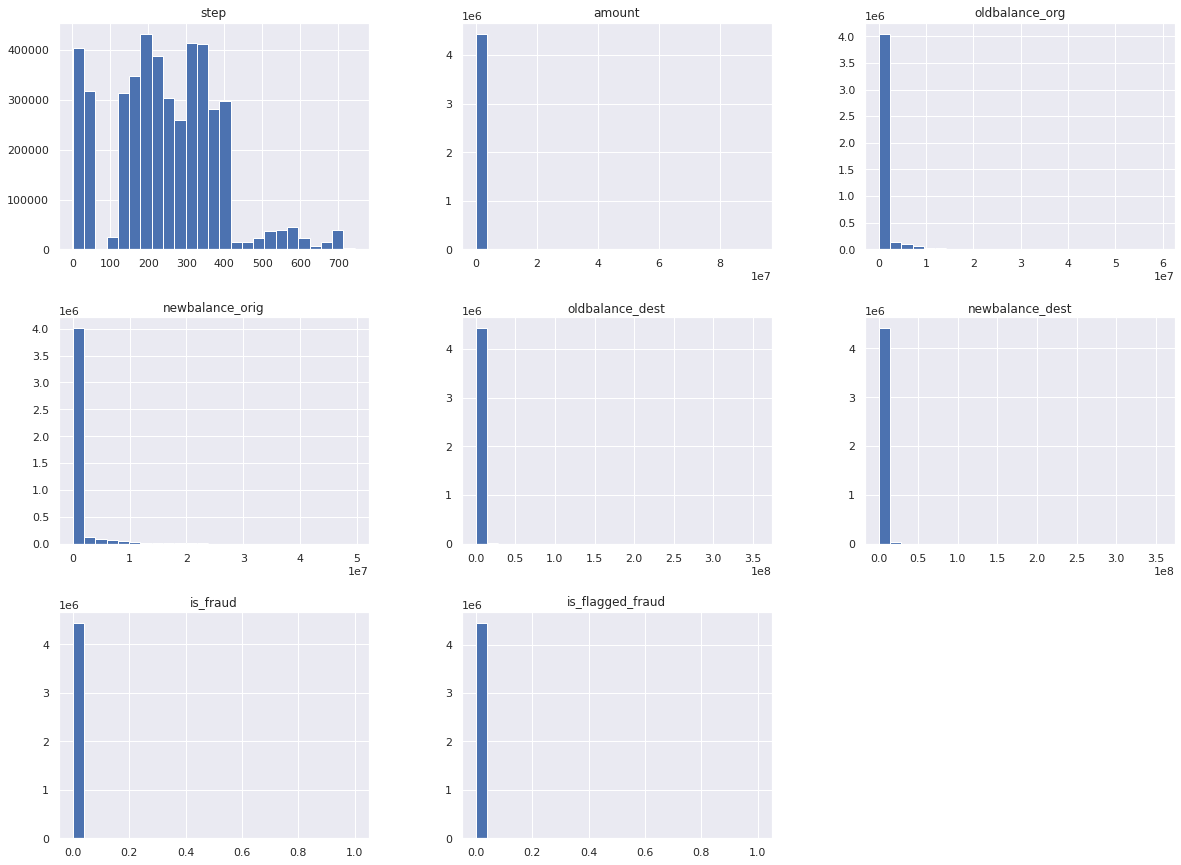

In [15]:
# apply num_stats function (see 0.1. helper function for more details)
num_stats(num_attr)

**Descriptive Statistics Analysis:**
- None of the balances have negative numbers.
- Transaction amount ranges from 0 to more than 92 Million. Mean = 179,939. Median = 74,822. 75% of the observations are up to the value of 208,651. The minimum value is equal to zero - does it actually mean a transaction?
- The intial balance before the transaction (oldbalance_org) ranges from 0 to more than 59 Million. Mean = 834,757. Median = 14,235. 25% of the observations are equal to zero. 75% of the observations are up to the value of 107,429.
- The new balance after the transaction (newbalance_orig) ranges from 0 to more than 49 Million. Mean = 855,975. Median = 0. 50% of the observations are equal to zero. 75% of the observations are up to the value of 144,412.
- The initial balance recipient before the transaction (oldbalance_dest) ranges from 0 to more than 356 Million. Mean = 1,100,704. Median = 132,887. 25% of the observations are equal to zero. 75% of the observations are up to the value of 943,372.
- The new balance recipient after the transaction (newbalance_dest) ranges from zero to more than 356 Million. Mean = 1,225,085. Median = 214,938. 25% of the observations are equal to zero - it can be either from merchant or from fraudulent agent behaviour (cashing out of the system). 75% of the observations are up to the value of 1,112,270.

**Histogram Analysis:**
- Between steps 50 and 75 seems that there are few / not transactions;
- After step 400 the frequency of transactions decreases significantly.
- The histograms, with exception of step feature, are not readable due to the high value range. Therefore, other types of graphs must be applied in order to check the data distribution.

#### 1.6.1.1. amount feature analysis

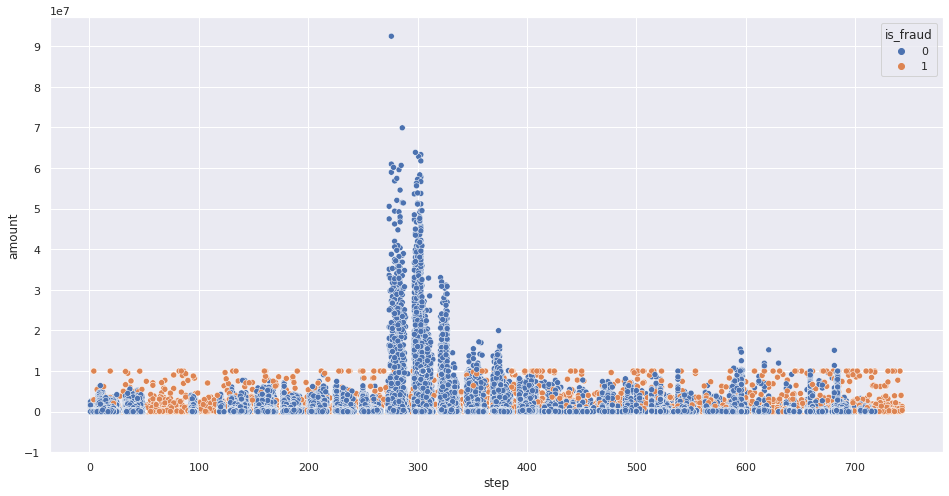

In [16]:
# plot amount scatter plot

# set up figure size
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='amount', hue='is_fraud', data=num_attr)

# set y-axis labels
plt.yticks(np.arange(-1.e+07, 1.e+08, step=1.e+07));

**Analysis:**
- Fraudulent transaction amounts are up to the value of 10 million. There is not fraud transaction above transaction amount of 10 million.
- It seems that there are more fraudulent transactions than normal ones from step 50 to 100 and after step 700.

<AxesSubplot:xlabel='amount'>

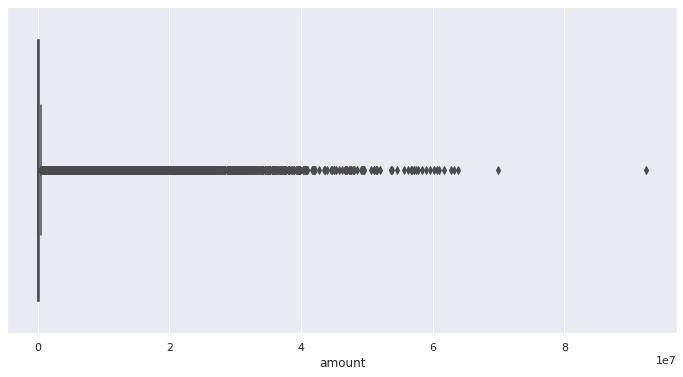

In [17]:
# boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(num_attr['amount'])

In [18]:
# check transactions with amount equal zero
aux1 = df1[df1['amount'] == 0]
aux2 = len(aux1)
aux2

11

In [19]:
# check aux1
aux1

step      type  amount    name_orig  oldbalance_org  newbalance_orig  \
160451    671  CASH_OUT     0.0  C1960007029             0.0              0.0   
1174071   279  CASH_OUT     0.0   C539112012             0.0              0.0   
1237625   250  CASH_OUT     0.0   C521393327             0.0              0.0   
2022803   730  CASH_OUT     0.0   C729003789             0.0              0.0   
2175107   586  CASH_OUT     0.0  C1303719003             0.0              0.0   
2504839   387  CASH_OUT     0.0  C1294472700             0.0              0.0   
3072610   646  CASH_OUT     0.0  C1997645312             0.0              0.0   
3360842   425  CASH_OUT     0.0    C69493310             0.0              0.0   
3701867   617  CASH_OUT     0.0  C1971175979             0.0              0.0   
3718538   212  CASH_OUT     0.0  C1510987794             0.0              0.0   
4237583   730  CASH_OUT     0.0  C2088151490             0.0              0.0   

           name_dest  oldbalance_dest  newbalance_dest  is_fraud  \
160451    C459118517         27938.72         27938.72         1   
1174071  C1106468520        538547.63        538547.63         1   
1237625   C480398193             0.00             0.00         1   
2022803  C1388096959       1008609.53       1008609.53         1   
2175107   C900608348       1328472.86       1328472.86         1   
2504839  C1325541393       7970766.57       7970766.57         1   
3072610   C601248796             0.00             0.00         1   
3360842   C719711728       2921531.34       2921531.34         1   
3701867  C1352345416             0.00             0.00         1   
3718538  C1696624817             0.00             0.00         1   
4237583  C1156763710             0.00             0.00         1   

         is_flagged_fraud  
160451                  0  
1174071                 0  
1237625                 0  
2022803                 0  
2175107                 0  
2504839                 0  
3072610                 0  
3360842                 0  
3701867                 0  
3718538                 0  
4237583                 0

- 11 instances have amount transaction equal to zero, all of them with cash out type and labeled as fraud.

#### 1.6.1.2. oldbalance_org feature analysis

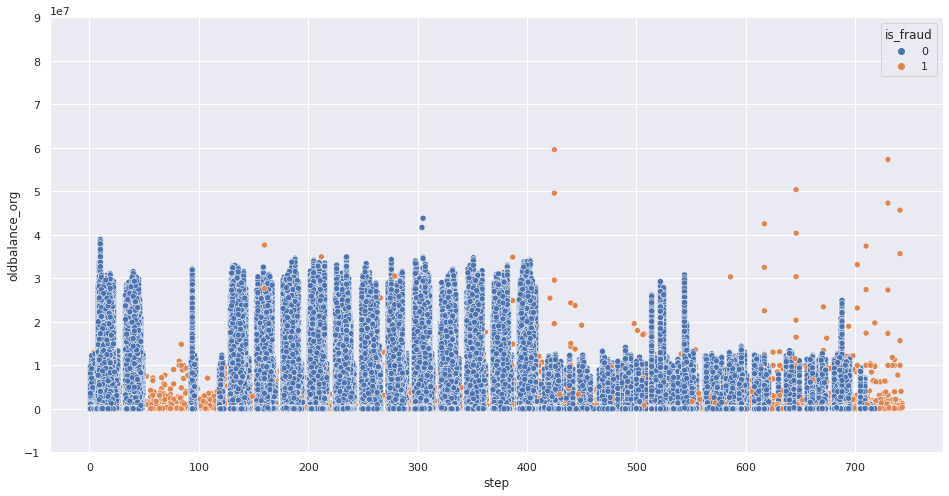

In [20]:
# plot oldbalance_org scatter plot

# set up figure size
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='oldbalance_org', hue='is_fraud', data=num_attr)

# set y-axis labels
plt.yticks(np.arange(-1.e+07, 1.e+08, step=1.e+07));

<AxesSubplot:xlabel='oldbalance_org'>

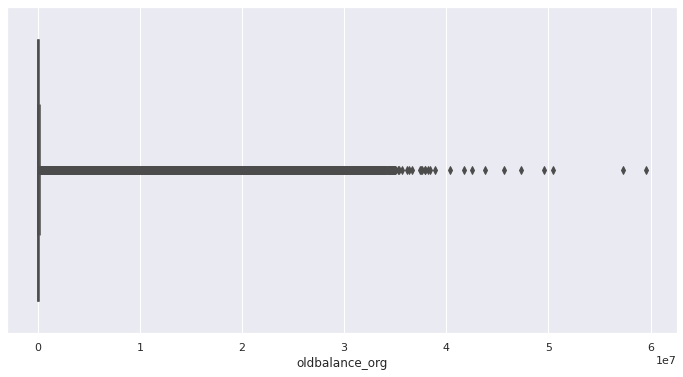

In [21]:
# oldbalance_org boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(num_attr['oldbalance_org'])

#### 1.6.1.3. newbalance_orig feature analysis

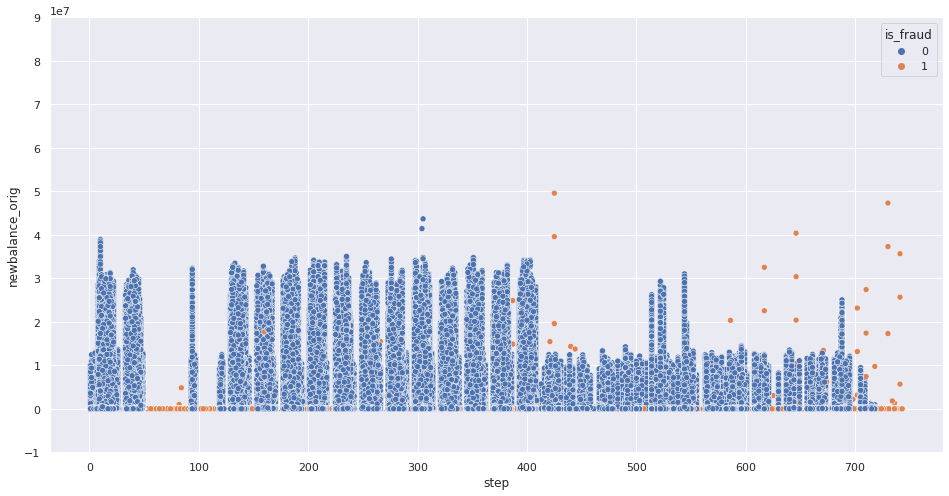

In [22]:
# plot newbalance_orig scatter plot

# set up figure size
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='newbalance_orig', hue='is_fraud', data=num_attr)

# set y-axis labels
plt.yticks(np.arange(-1.e+07, 1.e+08, step=1.e+07));

<AxesSubplot:xlabel='newbalance_orig'>

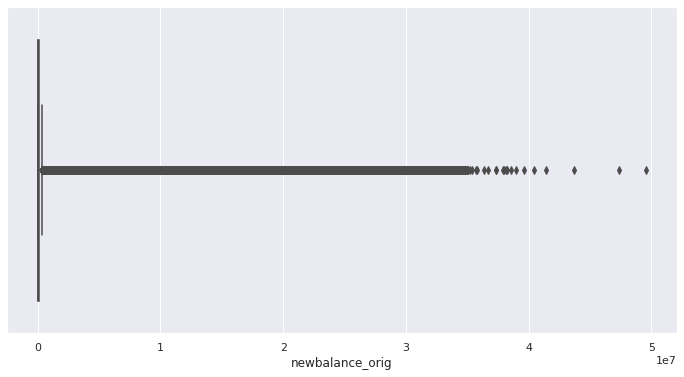

In [23]:
# newbalance_orig boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(num_attr['newbalance_orig'])

In [24]:
# check newbalance_orig value for fraudulent transactions
aux3 = df1[df1['is_fraud'] == 1]

# get the number of instances of newbalance_orig with value equal to zero
aux4 = aux3['newbalance_orig'].value_counts()[0]

# calculate the percentage of newbalance_orig with value equal to zero with respect to the total of frauds
newbal_per = np.round(((aux4 / len(aux3)) * 100), decimals=2)
newbal_per

97.91

**Analisys:**
- The scatterplot shows that the majority of fraudulent transactions are placed in the newbalance_orig equal to zero.
- From all fraudulent transactions, 97.91% have newbalance_orig value equal to zero.

#### 1.6.1.4. oldbalance_dest feature analysis

<AxesSubplot:xlabel='step', ylabel='oldbalance_dest'>

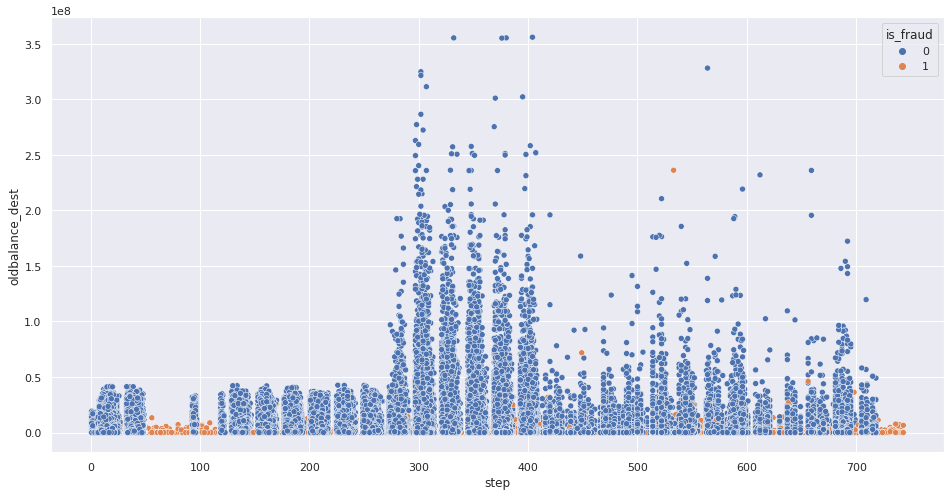

In [25]:
# plot oldbalance_dest scatter plot

# set up figure size
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='oldbalance_dest', hue='is_fraud', data=num_attr)

<AxesSubplot:xlabel='oldbalance_dest'>

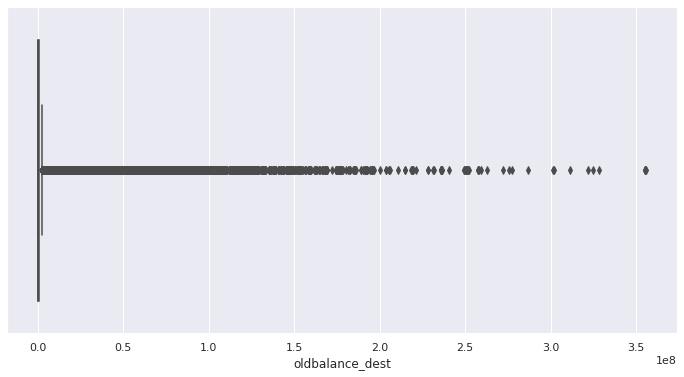

In [26]:
# oldbalance_dest boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(num_attr['oldbalance_dest'])

In [27]:
# check oldbalance_dest value for fraudulent transactions
aux3 = df1[df1['is_fraud'] == 1]

# get the number of instances of oldbalance_dest with value equal to zero
aux5 = aux3['oldbalance_dest'].value_counts()[0]

# calculate the percentage of oldbalance_dest with value equal to zero with respect to the total of frauds
oldbal_per = np.round(((aux5 / len(aux3)) * 100), decimals=2)
oldbal_per

65.19

**Analisys:**
- The scatterplot shows that the majority of fraudulent transactions are placed in the oldbalance_dest equal to zero.
- From all fraudulent transactions, 65.19% have oldbalance_dest value equal to zero.

#### 1.6.1.5. newbalance_dest feature analysis

<AxesSubplot:xlabel='step', ylabel='newbalance_dest'>

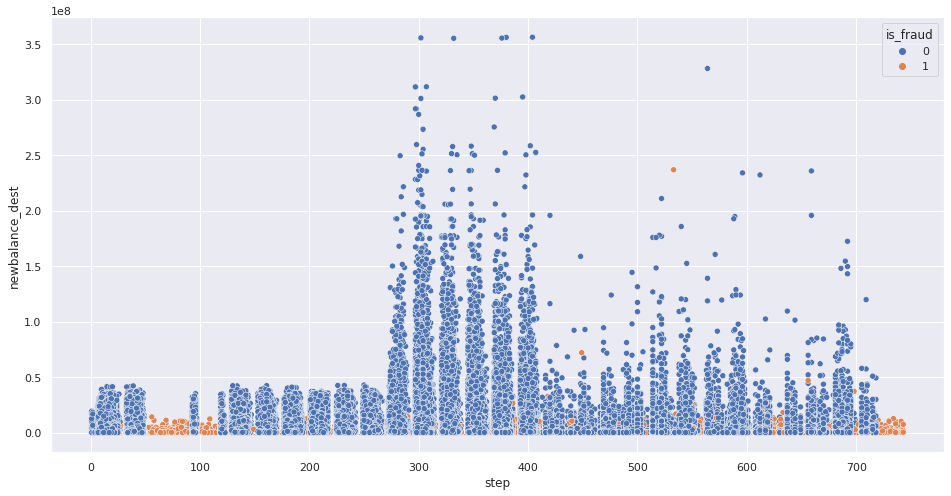

In [28]:
# plot newbalance_dest scatter plot

# set up figure size
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='newbalance_dest', hue='is_fraud', data=num_attr)

<AxesSubplot:xlabel='newbalance_dest'>

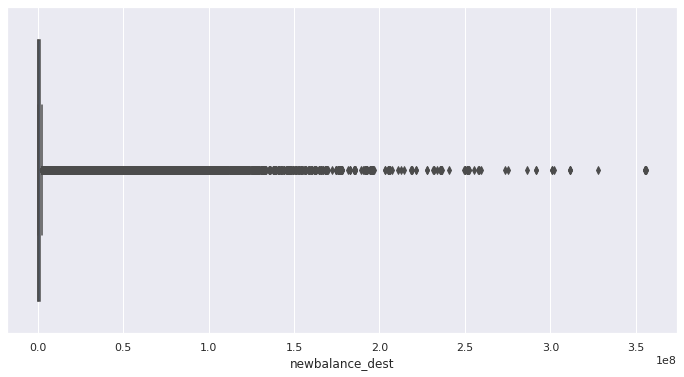

In [29]:
# newbalance_dest boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(num_attr['newbalance_dest'])

In [30]:
# check newbalance_dest value for fraudulent transactions

# get the number of instances of newbalance_dest with value equal to zero
aux6 = aux3['newbalance_dest'].value_counts()[0]

# calculate the percentage of newbalance_dest with value equal to zero with respect to the total of frauds
newbal_per = np.round(((aux6 / len(aux3)) * 100), decimals=2)
newbal_per

49.9

**Analisys:**
- The scatterplot shows that most of fraudulent transactions are placed in the newbalance_dest equal to zero.
- From all fraudulent transactions, 49.9% have newbalance_dest value equal to zero.

### 1.6.2. Categorical Attributes

In [31]:
# select categorical attributes
cat_attr = df1.select_dtypes(exclude=['int64', 'float64'])

In [32]:
cat_attr.describe()

type    name_orig    name_dest
count    4453834      4453834      4453834
unique         5      4449295      2034519
top     CASH_OUT  C1976208114  C1590550415
freq     1565926            3           84

In [33]:
# Check unique entries of categorical attributes
cat_attr.apply( lambda x: x.unique().shape[0] )

type               5
name_orig    4449295
name_dest    2034519
dtype: int64

In [34]:
# check type feature
type_counts = cat_attr['type'].value_counts()
type_counts

CASH_OUT    1565926
PAYMENT     1506155
CASH_IN      979750
TRANSFER     373044
DEBIT         28959
Name: type, dtype: int64

In [35]:
# create type feature percentage dataframe
# list of values and names from type_counts
value_list = []
name_list = []
for i in range(len(type_counts)):
    percent = np.round(((type_counts[i] / len(cat_attr)) * 100), decimals=2)
    value_list.append(percent)
    name_list.append(type_counts.index[i])

# create dataframe
type_df = pd.DataFrame({'percentage_%': value_list}, index=name_list)
type_df

percentage_%
CASH_OUT         35.16
PAYMENT          33.82
CASH_IN          22.00
TRANSFER          8.38
DEBIT             0.65

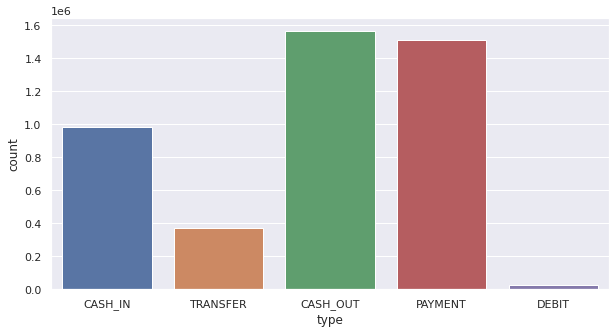

In [36]:
# plot type feature
plt.subplots(figsize=(10,5))
sns.countplot(x='type', data=cat_attr);

<AxesSubplot:xlabel='type', ylabel='amount'>

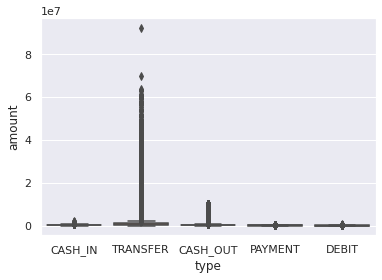

In [37]:
sns.boxplot(x='type', y='amount', data=df1)

- Although the boxplot has not a good resolution due to amount values, it shows that transfer type has the biggest range of amounts.

In [38]:
cat_attr['name_dest'].value_counts()

C1590550415    84
C985934102     76
C1286084959    75
C1360767589    75
C2083562754    73
               ..
M232050294      1
M1279079289     1
C325270201      1
M352209074      1
M410670346      1
Name: name_dest, Length: 2034519, dtype: int64

- Some recipient of transaction participate on transaction more than 80 times.

In [39]:
cat_attr['name_orig'].value_counts()

C1976208114    3
C545315117     3
C1999539787    3
C1784010646    3
C2098525306    3
              ..
C282669568     1
C474930724     1
C680717849     1
C1783752168    1
C751420163     1
Name: name_orig, Length: 4449295, dtype: int64

- Some customers made transactions more than once.

## 1.7. Data Description Summary

**Data Description Summary:**

**1. Balances**
- **None of the balances have negative numbers.**
- The intial balance before the transaction (oldbalance_org) ranges from 0 to aprox. 59 Million. Mean = 834,757. **25% of the observations are equal to zero.** 75% of the observations are up to the value of 107,429.
- The new balance after the transaction (newbalance_orig) ranges from 0 to more than 49 Million. Mean = 855,975. **50% of the observations are equal to zero.** 75% of the observations are up to the value of 144,412.
- The initial balance recipient before the transaction (oldbalance_dest) **ranges from 0 to more than 356 Million.** Mean = 1,100,704. 25% of the observations are equal to zero. 75% of the observations are up to the value of 943,372.
- The new balance recipient after the transaction (newbalance_dest) **ranges from zero to more than 356 Million.** Mean = 1,225,085. 25% of the observations are equal to zero - it can be either from merchant or from fraudulent agent behaviour (cashing out of the system). 75% of the observations are up to the value of 1,112,270.

**2. Transaction Amount**
- Transaction amount ranges from 0 to more than 92 Million, Mean = 179,939. **The minimum value is equal to zero.**
- **The maximum amount value (aprox. 92 Million) is greater than the maximum value of the initial balance before the transaction (aprox. 59 Million).**
- Between steps 50 and 75 seems that there are few / not transactions;
- After step 400 the frequency of transactions decreases significantly.
- **Fraudulent transaction amounts are up to the value of 10 million. There is not fraud transaction above 10 million.**
- 11 instances have amount transaction equal to zero, all of them with cash out type and labeled as fraud.
- There are instances with amount higher than oldbalance_org.

**3. fraud label**
- Only 0.13% of the observations are labeled as fraud

**From all fraudulent transactions:**
- **97.91% have newbalance_orig value equal to zero.**
- **65.19% have oldbalance_dest value equal to zero.**
- **49.9% have newbalance_dest value equal to zero.**

**4. is_flagged_fraud label**
- 14 instances are labeled as is_flagged_fraud. That represents only 0.03% of the instances.

**5. Type feature**
- 68% of the transactions are cash out and payment types.
- Almost 22% of transactions are cash in type, 8% are transfer type and only 0.65% are debit type.
- The transfer type has the biggest transaction amount range.

**6. Name_dest, name_orig features**
- **Some recipient of transaction participate on transaction more than 80 times.**
- Some customers made transactions more than once.

## 1.8. Save training set

In [41]:
# save train set for future notebook work
df1.to_csv('dataset/df1_v02.csv', index=False)

# 2.0. Feature Engineering

In [6]:
# open previously saved training set
df2 = pd.read_csv('dataset/df1_v02.csv')
df2.head()

step      type      amount    name_orig  oldbalance_org  newbalance_orig  \
0   308   CASH_IN   260485.23   C386091144        32371.00        292856.23   
1    16  TRANSFER  1387060.19   C977405179       432673.78             0.00   
2   254  TRANSFER  1140661.98  C1091684896        59947.00             0.00   
3   380   CASH_IN   169390.39   C300199504        80047.10        249437.49   
4    40   CASH_IN     4867.26   C905217988      5989226.14       5994093.40   

     name_dest  oldbalance_dest  newbalance_dest  is_fraud  is_flagged_fraud  
0   C268784004       4633560.35       4373075.12         0                 0  
1  C1032483118             0.00       1033440.62         0                 0  
2  C1969901822         15000.85       1155662.83         0                 0  
3   C591887141       1467039.66       1297649.27         0                 0  
4   C926869366       1609385.28       1604518.02         0                 0

## 2.1. Mind Map

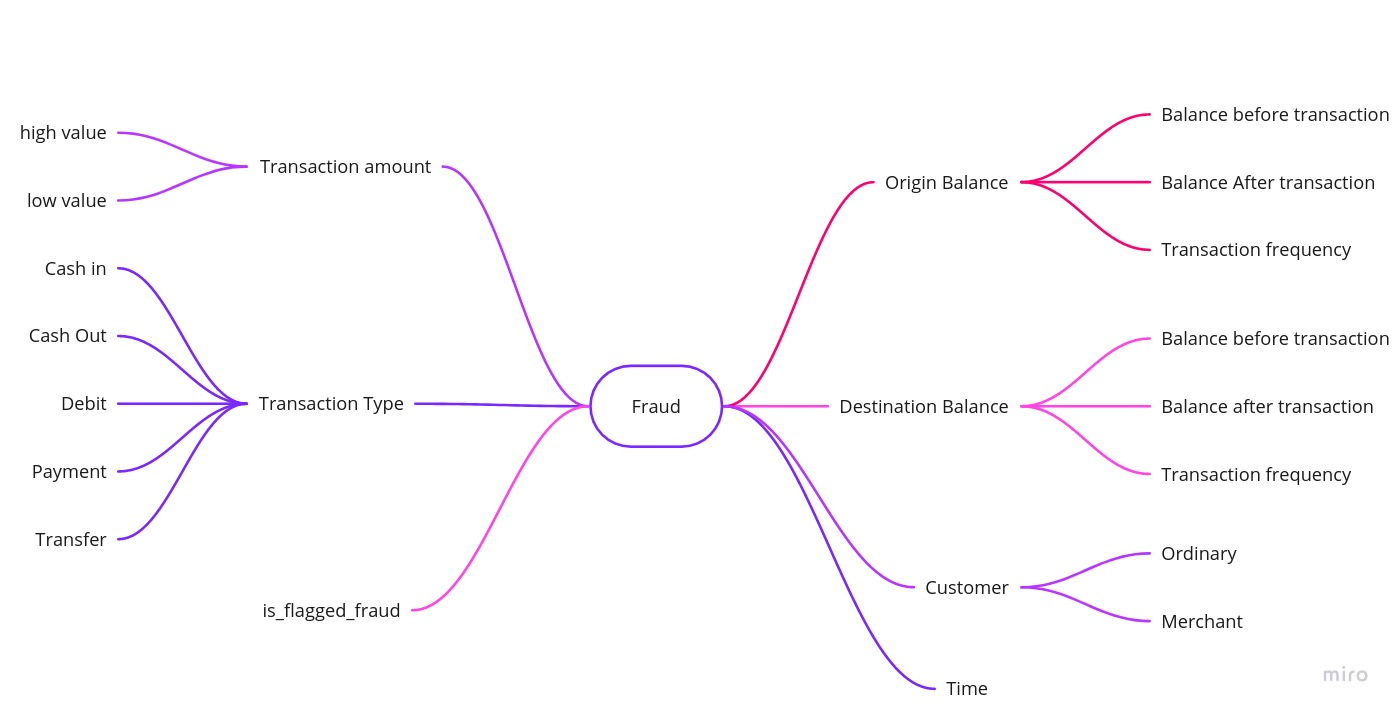

In [3]:
# load mind map image
Image('images/mindmap.jpg')

## 2.2. Hypothesis Creation

### 2.2.1. Transaction Amount

**1.** Fraud should occur with high transaction amount.

### 2.2.2. Transaction Type

**1.** Fraud should occur with cash out transaction type

### 2.2.3. Origin Balance

**1.** Fraud should not occur when the origin balance before the transaction is equal to zero.

**2.** Fraud should occur when origin balance after the transaction is equal to zero.

**3.** Fraud should occur when the origin balance difference before and after the transaction is different from the transaction amount.

### 2.2.4. Recipient Balance

**1.** Fraud should occur when the recipient balance after the transaction is equal to zero.

**2.** Fraud should occur when the recipient balance difference before and after the transaction is different from the transaction amount.

**3.** Fraud should not occur when the recipient balance difference before and after the transaction is equal to the origin difference before and after the transaction and equal to the transaction amount.

### 2.2.5. Customer

**1.** Fraud should occur for merchant customer as recipient.

**2.** Fraud should occur for customers that receive the transaction with more frequency.

### 2.2.6. Time

**1.** Fraud should occur for transactions made before day 15.

### 2.2.7. is_flagged_fraud

**1.** Fraud should occur when is_flagged_fraud is equal to one when transaction amount is higher than 200,000.

## 2.3. Final Hypothesis List (Based on the data available in the dataset)

**1.** Fraud should occur with high transaction amount.

**2.** Fraud should occur with cash out transaction type.

**3.** Fraud should not occur when the origin balance before the transaction is equal to zero.

**4.** Fraud should occur when origin balance after the transaction is equal to zero.

**5.** Fraud should occur when the origin balance difference before and after the transaction is different from the transaction amount.

**6.** Fraud should occur when the recipient balance after the transaction is equal to zero in more than 70% of the fraudulent transactions.

**7.** Fraud should occur when the recipient balance difference before and after the transaction is different from the transaction amount.

**8.** Fraud should not occur when the recipient balance difference before and after the transaction is equal to the origin difference before and after the transaction.

**9.** Fraud should occur for merchant customer as recipient.

**10.** Fraud should occur for customers that receive the transaction with more frequency.

**11.** Fraud should occur for transactions made before day 15.

## 2.4. Feature Engineering

- As previously checked in the data description, **some amount transactions are higher than the origin banlance before the transaction. Also, there are amount instances equal to zero.Theoretically, the difference between the origin balance before and after the transaction should be equal to the transaction amount.** Therefore, a new feature will be created to check this.


- The same is true for the destination balance: **theoretically, the difference between the destination balance after and before the transaction should be equal to the transaction amount.** Therefore, a new feature will be created to check this.


- As stated above in the features description, the balance destination information for merchant customers is not available. Therefore, a new feature will be created to differentiate such customers to the ordinary ones.


- A new time feature can be created based on the step information to determine the day in which the transactions happened, in order to ease the analysis.

In [7]:
df2.sample(5)

step      type     amount    name_orig  oldbalance_org  \
2677121   186   PAYMENT   15582.42  C1112605294       565607.67   
653339     34   CASH_IN  137196.59  C1579409645        46655.00   
2578301   186  CASH_OUT  299487.00   C464232367            0.00   
1761219   161  CASH_OUT   60563.20   C579266092            0.00   
3623006   375     DEBIT    1178.78   C506036566        23082.00   

         newbalance_orig    name_dest  oldbalance_dest  newbalance_dest  \
2677121        550025.25   M709124522             0.00             0.00   
653339         183851.59    C40130986             0.00             0.00   
2578301             0.00  C1760516106       1441703.52       1741190.52   
1761219             0.00   C682156667        194468.29        255031.49   
3623006         21903.22  C1512709177        238608.72        239787.51   

         is_fraud  is_flagged_fraud  
2677121         0                 0  
653339          0                 0  
2578301         0                 0  
1761219         0                 0  
3623006         0                 0

In [8]:
# create origin balance difference feature
df2['diff_orig'] = df2['oldbalance_org'] - df2['amount'] - df2['newbalance_orig']

# create destination balance difference feature
df2['diff_dest'] = df2['oldbalance_dest'] + df2['amount'] - df2['newbalance_dest']

In [9]:
df2.head()

step      type      amount    name_orig  oldbalance_org  newbalance_orig  \
0   308   CASH_IN   260485.23   C386091144        32371.00        292856.23   
1    16  TRANSFER  1387060.19   C977405179       432673.78             0.00   
2   254  TRANSFER  1140661.98  C1091684896        59947.00             0.00   
3   380   CASH_IN   169390.39   C300199504        80047.10        249437.49   
4    40   CASH_IN     4867.26   C905217988      5989226.14       5994093.40   

     name_dest  oldbalance_dest  newbalance_dest  is_fraud  is_flagged_fraud  \
0   C268784004       4633560.35       4373075.12         0                 0   
1  C1032483118             0.00       1033440.62         0                 0   
2  C1969901822         15000.85       1155662.83         0                 0   
3   C591887141       1467039.66       1297649.27         0                 0   
4   C926869366       1609385.28       1604518.02         0                 0   

    diff_orig  diff_dest  
0  -520970.46  520970.46  
1  -954386.41  353619.57  
2 -1080714.98       0.00  
3  -338780.78  338780.78  
4    -9734.52    9734.52

In [10]:
# check if name_orig has merchant customer
df2['name_orig'].str.contains('M').sum()

0

In [11]:
# check merchant customer on name_dest
df2['name_dest'].str.contains('M').sum()

1506155

- name_orig does not have merchant customer. Therefore, it is not necessary to create a new feature;
- name_dest has 430,261 instances with merchant customer. Therefore, a new feature will be created.

In [12]:
# create merchant_dest feature
df2['merchant_dest'] = df2.apply(lambda x: 1 if 'M' in x['name_dest'] else 0, axis=1)
df2.head()

step      type      amount    name_orig  oldbalance_org  newbalance_orig  \
0   308   CASH_IN   260485.23   C386091144        32371.00        292856.23   
1    16  TRANSFER  1387060.19   C977405179       432673.78             0.00   
2   254  TRANSFER  1140661.98  C1091684896        59947.00             0.00   
3   380   CASH_IN   169390.39   C300199504        80047.10        249437.49   
4    40   CASH_IN     4867.26   C905217988      5989226.14       5994093.40   

     name_dest  oldbalance_dest  newbalance_dest  is_fraud  is_flagged_fraud  \
0   C268784004       4633560.35       4373075.12         0                 0   
1  C1032483118             0.00       1033440.62         0                 0   
2  C1969901822         15000.85       1155662.83         0                 0   
3   C591887141       1467039.66       1297649.27         0                 0   
4   C926869366       1609385.28       1604518.02         0                 0   

    diff_orig  diff_dest  merchant_dest  
0  -520970.46  520970.46              0  
1  -954386.41  353619.57              0  
2 -1080714.98       0.00              0  
3  -338780.78  338780.78              0  
4    -9734.52    9734.52              0

In [13]:
# create day feature
df2['day'] = df2.apply(lambda x: (np.ceil(x['step'] / 24)).astype(int), axis=1)
df2.head()

step      type      amount    name_orig  oldbalance_org  newbalance_orig  \
0   308   CASH_IN   260485.23   C386091144        32371.00        292856.23   
1    16  TRANSFER  1387060.19   C977405179       432673.78             0.00   
2   254  TRANSFER  1140661.98  C1091684896        59947.00             0.00   
3   380   CASH_IN   169390.39   C300199504        80047.10        249437.49   
4    40   CASH_IN     4867.26   C905217988      5989226.14       5994093.40   

     name_dest  oldbalance_dest  newbalance_dest  is_fraud  is_flagged_fraud  \
0   C268784004       4633560.35       4373075.12         0                 0   
1  C1032483118             0.00       1033440.62         0                 0   
2  C1969901822         15000.85       1155662.83         0                 0   
3   C591887141       1467039.66       1297649.27         0                 0   
4   C926869366       1609385.28       1604518.02         0                 0   

    diff_orig  diff_dest  merchant_dest  day  
0  -520970.46  520970.46              0   13  
1  -954386.41  353619.57              0    1  
2 -1080714.98       0.00              0   11  
3  -338780.78  338780.78              0   16  
4    -9734.52    9734.52              0    2

In [14]:
# df2 columns
df2.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud', 'diff_orig', 'diff_dest',
       'merchant_dest', 'day'],
      dtype='object')

In [15]:
# reorder columns
df2 = df2[['step', 'day', 'type', 'name_orig', 'amount', 'oldbalance_org',
       'newbalance_orig', 'diff_orig', 'name_dest', 'merchant_dest', 
       'oldbalance_dest', 'newbalance_dest', 'diff_dest',
       'is_fraud', 'is_flagged_fraud']]

df2.tail()

step  day      type    name_orig     amount  oldbalance_org  \
4453829   139    6  TRANSFER  C1355477215  175520.68           977.0   
4453830   402   17  CASH_OUT   C788162540  347110.99        103785.0   
4453831   304   13   PAYMENT   C545341724   13259.63             0.0   
4453832   298   13   PAYMENT  C1831600144   24122.92             0.0   
4453833   154    7   PAYMENT  C1013856770    6865.63             0.0   

         newbalance_orig  diff_orig    name_dest  merchant_dest  \
4453829              0.0 -174543.68  C2010442020              0   
4453830              0.0 -243325.99  C1771727447              0   
4453831              0.0  -13259.63   M253734860              1   
4453832              0.0  -24122.92  M1382629737              1   
4453833              0.0   -6865.63  M1721419416              1   

         oldbalance_dest  newbalance_dest  diff_dest  is_fraud  \
4453829         91159.52        266680.20       0.00         0   
4453830         87871.75        434982.74       0.00         0   
4453831             0.00             0.00   13259.63         0   
4453832             0.00             0.00   24122.92         0   
4453833             0.00             0.00    6865.63         0   

         is_flagged_fraud  
4453829                 0  
4453830                 0  
4453831                 0  
4453832                 0  
4453833                 0

# 3.0. Variables Filtering

In [16]:
df3 = df2.copy()

## 3.1. Lines Filtering

In [17]:
# Remove outliers from amount feature
df3 = df3[df3['amount'] < 20e6]
df3.shape

# Remove oldbalance_dest outliers
df3 = df3[df3['oldbalance_dest'] < 5e7]
df3.shape

# Remove newbalance_dest outliers
df3 = df3[df3['newbalance_dest'] < 5e7]

## 3.2. Save training set

In [18]:
# save train set for future notebook work
df3.to_csv('dataset/df3_v02.csv', index=False)

# 4.0. EDA - Exploratory Data Analysis

In [6]:
# open previously saved training set
df4 = pd.read_csv('dataset/df3_v02.csv')

## 4.1. Univariate Analysis**

In [7]:
df4.sample(5)

step  day      type    name_orig     amount  oldbalance_org  \
1042675   235   10  CASH_OUT  C1048254829  378917.20           185.0   
743089    209    9   PAYMENT  C1493757232   21109.72             0.0   
504072    274   12   PAYMENT   C412340585    1151.94         50104.0   
3708137   522   22  CASH_OUT  C2046307794  226670.95           219.0   
3386935   331   14   PAYMENT  C1269382849    7840.85         30740.0   

         newbalance_orig  diff_orig    name_dest  merchant_dest  \
1042675             0.00 -378732.20  C1795477925              0   
743089              0.00  -21109.72   M868520193              1   
504072          48952.06       0.00   M872834120              1   
3708137             0.00 -226451.95  C1994782552              0   
3386935         22899.15       0.00   M954675380              1   

         oldbalance_dest  newbalance_dest  diff_dest  is_fraud  \
1042675              0.0        378917.20       0.00         0   
743089               0.0             0.00   21109.72         0   
504072               0.0             0.00    1151.94         0   
3708137              0.0        226670.95       0.00         0   
3386935              0.0             0.00    7840.85         0   

         is_flagged_fraud  
1042675                 0  
743089                  0  
504072                  0  
3708137                 0  
3386935                 0

### 4.1.1. Target Variable

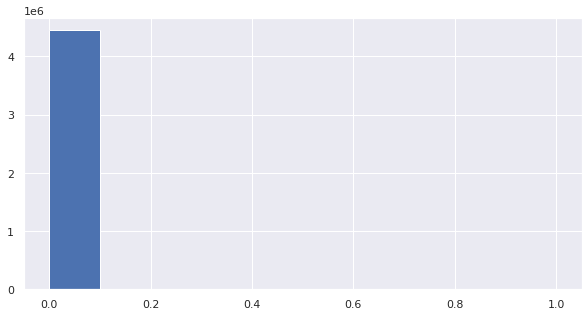

In [8]:
# plot target variable
df4['is_fraud'].hist(figsize=(10,5));

In [9]:
# check is_fraud labels proportion
df4['is_fraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: is_fraud, dtype: float64

- The graph is not visually clear regarding is_fraud = 1 due to its low proportion (0.1291%).
- The is_fraud feature is better visualized with respect to the other features. The graphs are shown below in the bivariate analysis.

- Plot fraudulent transactions per day

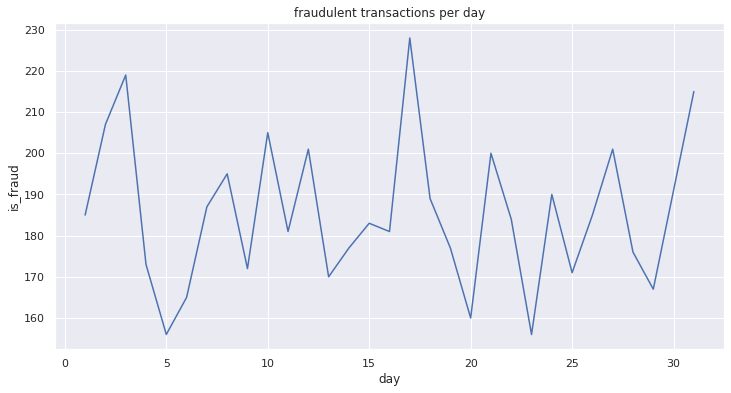

In [10]:
# plot fraudulent transactions per day
aux1 = df4[['day', 'is_fraud']].groupby('day').sum().reset_index()

# set up figure size
plt.subplots(figsize=(12,6))
sns.lineplot(x='day', y='is_fraud', data=aux1).set_title('fraudulent transactions per day');

### 4.1.2. Numerical Variable**

In [11]:
# select numerical attributes
num_attr = df4.select_dtypes(include=['int64', 'float64'])
num_attr.head()

step  day      amount  oldbalance_org  newbalance_orig   diff_orig  \
0   308   13   260485.23        32371.00        292856.23  -520970.46   
1    16    1  1387060.19       432673.78             0.00  -954386.41   
2   254   11  1140661.98        59947.00             0.00 -1080714.98   
3   380   16   169390.39        80047.10        249437.49  -338780.78   
4    40    2     4867.26      5989226.14       5994093.40    -9734.52   

   merchant_dest  oldbalance_dest  newbalance_dest  diff_dest  is_fraud  \
0              0       4633560.35       4373075.12  520970.46         0   
1              0             0.00       1033440.62  353619.57         0   
2              0         15000.85       1155662.83       0.00         0   
3              0       1467039.66       1297649.27  338780.78         0   
4              0       1609385.28       1604518.02    9734.52         0   

   is_flagged_fraud  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [12]:
# check num_attr describe
num_attr.describe()

step           day        amount  oldbalance_org  \
count  4.450894e+06  4.450894e+06  4.450894e+06    4.450894e+06   
mean   2.433152e+02  1.048841e+01  1.745623e+05    8.347084e+05   
std    1.423257e+02  5.921594e+00  4.619477e+05    2.890022e+06   
min    1.000000e+00  1.000000e+00  0.000000e+00    0.000000e+00   
25%    1.550000e+02  7.000000e+00  1.337757e+04    0.000000e+00   
50%    2.390000e+02  1.000000e+01  7.472071e+04    1.426331e+04   
75%    3.340000e+02  1.400000e+01  2.084553e+05    1.074440e+05   
max    7.430000e+02  3.100000e+01  1.997663e+07    5.958504e+07   

       newbalance_orig     diff_orig  merchant_dest  oldbalance_dest  \
count     4.450894e+06  4.450894e+06   4.450894e+06     4.450894e+06   
mean      8.559272e+05 -1.957811e+05   3.383938e-01     1.052461e+06   
std       2.925794e+06  4.658650e+05   4.731633e-01     2.581511e+06   
min       0.000000e+00 -1.997370e+07   0.000000e+00     0.000000e+00   
25%       0.000000e+00 -2.491953e+05   0.000000e+00     0.000000e+00   
50%       0.000000e+00 -6.846402e+04   0.000000e+00     1.322592e+05   
75%       1.444890e+05 -2.938207e+03   1.000000e+00     9.402472e+05   
max       4.958504e+07  1.000000e-02   1.000000e+00     4.996937e+07   

       newbalance_dest     diff_dest      is_fraud  is_flagged_fraud  
count     4.450894e+06  4.450894e+06  4.450894e+06      4.450894e+06  
mean      1.169837e+06  5.718608e+04  1.291201e-03      3.145436e-06  
std       2.758700e+06  3.705792e+05  3.591009e-02      1.773535e-03  
min       0.000000e+00 -4.236412e+07  0.000000e+00      0.000000e+00  
25%       0.000000e+00  0.000000e+00  0.000000e+00      0.000000e+00  
50%       2.142843e+05  3.512725e+03  0.000000e+00      0.000000e+00  
75%       1.108815e+06  2.940972e+04  0.000000e+00      0.000000e+00  
max       4.999057e+07  1.000000e+07  1.000000e+00      1.000000e+00

- **75% of diff_orig values are negative, which means that transactions amount are higher than the origin balance value.**
- This is awkward, since the theoretical diff_orig value should be zero. This must be checked in details in the bivariate analysis.
- The first quartile (25%) diff_dest is equal to zero, which means a correct transaction. However, the merchant destination balance values are equal to zero, therefore this must be checked in details in the bivariate analysis.
- **The majority of diff_dest values are higher than zero, which means that the amount transfered is higher than the new balance destination.** This must be checked in the bivariate analysis.

attributes          min          max        range          mean  \
0               step         1.00       743.00       742.00  2.433152e+02   
1                day         1.00        31.00        30.00  1.048841e+01   
2             amount         0.00  19976629.47  19976629.47  1.745623e+05   
3     oldbalance_org         0.00  59585040.37  59585040.37  8.347084e+05   
4    newbalance_orig         0.00  49585040.37  49585040.37  8.559272e+05   
5          diff_orig -19973695.61         0.01  19973695.62 -1.957811e+05   
6      merchant_dest         0.00         1.00         1.00  3.383938e-01   
7    oldbalance_dest         0.00  49969373.14  49969373.14  1.052461e+06   
8    newbalance_dest         0.00  49990565.51  49990565.51  1.169837e+06   
9          diff_dest -42364116.56  10000000.00  52364116.56  5.718608e+04   
10          is_fraud         0.00         1.00         1.00  1.291201e-03   
11  is_flagged_fraud         0.00         1.00         1.00  3.145436e-06   

        median           std        skew       kurtosis  
0      239.000  1.423257e+02    0.376382       0.330376  
1       10.000  5.921594e+00    0.379097       0.333707  
2    74720.710  4.619476e+05   14.894293     336.956021  
3    14263.315  2.890022e+06    5.246484      32.941400  
4        0.000  2.925794e+06    5.173909      32.029977  
5   -68464.020  4.658650e+05  -13.576999     306.218765  
6        0.000  4.731632e-01    0.683089      -1.533390  
7   132259.190  2.581511e+06    6.008183      55.807056  
8   214284.280  2.758700e+06    6.010336      55.730941  
9     3512.725  3.705792e+05  -35.241292    2415.478802  
10       0.000  3.591008e-02   27.775428     769.474753  
11       0.000  1.773535e-03  563.842367  317916.357142

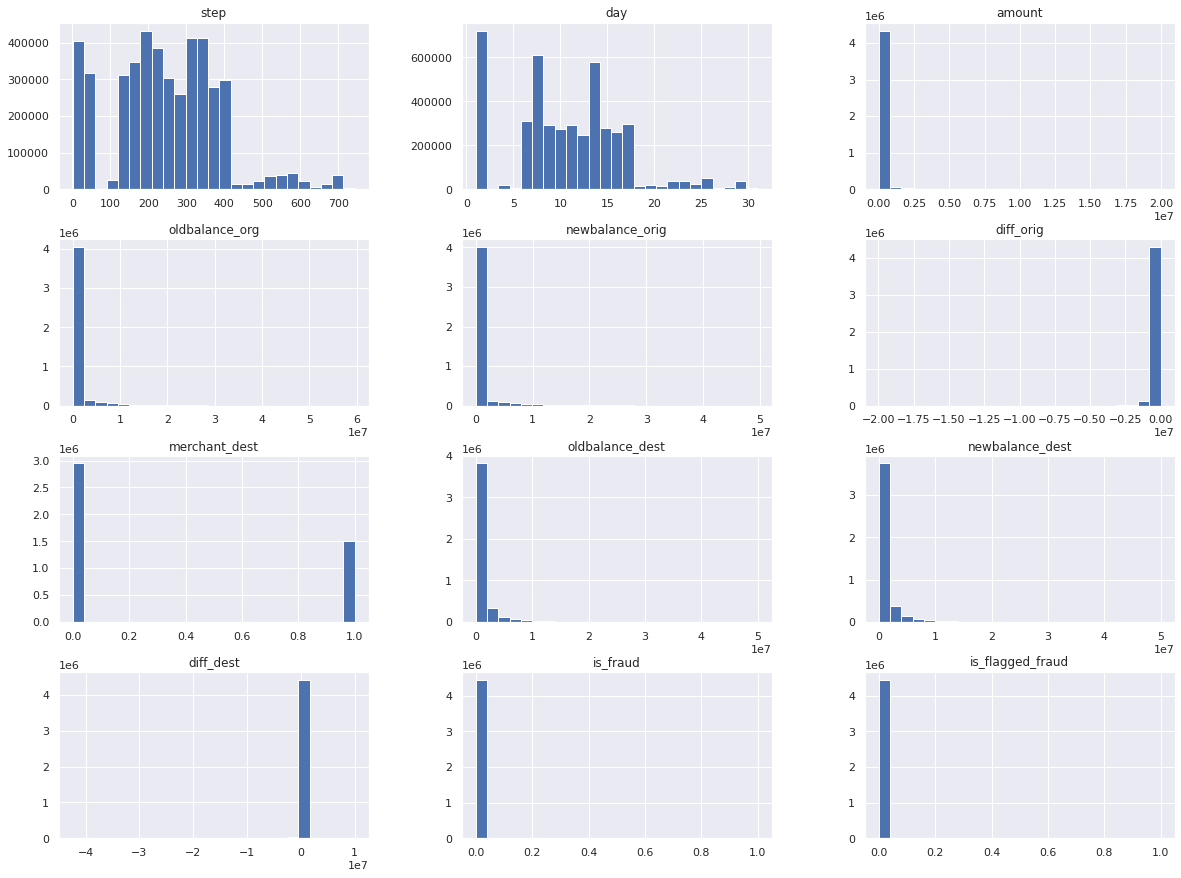

In [13]:
# check num_attr stats
num_stats(num_attr)

- The graphs are not visually clear due to the values range.
- Detailed distribution of the features that are unclear above are plotted below.

#### 4.1.2.1. amount Feature

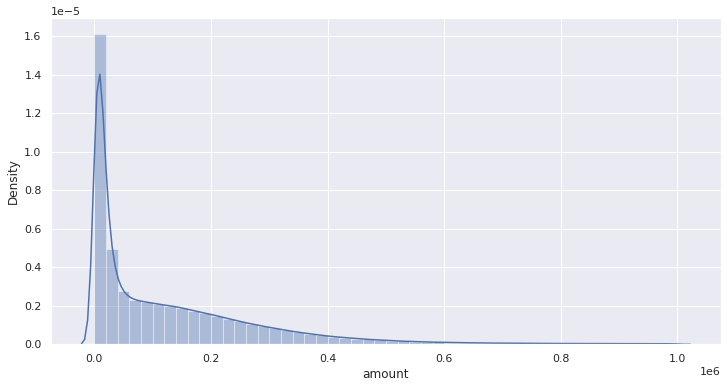

In [14]:
# plot amount distribution values lower than 1,000,000

# set up figure size
plt.subplots(figsize=(12,6))
sns.distplot(df4[df4['amount'] < 1e6]['amount']);

<AxesSubplot:xlabel='amount'>

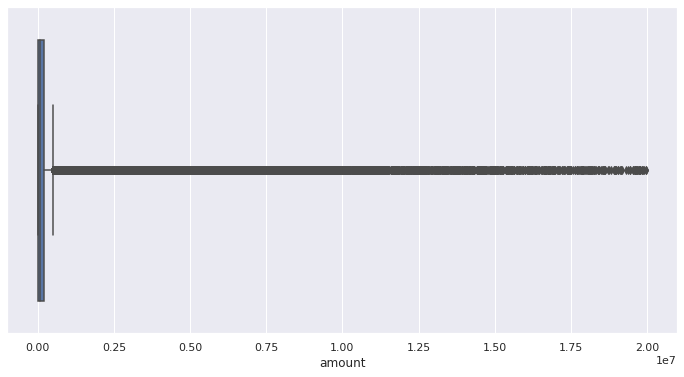

In [15]:
# amount boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(df4['amount'])

#### 4.1.2.2. oldbalance_org feature

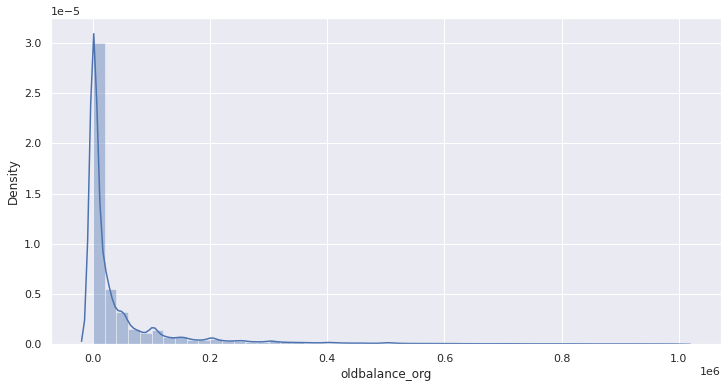

In [16]:
# oldbalance_org distribution lower than 1,000,000

# set up figure size
plt.subplots(figsize=(12,6))
sns.distplot(df4[df4['oldbalance_org'] < 1e6]['oldbalance_org']);

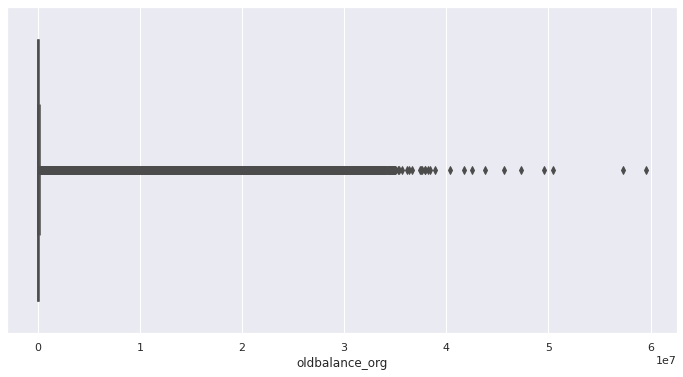

In [17]:
# oldbalance_org boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(df4['oldbalance_org']);

#### 4.1.2.3. newbalance_org feature

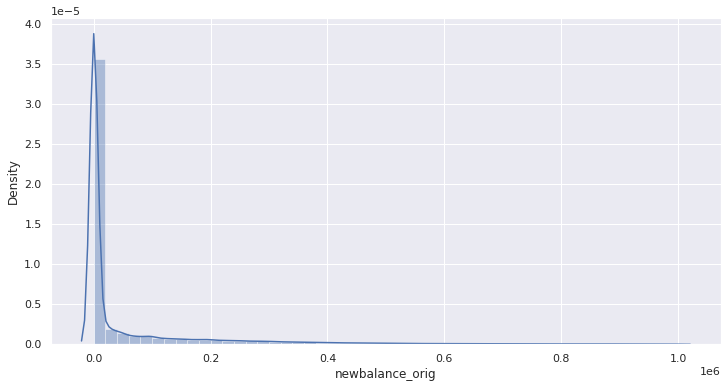

In [18]:
# newbalance_orig distribution values lower than 1,000,000

# set up figure size
plt.subplots(figsize=(12,6))
sns.distplot(df4[df4['newbalance_orig'] < 1e6]['newbalance_orig']);

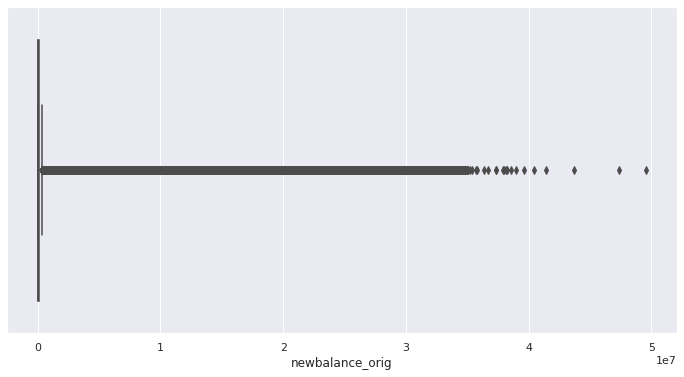

In [19]:
# newbalance_dest boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(df4['newbalance_orig']);

#### 4.1.2.4. diff_orig feature**

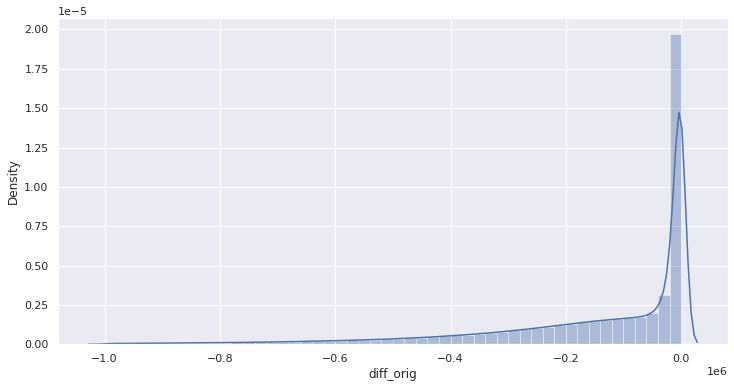

In [20]:
# diff_orig distribution values greater than -1,000,000

# set up figure size
plt.subplots(figsize=(12,6))
sns.distplot(df4[df4['diff_orig'] > -1e6]['diff_orig']);

<AxesSubplot:xlabel='step', ylabel='diff_orig'>

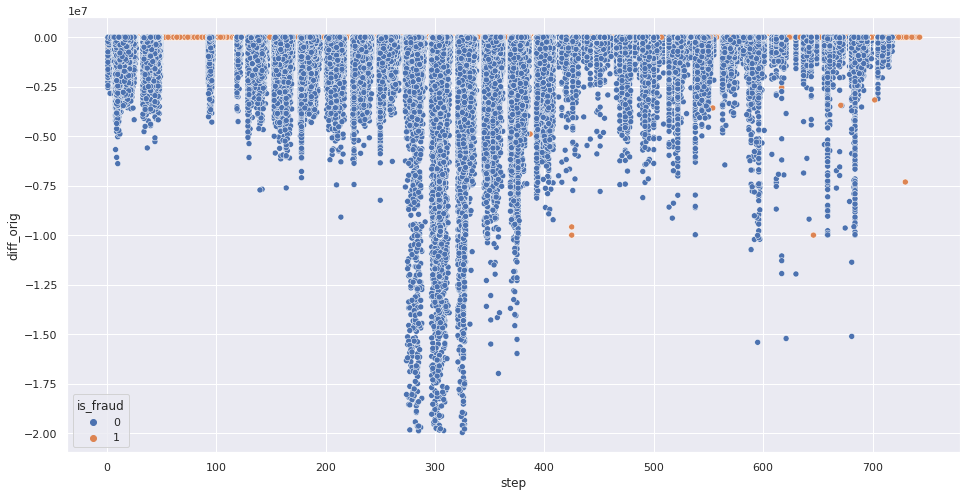

In [21]:
# set up figure size
plt.subplots(figsize=(16,8))
# plot diff_orig scatterplot
sns.scatterplot(x='step', y='diff_orig', hue='is_fraud', data=num_attr)

- diff_orig values labeled as fraudulent are placed in line zero.

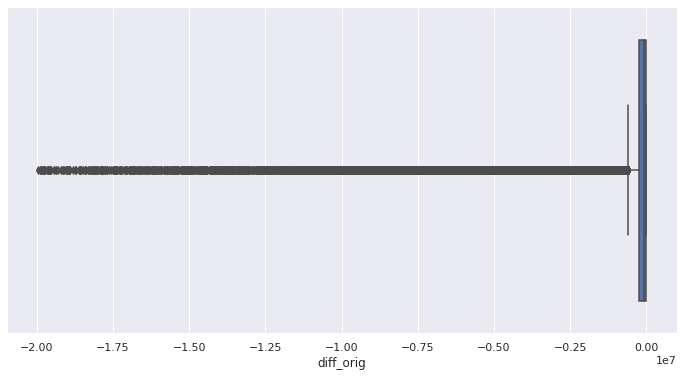

In [22]:
# diff_orig boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(df4['diff_orig']);

In [23]:
df4['diff_orig'].value_counts(normalize=True)

 0.000000e+00    1.491882e-01
-1.000000e-02    3.972011e-03
 1.000000e-02    3.945499e-03
-3.637979e-12    2.862571e-03
 7.275958e-12    2.854932e-03
                     ...     
-2.927789e+05    2.246740e-07
-1.027511e+05    2.246740e-07
-1.567637e+05    2.246740e-07
-1.567655e+05    2.246740e-07
-2.913592e+05    2.246740e-07
Name: diff_orig, Length: 3343723, dtype: float64

- 14.9% of diff_orig values are equal to zero.

#### 4.1.2.5. oldbalance_dest feature

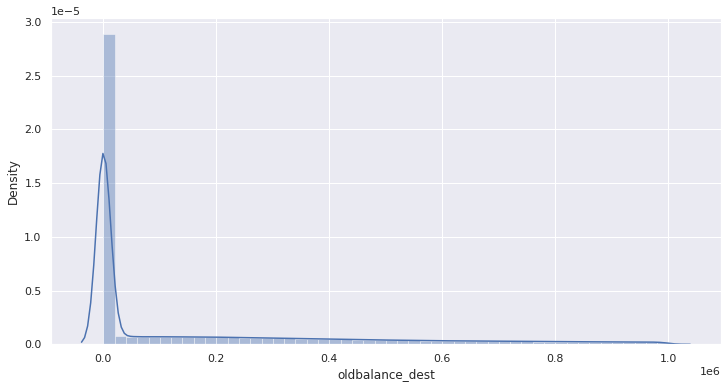

In [24]:
# oldbalance_dest distribution values lower than 1,000,000

# set up figure size
plt.subplots(figsize=(12,6))
sns.distplot(df4[df4['oldbalance_dest'] < 1e6]['oldbalance_dest']);

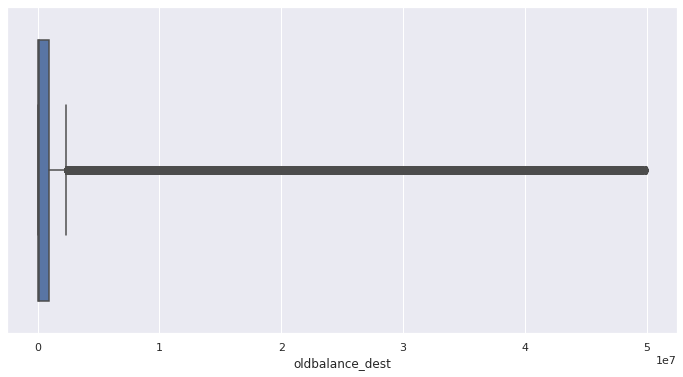

In [25]:
# oldbalance_dest boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(df4['oldbalance_dest']);

#### 4.1.2.6. newbalance_dest feature

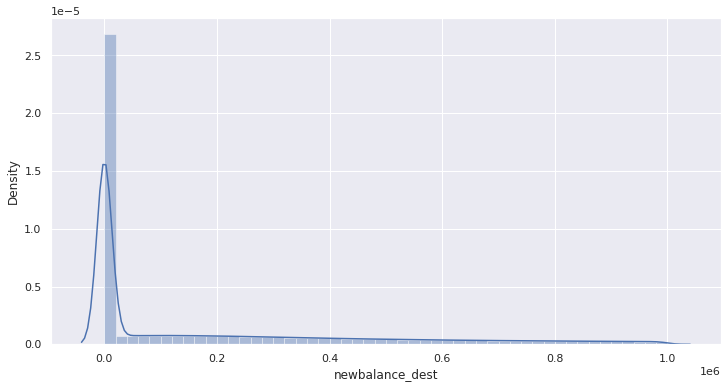

In [26]:
# newbalance_dest distribution

# set up figure size
plt.subplots(figsize=(12,6))
sns.distplot(df4[df4['newbalance_dest'] < 1e6]['newbalance_dest']);

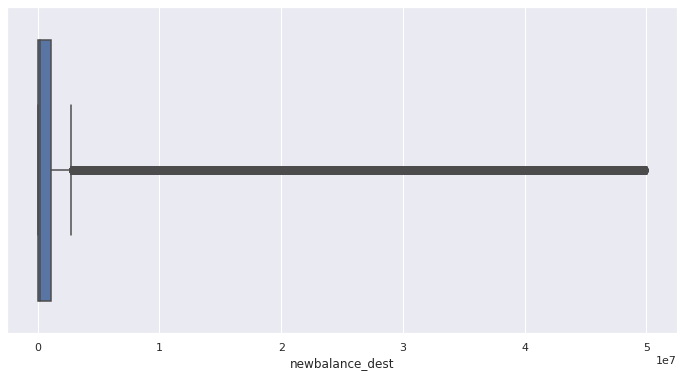

In [27]:
# newbalance_dest boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(df4['newbalance_dest']);

#### 4.1.2.7. diff_dest feature**

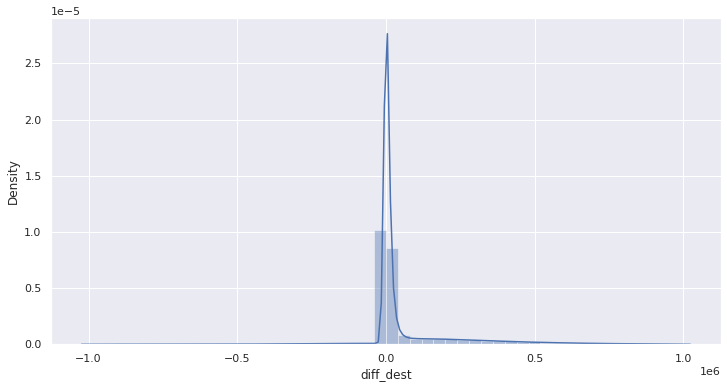

In [28]:
# diff_dest distribution

# set up figure size
plt.subplots(figsize=(12,6))
sns.distplot(df4[(df4['diff_dest'] > -1e6) & (df4['diff_dest'] < 1e6)]['diff_dest']);

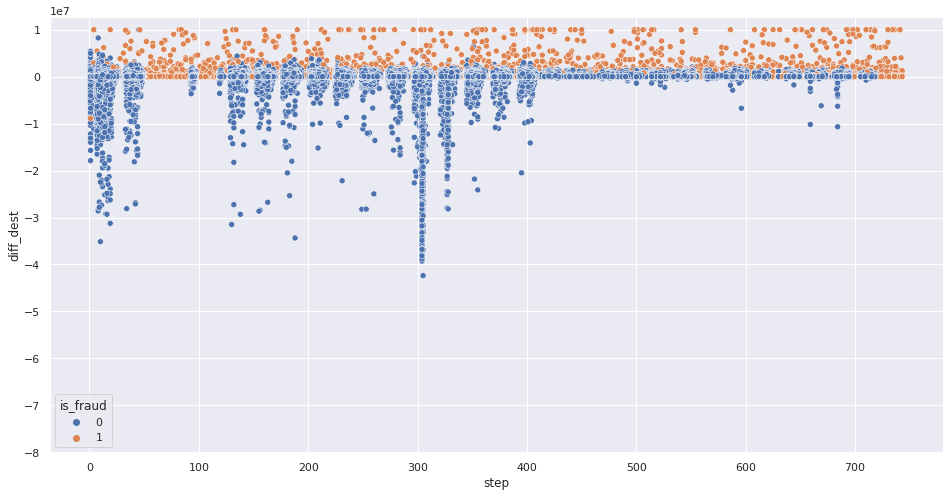

In [29]:
# set up figure size
plt.subplots(figsize=(16,8))
# plot diff_orig scatterplot
sns.scatterplot(x='step', y='diff_dest', hue='is_fraud', data=df4)
# set y-axis labels
plt.yticks(np.arange(-8.e+07, 2.e+07, step=1.e+07));

- diff_dest values labeled as fraudulent ranges from zero to 10 million.

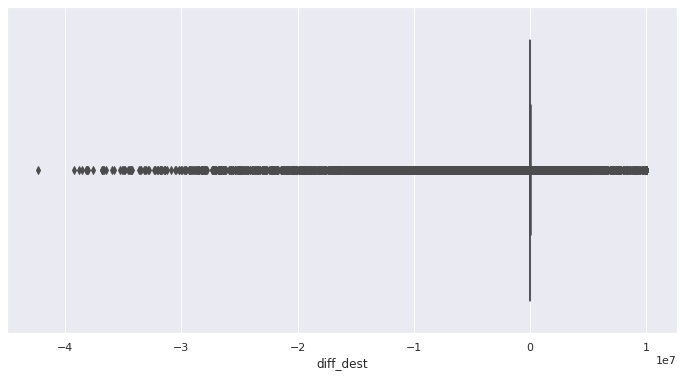

In [30]:
# diff_dest boxplot
plt.subplots(figsize=(12,6))
sns.boxplot(df4['diff_dest']);

In [31]:
df4['diff_dest'].value_counts(normalize=True)

 0.00         2.554649e-01
 0.01         2.176709e-02
-0.01         2.170171e-02
 0.01         8.328889e-03
-0.01         8.325968e-03
                  ...     
 122391.05    2.246740e-07
-149368.95    2.246740e-07
 993633.66    2.246740e-07
 25054.89     2.246740e-07
 453869.74    2.246740e-07
Name: diff_dest, Length: 2327117, dtype: float64

- 25% of diff_dest values are equal to zero.

### 4.1.3. Categorical Variable

In [32]:
# select categorical attributes
cat_attr = df4.select_dtypes(include=['object'])

In [33]:
cat_attr.describe()

type    name_orig    name_dest
count    4450894      4450894      4450894
unique         5      4446363      2034485
top     CASH_OUT  C2098525306  C1590550415
freq     1565048            3           84

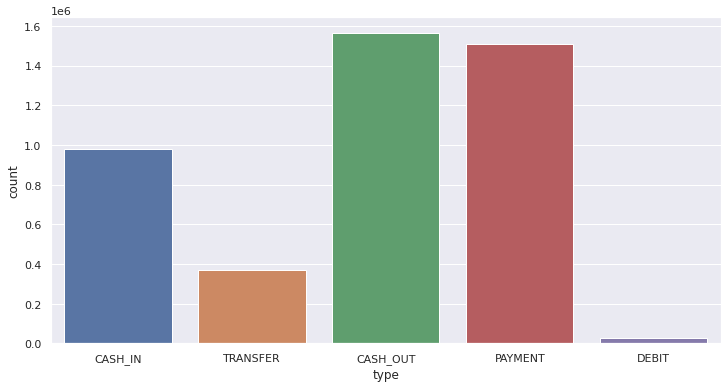

In [34]:
# plot type feature
plt.subplots(figsize=(12,6))
sns.countplot(cat_attr['type']);

In [35]:
cat_attr['type'].value_counts(normalize=True)

CASH_OUT    0.351626
PAYMENT     0.338394
CASH_IN     0.219997
TRANSFER    0.083482
DEBIT       0.006501
Name: type, dtype: float64

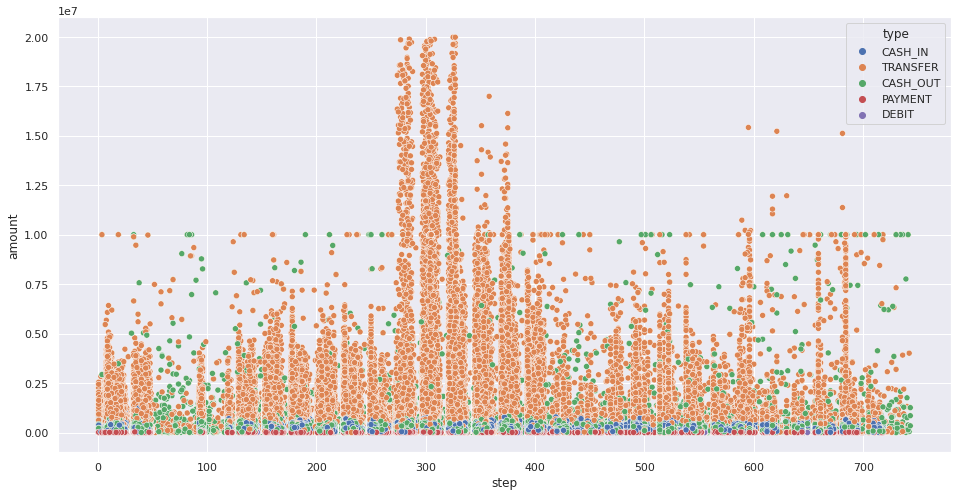

In [36]:
# amount scatterplot with type
plt.subplots(figsize=(16,8))
sns.scatterplot(x='step', y='amount', hue='type', data=df4);

## 4.2. Bivariate Analysis**

### H1. Fraud should occur with high transaction amount.**

**TRUE** Fraud occur with high transaction amount compared to regular one.

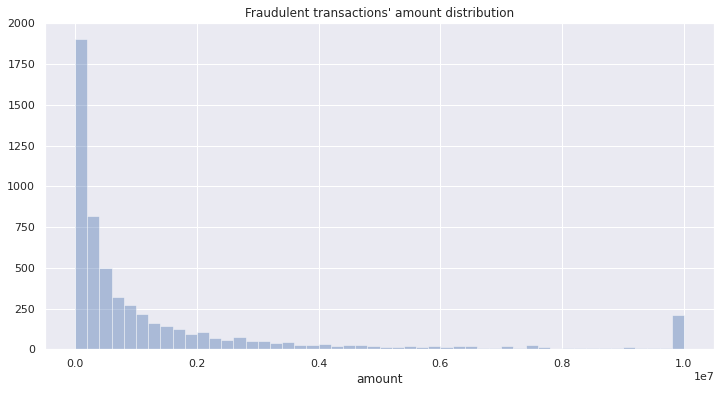

In [37]:
# amount distribution for fraudulent transactions
auxh1 = df4[df4['is_fraud'] == 1]
plt.subplots(figsize=(12,6))
sns.distplot(auxh1['amount'], kde=False).set_title("Fraudulent transactions' amount distribution");

In [38]:
auxh1['amount'].describe()

count    5.747000e+03
mean     1.485216e+06
std      2.409961e+06
min      0.000000e+00
25%      1.273950e+05
50%      4.522617e+05
75%      1.555182e+06
max      1.000000e+07
Name: amount, dtype: float64

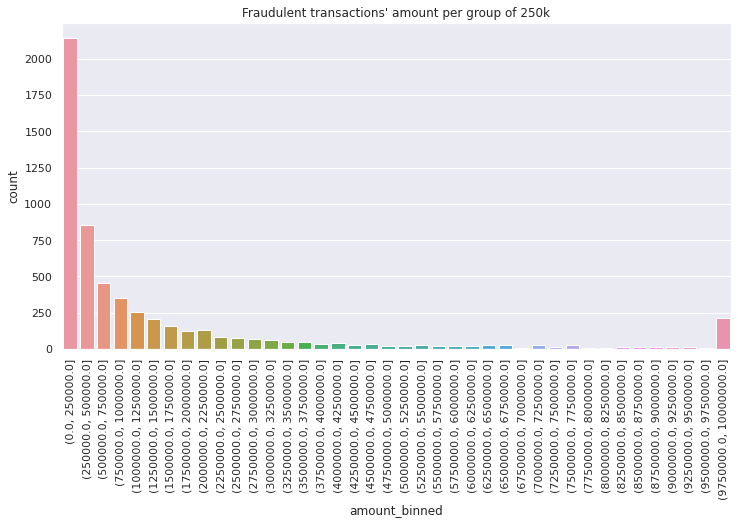

In [39]:
# plot amount binned values of fraudulent transactions
bins1 = list(np.arange(0, 10.1e6, 2.5e5))
auxh1['amount_binned'] = pd.cut(auxh1['amount'], bins=bins1)
plt.subplots(figsize=(12,6))
sns.countplot(x='amount_binned', data=auxh1).set_title("Fraudulent transactions' amount per group of 250k");
# rotate x axis
plt.xticks(rotation=90);

In [40]:
auxh1['amount_binned'].value_counts(normalize=True)

(0.0, 250000.0]            0.373257
(250000.0, 500000.0]       0.149059
(500000.0, 750000.0]       0.078975
(750000.0, 1000000.0]      0.061192
(1000000.0, 1250000.0]     0.043933
(9750000.0, 10000000.0]    0.036611
(1250000.0, 1500000.0]     0.035739
(1500000.0, 1750000.0]     0.027720
(2000000.0, 2250000.0]     0.022490
(1750000.0, 2000000.0]     0.021967
(2250000.0, 2500000.0]     0.014296
(2500000.0, 2750000.0]     0.013424
(2750000.0, 3000000.0]     0.012029
(3000000.0, 3250000.0]     0.010286
(3250000.0, 3500000.0]     0.008717
(3500000.0, 3750000.0]     0.008368
(4000000.0, 4250000.0]     0.006799
(4500000.0, 4750000.0]     0.006450
(3750000.0, 4000000.0]     0.005927
(4250000.0, 4500000.0]     0.005056
(7000000.0, 7250000.0]     0.004358
(7500000.0, 7750000.0]     0.004358
(6250000.0, 6500000.0]     0.004184
(5250000.0, 5500000.0]     0.004184
(6500000.0, 6750000.0]     0.004184
(4750000.0, 5000000.0]     0.004010
(5000000.0, 5250000.0]     0.003661
(5750000.0, 6000000.0]     0

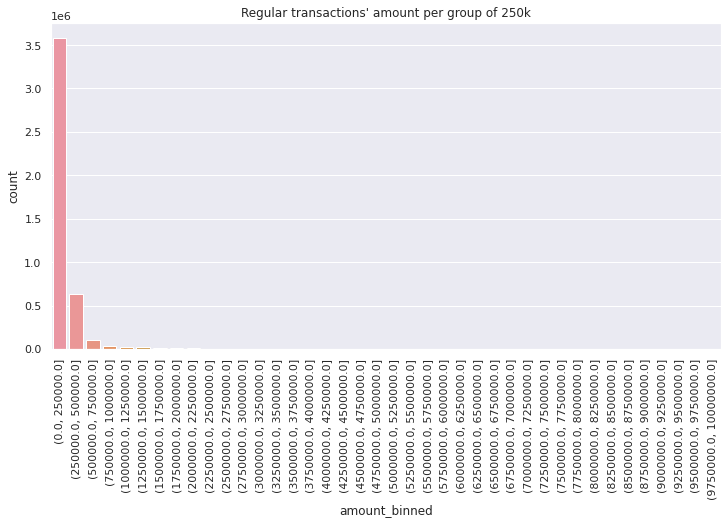

In [41]:
# regular transactions
auxh11 = df4[df4['is_fraud'] == 0]
auxh11['amount_binned'] = pd.cut(auxh11['amount'], bins=bins1)
plt.subplots(figsize=(12,6))
sns.countplot(x='amount_binned', data=auxh11).set_title("Regular transactions' amount per group of 250k");
# rotate x axis
plt.xticks(rotation=90);

In [42]:
auxh11['amount_binned'].value_counts(normalize=True)

(0.0, 250000.0]            0.805105
(250000.0, 500000.0]       0.142476
(500000.0, 750000.0]       0.023992
(750000.0, 1000000.0]      0.008707
(1000000.0, 1250000.0]     0.005460
(1250000.0, 1500000.0]     0.003697
(1500000.0, 1750000.0]     0.002500
(1750000.0, 2000000.0]     0.001743
(2000000.0, 2250000.0]     0.001263
(2250000.0, 2500000.0]     0.000911
(2500000.0, 2750000.0]     0.000685
(2750000.0, 3000000.0]     0.000516
(9750000.0, 10000000.0]    0.000452
(3000000.0, 3250000.0]     0.000397
(3250000.0, 3500000.0]     0.000317
(3500000.0, 3750000.0]     0.000247
(3750000.0, 4000000.0]     0.000198
(4000000.0, 4250000.0]     0.000158
(4250000.0, 4500000.0]     0.000143
(4500000.0, 4750000.0]     0.000116
(4750000.0, 5000000.0]     0.000103
(5250000.0, 5500000.0]     0.000081
(5000000.0, 5250000.0]     0.000081
(5500000.0, 5750000.0]     0.000072
(5750000.0, 6000000.0]     0.000063
(6000000.0, 6250000.0]     0.000054
(6250000.0, 6500000.0]     0.000051
(6500000.0, 6750000.0]     0

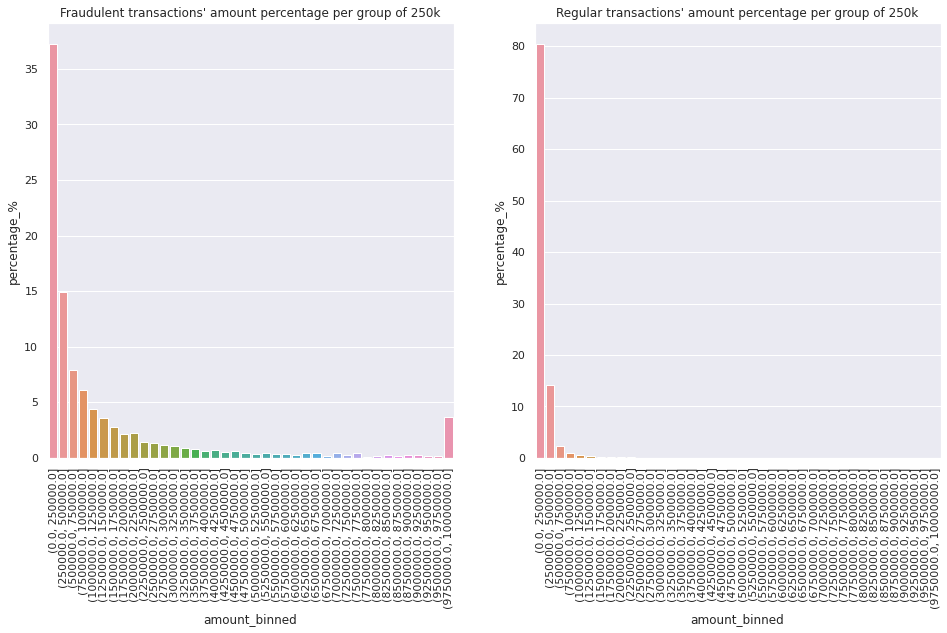

In [43]:
# plot amount_binned percentage of fraudulent transactions
grouped_count = auxh1[['amount_binned', 'amount']].groupby('amount_binned').count().reset_index()
grouped_count['percentage_%'] = np.round(((grouped_count['amount'] / len(auxh1)) * 100), decimals=2)

# set up figure size
plt.subplots(figsize=(16,8))

# 1st plot
plt.subplot(1, 2, 1)
sns.barplot(x='amount_binned', y='percentage_%', data=grouped_count).\
set_title("Fraudulent transactions' amount percentage per group of 250k");

# rotate x axis
plt.xticks(rotation=90);

# plot amount_binned percentage for regular transactions
grouped_count_reg = auxh11[['amount_binned', 'amount']].groupby('amount_binned').count().reset_index()
grouped_count_reg['percentage_%'] = np.round(((grouped_count_reg['amount'] / len(auxh11)) * 100), decimals=2)

# 2nd plot
plt.subplot(1, 2, 2)
sns.barplot(x='amount_binned', y='percentage_%', data=grouped_count_reg).\
set_title("Regular transactions' amount percentage per group of 250k");
# rotate x axis
plt.xticks(rotation=90);

In [44]:
auxh100 = df4[['amount', 'is_fraud']]
auxh100['amount_binned'] = pd.cut(auxh100['amount'], bins=bins1)

auxh101 = auxh100[['amount_binned', 'amount', 'is_fraud']].groupby(['amount_binned', 'is_fraud']).count().reset_index()
auxh101.columns = ['amount_binned', 'is_fraud', 'transactions']

# sum of fraudulent transactions quantity
fraud_trans_sum = auxh101[auxh101['is_fraud'] == 1]['transactions'].sum()

# sum of not fraudulent transactions quantity
not_fraud_trans_sum = auxh101[auxh101['is_fraud'] == 0]['transactions'].sum()

auxh101['relative_percentage'] = auxh101.\
apply(lambda x: (x['transactions'] / fraud_trans_sum) if x['is_fraud'] == 1 else (x['transactions'] / not_fraud_trans_sum), axis=1)

auxh101

amount_binned  is_fraud  transactions  relative_percentage
0           (0.0, 250000.0]         0       3578091             0.805105
1           (0.0, 250000.0]         1          2141             0.373257
2      (250000.0, 500000.0]         0        633201             0.142476
3      (250000.0, 500000.0]         1           855             0.149059
4      (500000.0, 750000.0]         0        106627             0.023992
..                      ...       ...           ...                  ...
75   (9250000.0, 9500000.0]         1            12             0.002092
76   (9500000.0, 9750000.0]         0           100             0.000023
77   (9500000.0, 9750000.0]         1             9             0.001569
78  (9750000.0, 10000000.0]         0          2007             0.000452
79  (9750000.0, 10000000.0]         1           210             0.036611

[80 rows x 4 columns]

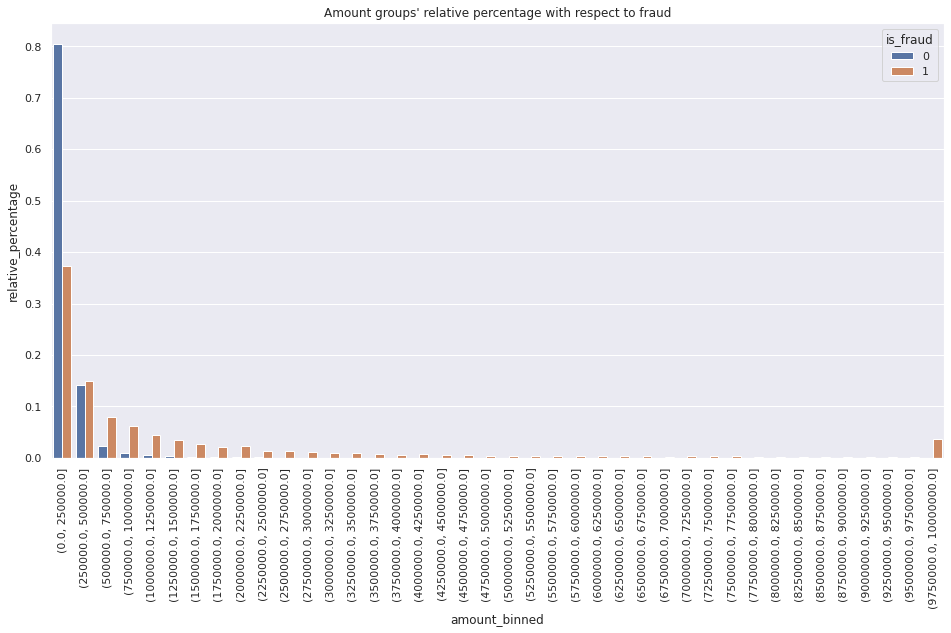

In [45]:
# plot amount_binned relative percentage with respect to is_fraud
plt.subplots(figsize=(16,8))
sns.barplot(x='amount_binned', y='relative_percentage', hue='is_fraud', data=auxh101).\
set_title("Amount groups' relative percentage with respect to fraud");
plt.xticks(rotation=90);

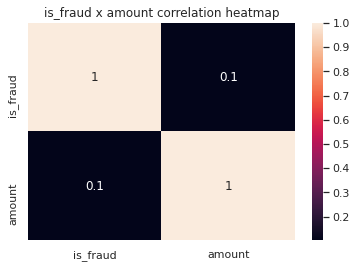

In [46]:
# point-biserial correlation coefficient heatmap function. For details, please see section 0.1. Helper Functions.
point_bi_corr(df4[['is_fraud']], df4[['amount']]);

- The barplot shows that more than 80% of regular transactions were made with an amount ranging from 0 to 250,000. For fraudulent transactions, this amount range represents only 37% of the transactions.
- Furthermore, 97% of regular transactions were made with an amount up to 750,000. For fraudulent transactions, this range represents 60%.
- Finally, 3,66% of fraudulent transactions were made with an amount from 9,75 million to 10 million.
- Therefore, the hypothesis is true.

### H2. Fraud should occur with cash out transaction type.**

**TRUE** Fraud occur with cash out and transfer transaction type.

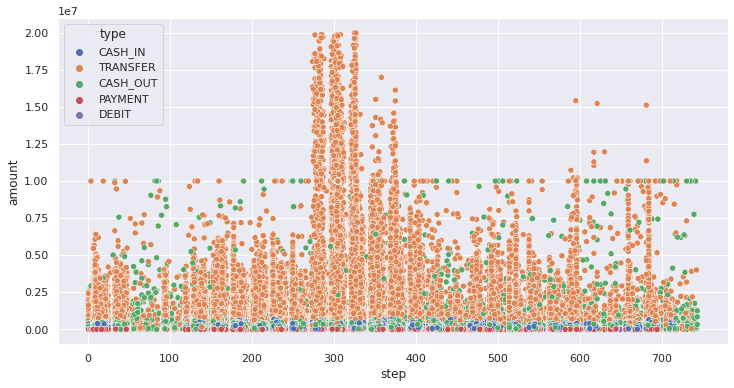

In [47]:
# type feature scatter plot
plt.subplots(figsize=(12,6))
sns.scatterplot(x='step', y='amount', hue='type', data=df4);

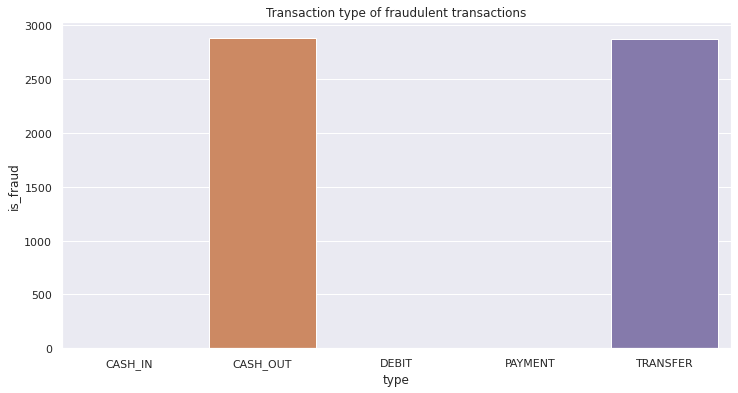

In [48]:
# plot transaction type of fraudulent transactions
auxh2 = df4[['type', 'is_fraud']].groupby('type').sum().reset_index()
plt.subplots(figsize=(12,6))
sns.barplot(x='type', y='is_fraud', data=auxh2).set_title('Transaction type of fraudulent transactions');

In [49]:
auxh2['percentage'] = np.round(((auxh2['is_fraud'] / auxh2['is_fraud'].sum()) * 100), decimals=2)
auxh2

type  is_fraud  percentage
0   CASH_IN         0        0.00
1  CASH_OUT      2880       50.11
2     DEBIT         0        0.00
3   PAYMENT         0        0.00
4  TRANSFER      2867       49.89

In [50]:
auxh22 = df4[['type', 'amount', 'is_fraud']].groupby(['type', 'is_fraud']).count().reset_index()
auxh22.columns = ['type', 'is_fraud', 'transactions']

# sum of fraudulent transactions quantity
fraud_trans_sum = auxh22[auxh22['is_fraud'] == 1]['transactions'].sum()

# sum of not fraudulent transactions quantity
not_fraud_trans_sum = auxh22[auxh22['is_fraud'] == 0]['transactions'].sum()

auxh22['relative_percentage'] = auxh22.\
apply(lambda x: (x['transactions'] / fraud_trans_sum) if x['is_fraud'] == 1 else (x['transactions'] / not_fraud_trans_sum), axis=1)

auxh22

type  is_fraud  transactions  relative_percentage
0   CASH_IN         0        979184             0.220282
1  CASH_OUT         0       1562168             0.351432
2  CASH_OUT         1          2880             0.501131
3     DEBIT         0         28936             0.006510
4   PAYMENT         0       1506155             0.338831
5  TRANSFER         0        368704             0.082945
6  TRANSFER         1          2867             0.498869

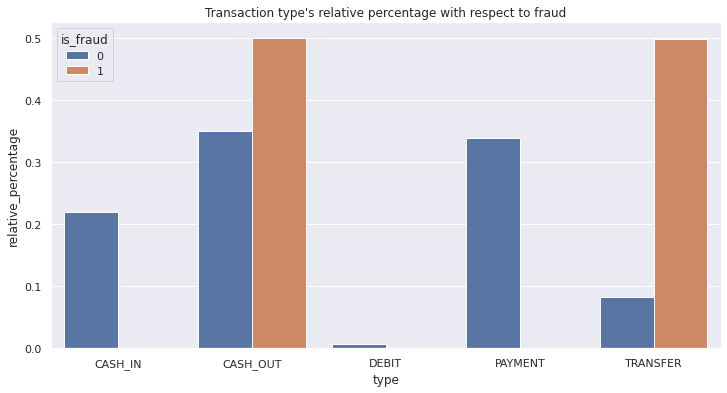

In [51]:
# plot type relative percentage with respect to is_fraud
plt.subplots(figsize=(12,6))
sns.barplot(x='type', y='relative_percentage', hue='is_fraud', data=auxh22).\
set_title("Transaction type's relative percentage with respect to fraud");

- Only Cash out and Transfer transaction types have fraud;
- 50.11% of fraudulent transactions were made with cash out transaction type. For regular transactions, the cash out type was used 35%.
- 49.89% of fraudulent transactions were made with transfer transaction type. That's significantly higher than the 8% transfer ratio used on regular transactions.
- Therefore, the hypothesis is true: fraudulent transactions occur with cash out and transfer transaction type.

### H3. Fraud should not occur when the origin balance before the transaction is equal to zero.

**TRUE** Fraud does not occur when the origin balance before the transaction is equal to zero.

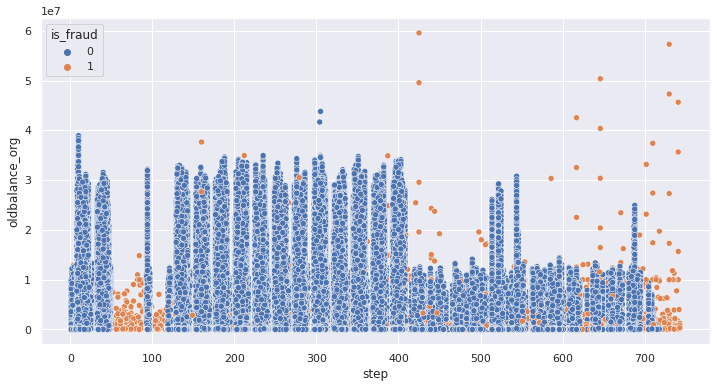

In [52]:
# origin balance scatterplot
plt.subplots(figsize=(12,6))
sns.scatterplot(x='step', y='oldbalance_org', hue='is_fraud', data=df4);

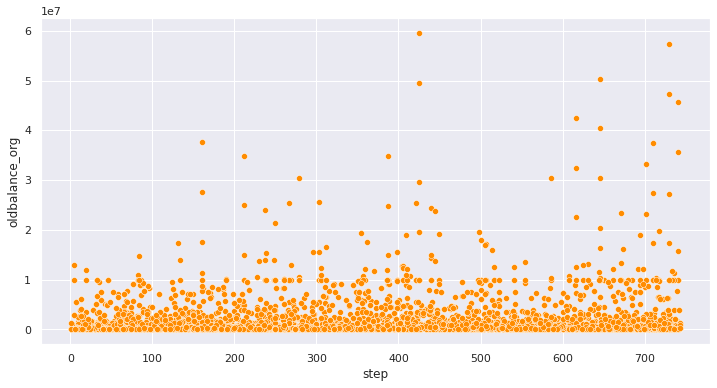

In [53]:
# scatterplot of fraudulent transactions
auxh3 = df4[df4['is_fraud'] == 1]
plt.subplots(figsize=(12,6))
sns.scatterplot(x='step', y='oldbalance_org', data=auxh3, color='darkorange');

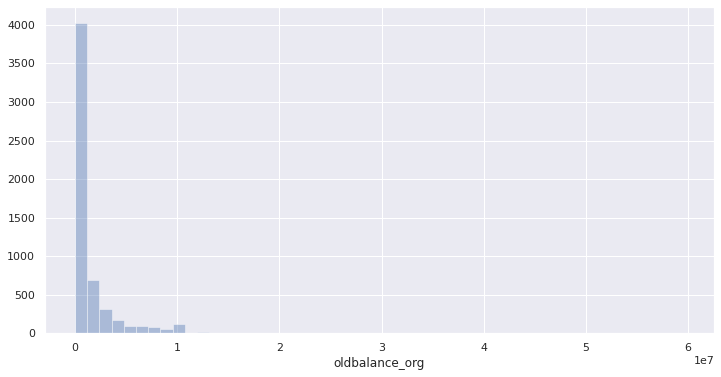

In [54]:
# oldbalance_org fraud distribution
plt.subplots(figsize=(12,6))
sns.distplot(auxh3['oldbalance_org'], kde=False);

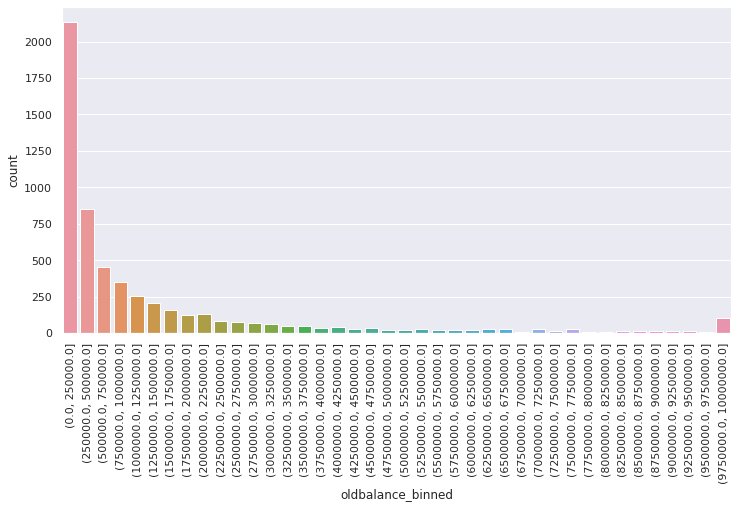

In [55]:
# plot oldbalance_org binned values
# Keep only values below 10 million
auxh31 = auxh3[auxh3['oldbalance_org'] <= 1e7]

# set binned values
bins1 = list(np.arange(0, 10.1e6, 2.5e5))
auxh31['oldbalance_binned'] = pd.cut(auxh31['oldbalance_org'], bins=bins1)

# countplot
plt.subplots(figsize=(12,6))
sns.countplot(auxh31['oldbalance_binned']);
plt.xticks(rotation=90);

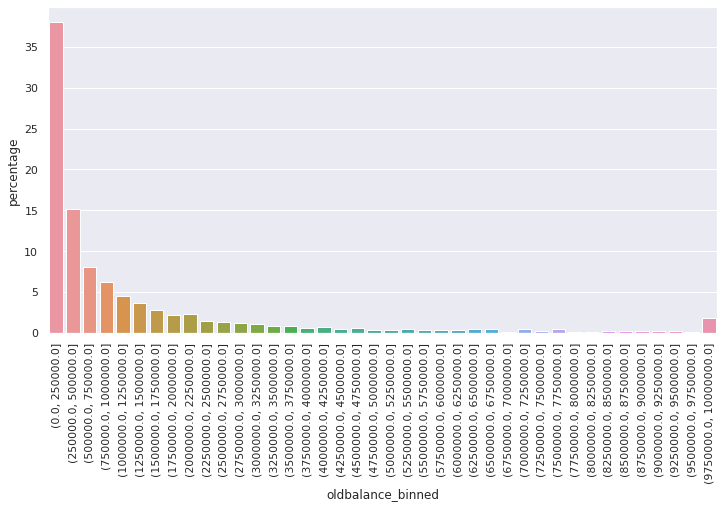

In [56]:
# oldbalance_org fraud transaction percentage
auxh32 = auxh31[['oldbalance_binned', 'amount']].groupby('oldbalance_binned').count().reset_index()
auxh32.columns = ['oldbalance_binned', 'transactions']
auxh32['percentage'] = np.round(((auxh32['transactions'] / auxh32['transactions'].sum()) * 100), decimals=2)
plt.subplots(figsize=(12,6))
sns.barplot(x='oldbalance_binned', y='percentage', data=auxh32);
plt.xticks(rotation=90);

In [57]:
auxh32

oldbalance_binned  transactions  percentage
0           (0.0, 250000.0]          2132       38.00
1      (250000.0, 500000.0]           850       15.15
2      (500000.0, 750000.0]           451        8.04
3     (750000.0, 1000000.0]           350        6.24
4    (1000000.0, 1250000.0]           252        4.49
5    (1250000.0, 1500000.0]           205        3.65
6    (1500000.0, 1750000.0]           159        2.83
7    (1750000.0, 2000000.0]           125        2.23
8    (2000000.0, 2250000.0]           129        2.30
9    (2250000.0, 2500000.0]            82        1.46
10   (2500000.0, 2750000.0]            77        1.37
11   (2750000.0, 3000000.0]            69        1.23
12   (3000000.0, 3250000.0]            59        1.05
13   (3250000.0, 3500000.0]            50        0.89
14   (3500000.0, 3750000.0]            48        0.86
15   (3750000.0, 4000000.0]            34        0.61
16   (4000000.0, 4250000.0]            39        0.70
17   (4250000.0, 4500000.0]            29        0.52
18   (4500000.0, 4750000.0]            37        0.66
19   (4750000.0, 5000000.0]            23        0.41
20   (5000000.0, 5250000.0]            21        0.37
21   (5250000.0, 5500000.0]            24        0.43
22   (5500000.0, 5750000.0]            18        0.32
23   (5750000.0, 6000000.0]            19        0.34
24   (6000000.0, 6250000.0]            17        0.30
25   (6250000.0, 6500000.0]            24        0.43
26   (6500000.0, 6750000.0]            24        0.43
27   (6750000.0, 7000000.0]             8        0.14
28   (7000000.0, 7250000.0]            25        0.45
29   (7250000.0, 7500000.0]            15        0.27
30   (7500000.0, 7750000.0]            25        0.45
31   (7750000.0, 8000000.0]             6        0.11
32   (8000000.0, 8250000.0]             9        0.16
33   (8250000.0, 8500000.0]            13        0.23
34   (8500000.0, 8750000.0]            11        0.20
35   (8750000.0, 9000000.0]            13        0.23
36   (9000000.0, 9250000.0]            14        0.25
37   (9250000.0, 9500000.0]            12        0.21
38   (9500000.0, 9750000.0]             8        0.14
39  (9750000.0, 10000000.0]           104        1.85

In [58]:
auxh3['oldbalance_org'].value_counts()

10000000.00    96
0.00           28
429257.45       4
1165187.89      3
103909.10       2
               ..
649968.87       1
12542664.27     1
12930418.44     1
219300.76       1
164.00          1
Name: oldbalance_org, Length: 3683, dtype: int64

In [59]:
auxh3['oldbalance_org'].value_counts(normalize=True)

10000000.00    0.016704
0.00           0.004872
429257.45      0.000696
1165187.89     0.000522
103909.10      0.000348
                 ...   
649968.87      0.000174
12542664.27    0.000174
12930418.44    0.000174
219300.76      0.000174
164.00         0.000174
Name: oldbalance_org, Length: 3683, dtype: float64

In [60]:
df4['oldbalance_org'].value_counts()

0.00          1469321
181.00            651
128.00            649
162.00            645
109.00            643
               ...   
1134.36             1
2140800.52          1
58652.28            1
2140894.27          1
9688153.26          1
Name: oldbalance_org, Length: 1346677, dtype: int64

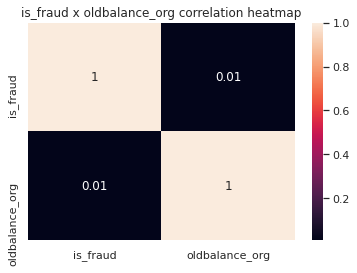

In [62]:
# point-biserial correlation coefficient heatmap function. For details, please see section 0.1. Helper Functions.
point_bi_corr(df4[['is_fraud']], df4[['oldbalance_org']]);

- 38% of the fraudulent transactions have origin balance between zero up to 250,000.
- 67% of the fraudulent transactions have origin balance between zero up to 1 million.
- 28 fraudulent transactions have origin balance equal to zero. That represents only 0.49% of total fraudulent transactions.
- Aproximately 1,4 million regular transactions have origin balance equal zero. The fraudulent transactions with origin balance equal zero (28) represents only 0,002% of the total transactions with origin balance equal zero (1,469,321).
- Therefore, the hypothesis is True: fraud does not occur when the origin balance before the transaction is equal to zero.

### H4. Fraud should occur when origin balance after the transaction is equal to zero.**

**TRUE** Fraud occur when origin balance after the transaction is equal to zero.

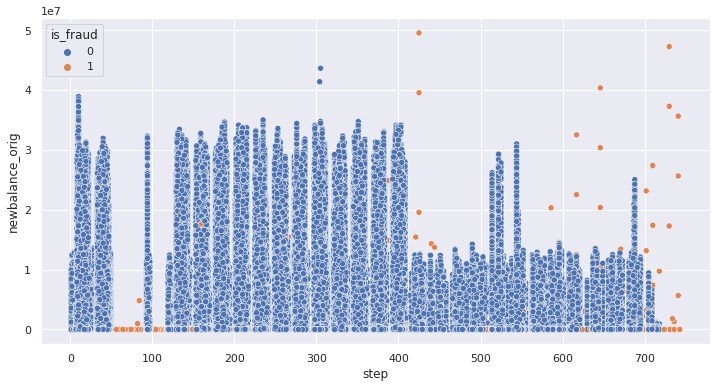

In [63]:
# newbalance_orig scatterplot
plt.subplots(figsize=(12,6))
sns.scatterplot(x='step', y='newbalance_orig', hue='is_fraud', data=df4);

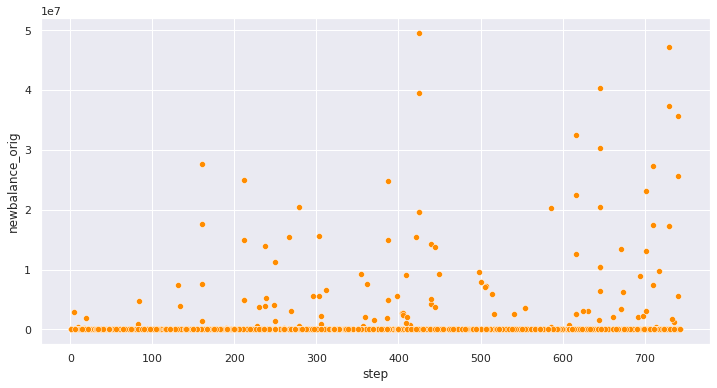

In [64]:
# newbalance_orig fraudulent transactions scatterplot
auxh4 = df4[df4['is_fraud'] == 1]
plt.subplots(figsize=(12,6))
sns.scatterplot(x='step', y='newbalance_orig', data=auxh4, color='darkorange');

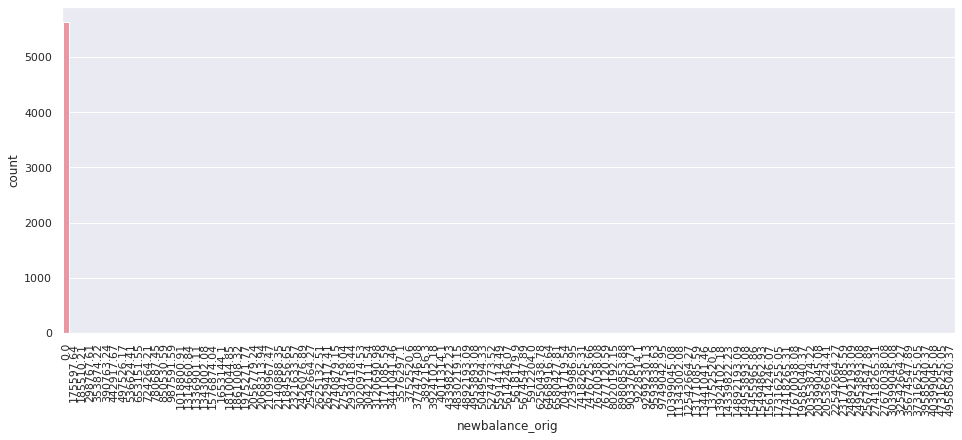

In [71]:
plt.subplots(figsize=(16,6))
sns.countplot(auxh4['newbalance_orig']);
plt.xticks(rotation=90);

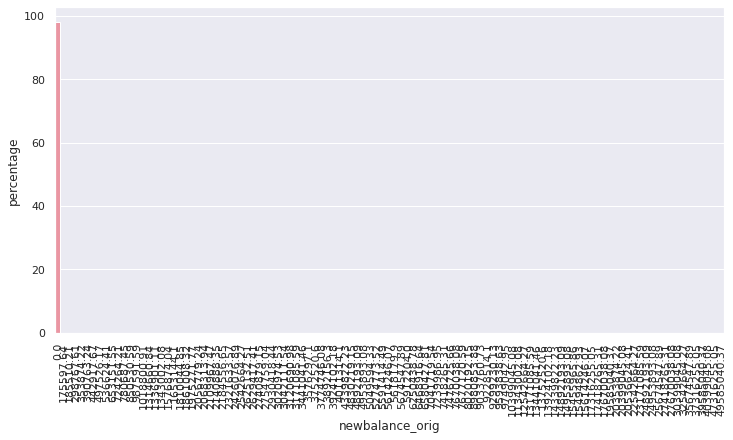

In [66]:
auxh41 = pd.DataFrame(auxh4['newbalance_orig'].value_counts(normalize=True)).reset_index()
auxh41['newbalance_orig'] = np.round((auxh41['newbalance_orig']*100), decimals=2)
auxh41.columns = ['newbalance_orig', 'percentage']
plt.subplots(figsize=(12,6))
sns.barplot(x='newbalance_orig', y='percentage', data=auxh41);
plt.xticks(rotation=90);

In [67]:
auxh41

newbalance_orig  percentage
0               0.00       97.91
1        19585040.37        0.05
2        10399045.08        0.05
3          353874.22        0.03
4         2542664.27        0.03
..               ...         ...
104       3752520.60        0.02
105      15614246.07        0.02
106      17418265.31        0.02
107       1653144.10        0.02
108       2140888.35        0.02

[109 rows x 2 columns]

In [68]:
# check newbalance_orig regular transactions
auxh42 = df4[df4['is_fraud'] == 0]
auxh43 = pd.DataFrame(auxh42['newbalance_orig'].value_counts(normalize=True)).reset_index()
auxh43.columns = ['newbalance_orig', 'percentage']
auxh43['percentage'] = np.round((auxh43['percentage'] * 100), decimals=4)
auxh43['transactions'] = pd.DataFrame(auxh42['newbalance_orig'].value_counts()).reset_index()['newbalance_orig']
auxh43

newbalance_orig  percentage  transactions
0                   0.00     56.6551       2518402
1                6891.47      0.0001             4
2                 137.53      0.0001             4
3               11493.54      0.0001             4
4                3420.22      0.0001             4
...                  ...         ...           ...
1891589        136308.05      0.0000             1
1891590        301066.62      0.0000             1
1891591        136073.70      0.0000             1
1891592        301064.12      0.0000             1
1891593         18647.09      0.0000             1

[1891594 rows x 3 columns]

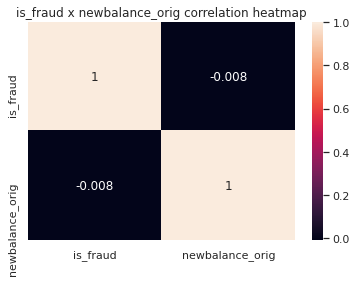

In [69]:
# point-biserial correlation coefficient heatmap function. For details, please see section 0.1. Helper Functions.
point_bi_corr(df4[['is_fraud']], df4[['newbalance_orig']]);

- 97.91% of fraudulent transactions have origin balance after transaction equal to zero.
- 56.7% of regular transactions have origin balance after transaction equal to zero. That represents 2,518,402 transactions.
- Based on the fraudulent transactions pattern, the hypothesis is true: Fraud occur when origin balance after the transaction is equal to zero.

### H5. Fraud should occur when the origin balance difference before and after the transaction is different from the transaction amount.**

**FALSE** Fraud occur when the origin balance difference before and after the transaction is equal to the transaction amount.

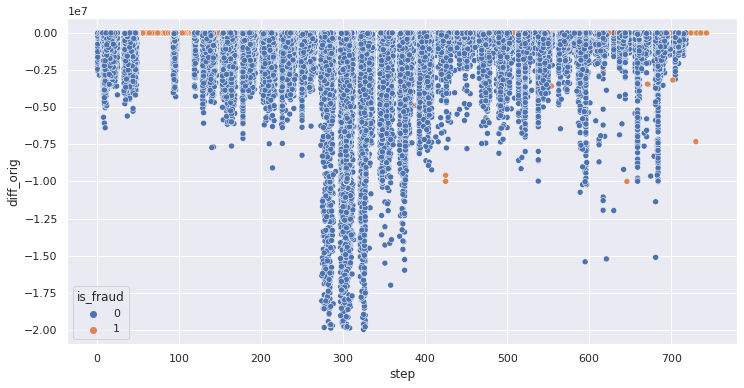

In [72]:
# diff_orig scatterplot
plt.subplots(figsize=(12,6))
sns.scatterplot(x='step', y='diff_orig', hue='is_fraud', data=df4);

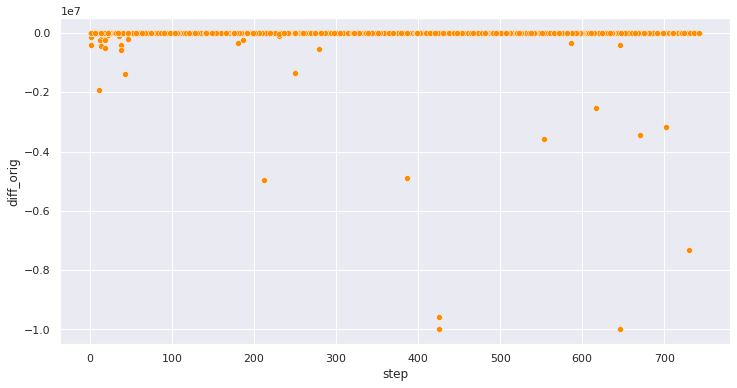

In [73]:
# diff_orig scatterplot for fraudulent transactions
auxh5 = df4[df4['is_fraud'] == 1]
plt.subplots(figsize=(12,6))
sns.scatterplot(x='step', y='diff_orig', data=auxh5, color='darkorange');

In [74]:
auxh51 = pd.DataFrame(auxh5['diff_orig'].value_counts(normalize=True)).reset_index()
auxh51.columns = ['diff_orig', 'percentage']
auxh51['percentage'] = np.round((auxh51['percentage'] * 100), decimals=2)
auxh51

diff_orig  percentage
0   0.000000e+00       98.36
1  -4.656613e-10        0.21
2  -1.862645e-09        0.14
3  -9.313226e-10        0.12
4   4.656613e-10        0.10
5   9.313226e-10        0.10
6   3.725290e-09        0.05
7   2.328306e-10        0.05
8  -6.984919e-10        0.03
9   6.984919e-10        0.03
10  1.862645e-09        0.03
11 -1.164153e-10        0.03
12  1.164153e-10        0.03
13 -1.000000e+07        0.03
14 -9.437261e+04        0.02
15 -1.933921e+06        0.02
16 -2.382951e+05        0.02
17 -3.538742e+05        0.02
18 -1.395851e+06        0.02
19 -5.087822e+05        0.02
20 -5.774190e+05        0.02
21 -3.576297e+06        0.02
22 -4.070058e+05        0.02
23 -5.820766e-11        0.02
24 -4.061122e+04        0.02
25 -2.328306e-10        0.02
26 -4.953893e+06        0.02
27 -4.892193e+06        0.02
28  1.746230e-10        0.02
29 -3.971328e+04        0.02
30 -3.327295e+05        0.02
31 -1.283436e+05        0.02
32 -9.585040e+06        0.02
33 -2.299096e+05        0.02
34 -3.171086e+06        0.02
35  9.022187e-10        0.02
36 -1.122809e+05        0.02
37 -7.316255e+06        0.02
38 -4.160013e+05        0.02
39 -1.221016e+05        0.02
40 -5.366244e+05        0.02
41 -8.506586e+04        0.02
42 -3.441041e+06        0.02
43  5.820766e-10        0.02
44 -1.343002e+06        0.02
45 -9.542832e+04        0.02
46 -2.029786e+05        0.02
47 -3.990451e+05        0.02
48 -4.548594e+05        0.02
49 -2.542664e+06        0.02
50 -2.220487e+05        0.02

In [75]:
auxh52 = df4[df4['is_fraud'] == 0]
auxh53 = pd.DataFrame(auxh52['diff_orig'].value_counts(normalize=True)).reset_index()
auxh53.columns = ['diff_orig', 'percentage']
auxh53['percentage'] = np.round((auxh53['percentage'] * 100), decimals=4)
auxh53

diff_orig  percentage
0        0.000000e+00     14.8109
1       -1.000000e-02      0.3977
2        1.000000e-02      0.3951
3       -3.637979e-12      0.2866
4        7.275958e-12      0.2859
...               ...         ...
3343679 -1.959060e+03      0.0000
3343680 -1.967060e+03      0.0000
3343681 -1.187158e+05      0.0000
3343682 -1.219554e+04      0.0000
3343683 -2.542981e+05      0.0000

[3343684 rows x 2 columns]

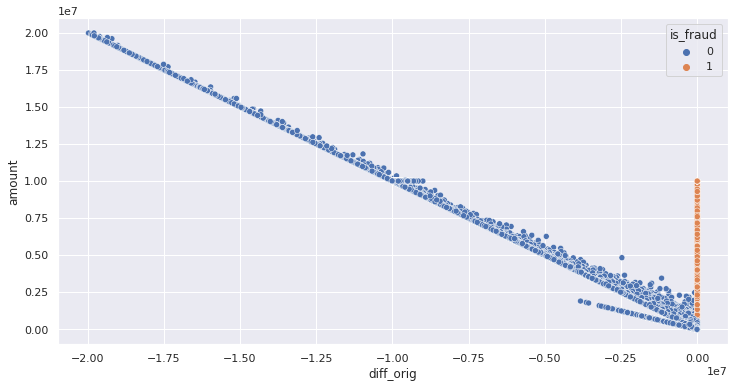

In [76]:
# diff_orig x amount scatterplot
plt.subplots(figsize=(12,6))
sns.scatterplot(x='diff_orig', y='amount', hue='is_fraud', data=df4);

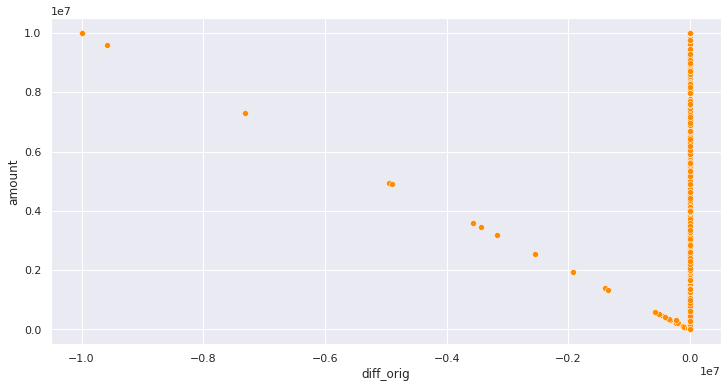

In [77]:
# diff_orig x amount scatterplot, fraudulent transactions
plt.subplots(figsize=(12,6))
sns.scatterplot(x='diff_orig', y='amount', color='darkorange', data=auxh5);

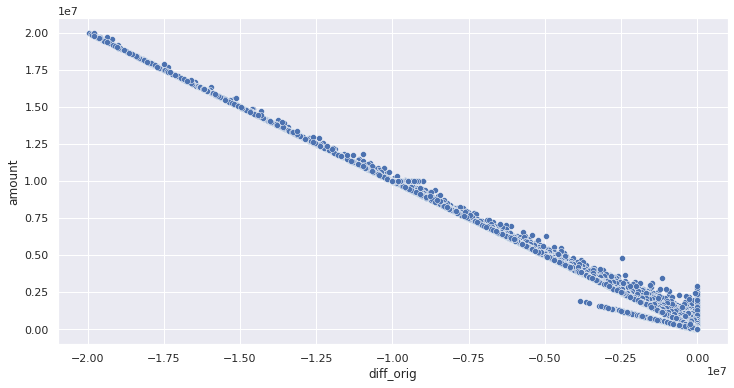

In [78]:
# diff_orig x amount scatterplot, regular transactions
plt.subplots(figsize=(12,6))
sns.scatterplot(x='diff_orig', y='amount', data=auxh52);

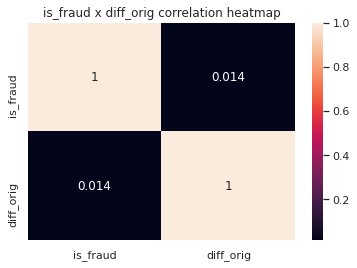

In [79]:
# point-biserial correlation coefficient heatmap function. For details, please see section 0.1. Helper Functions.
point_bi_corr(df4[['is_fraud']], df4[['diff_orig']]);

- diff_orig = balance before transaction - amount - balance after transaction.
- diff_orig equal to zero means that the difference of origin balance before and after the transaction is equal to the amount of the transaction.
- A negative value of diff_orig means that the transaction amount is not properly taken into account in the origin balance.
- 98.36% of fraudulent transactions have diff_orig value equal to zero.
- Only 14.8% of regular transactions have diff_orig equal to zero.
- In the diff_orig x amount scatterplot it is clear the difference between fraud and not fraud: the fraudulent transactions stay in the diff_orig zero axis for almost every amount value (more precisely 98.36%). On the other hand, the regular transactions have a linear pattern with a 45° slope, which means when both diff_orig and amount have the same value, the transaction is not fraudulent.
- Therefore, the hypothesis is False: Fraud occur when the origin balance difference before and after the transaction is equal to the transaction amount.

### H6. Fraud should occur when the recipient balance after the transaction is equal to zero in more than 70% of the fraudulent transactions.

**FALSE** Fraud occur when the recipient balance after the transaction is equal to zero in less than 70% of the fraudulent transactions.

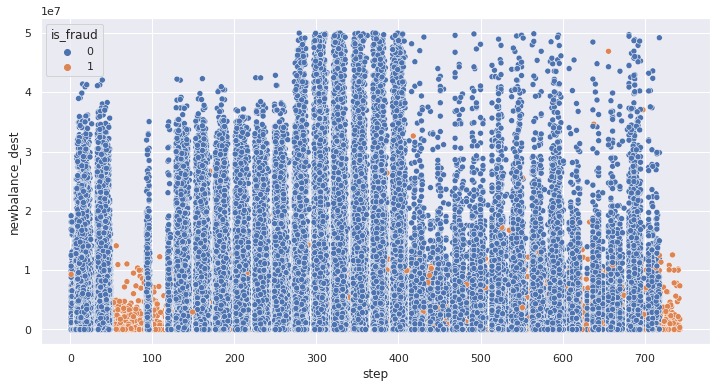

In [7]:
# newbalance_dest scatterplot
plt.subplots(figsize=(12,6))
sns.scatterplot(x='step', y='newbalance_dest', hue='is_fraud', data=df4);

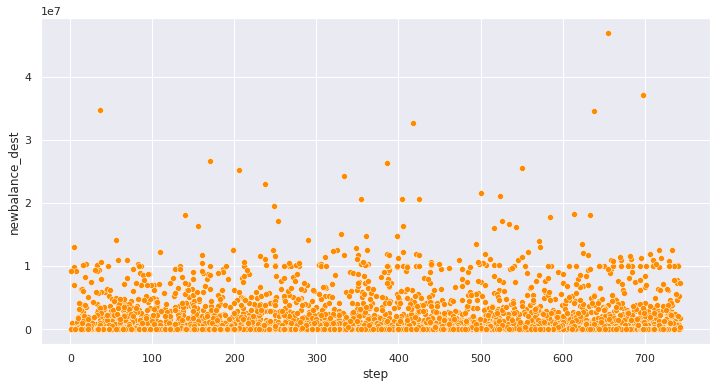

In [8]:
# newbalance_dest fraudulent transactions scatterplot
plt.subplots(figsize=(12,6))
auxh6 = df4[df4['is_fraud'] == 1]
sns.scatterplot(x='step', y='newbalance_dest', data=auxh6, color='darkorange');

In [9]:
auxh6['newbalance_dest'].value_counts()

0.00           2869
10000000.00      35
429257.45         2
1064995.85        2
1165187.89        2
               ... 
2107997.33        1
2972825.85        1
1676719.97        1
2941758.22        1
16318738.25       1
Name: newbalance_dest, Length: 2842, dtype: int64

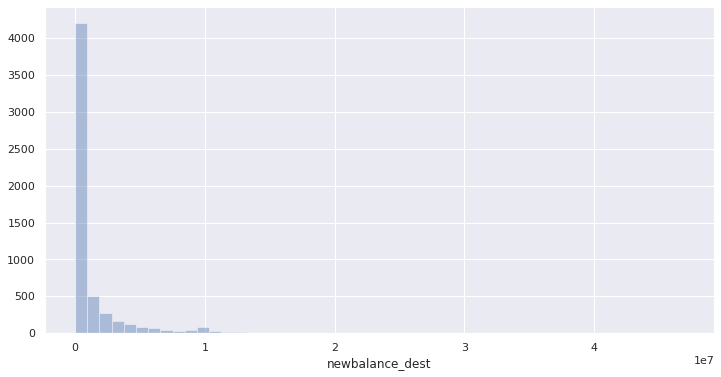

In [10]:
# newbalance_dest fraud distribution
plt.subplots(figsize=(12,6))
sns.distplot(auxh6['newbalance_dest'], kde=False);

In [11]:
# newbalance_dest fraud percentage
auxh61 = pd.DataFrame(auxh6['newbalance_dest'].value_counts(normalize=True)).reset_index()
auxh61.columns = ['newbalance_dest', 'percentage']
auxh61['percentage'] = np.round((auxh61['percentage'] * 100), decimals=2)
auxh61['transactions'] = pd.DataFrame(auxh6['newbalance_dest'].value_counts()).reset_index()['newbalance_dest']
auxh61

newbalance_dest  percentage  transactions
0                0.00       49.92          2869
1         10000000.00        0.61            35
2           429257.45        0.03             2
3          1064995.85        0.03             2
4          1165187.89        0.03             2
...               ...         ...           ...
2837       2107997.33        0.02             1
2838       2972825.85        0.02             1
2839       1676719.97        0.02             1
2840       2941758.22        0.02             1
2841      16318738.25        0.02             1

[2842 rows x 3 columns]

In [12]:
auxh62 = df4[df4['is_fraud'] == 0]
auxh63 = pd.DataFrame(auxh62['newbalance_dest'].value_counts(normalize=True)).reset_index()
auxh63.columns = ['newbalance_dest', 'percentage']
auxh63['percentage'] = np.round((auxh63['percentage'] * 100), decimals=4)
auxh63['transactions'] = pd.DataFrame(auxh62['newbalance_dest'].value_counts()).reset_index()['newbalance_dest']
auxh63

newbalance_dest  percentage  transactions
0                   0.00     38.3526       1704831
1            19169204.93      0.0005            24
2              971418.91      0.0005            23
3            16532032.16      0.0005            21
4             1254956.07      0.0004            18
...                  ...         ...           ...
2546925        458030.87      0.0000             1
2546926       8882183.47      0.0000             1
2546927      33241252.91      0.0000             1
2546928       8877637.53      0.0000             1
2546929        113885.52      0.0000             1

[2546930 rows x 3 columns]

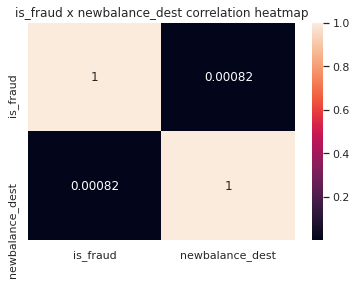

In [13]:
# point-biserial correlation coefficient heatmap function. For details, please see section 0.1. Helper Functions.
point_bi_corr(df4[['is_fraud']], df4[['newbalance_dest']]);

- 49.92% of fraudulent transactions have the recipient balance after transaction equal to zero. That represents 2869 transactions.
- 38.35% of regular transactions have the recipient balance after transaction equal to zero. That represents 1,704,831 transactions.
- As the fraudulent transactions also happens for recipient balance after the transaction greater than zero for more than half of the cases, the hypothesis is false: Fraud occur when the recipient balance after the transaction is equal to zero in less than 70% of the fraudulent transactions.

### H7. Fraud should occur when the recipient balance difference before and after the transaction is different from the transaction amount.**

**TRUE** Fraud occur when the recipient balance difference before and after the transaction is different from the transaction amount.

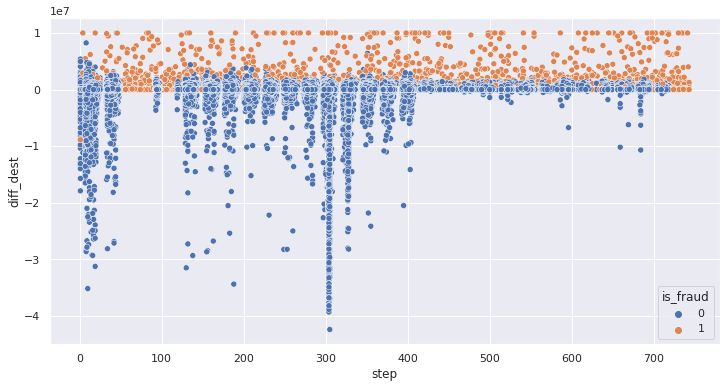

In [14]:
# diff_dest scatter plot
plt.subplots(figsize=(12,6))
sns.scatterplot(x='step', y='diff_dest', hue='is_fraud', data=df4);

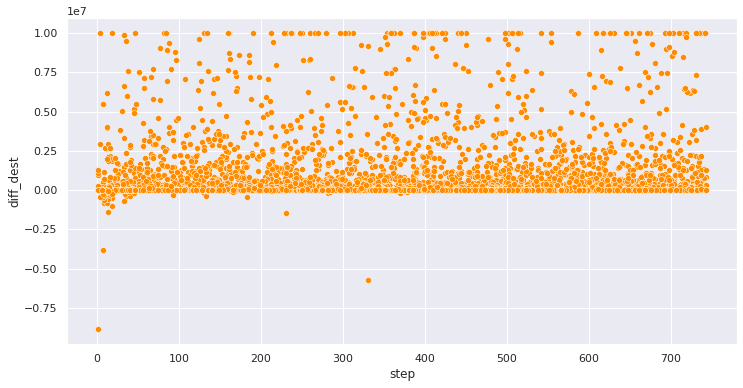

In [15]:
# diff_dest of fraudulent transactions scatterplot
auxh7 = df4[df4['is_fraud'] == 1]
plt.subplots(figsize=(12,6))
sns.scatterplot(x='step', y='diff_dest', data=auxh7, color='darkorange');

In [16]:
# diff_dest transactions and percentage, fraudulent transactions
auxh72 = pd.DataFrame(auxh7['diff_dest'].value_counts()).reset_index()
auxh72.columns = ['diff_dest', 'transactions']
auxh72['percentage'] = pd.DataFrame(auxh7['diff_dest'].value_counts(normalize=True)).reset_index()['diff_dest']
auxh72['percentage'] = np.round((auxh72['percentage'] * 100), decimals=2)
auxh72.head(10)

diff_dest  transactions  percentage
0  0.000000e+00          2034       35.39
1  1.000000e+07           106        1.84
2 -1.000000e-02            99        1.72
3  1.000000e-02            92        1.60
4  1.000000e-02            68        1.18
5 -1.000000e-02            55        0.96
6  4.656613e-10            39        0.68
7  1.164153e-10            30        0.52
8 -4.656613e-10            29        0.50
9 -9.313226e-10            29        0.50

In [17]:
# diff_dest transactions and percentage, regular transactions
auxh73 = df4[df4['is_fraud'] == 0]
auxh74 = pd.DataFrame(auxh73['diff_dest'].value_counts()).reset_index()
auxh74.columns = ['diff_test', 'transactions']
auxh74['percentage'] = pd.DataFrame(auxh73['diff_dest'].value_counts(normalize=True)).reset_index()['diff_dest']
auxh74['percentage'] = np.round((auxh74['percentage'] * 100), decimals=4)
auxh74.head(10)

diff_test  transactions  percentage
0  0.000000e+00       1135013     25.5338
1  1.000000e-02         96791      2.1775
2 -1.000000e-02         96493      2.1707
3  1.000000e-02         37003      0.8324
4 -1.000000e-02         37003      0.8324
5  1.164153e-10         27783      0.6250
6 -1.164153e-10         27535      0.6194
7 -2.328306e-10         25984      0.5845
8  2.328306e-10         25868      0.5819
9  5.820766e-11         22265      0.5009

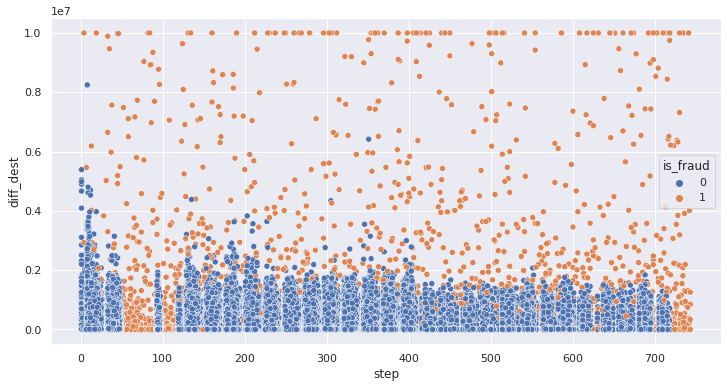

In [18]:
# diff_dest scatterplot, only positive values
auxh75 = df4[df4['diff_dest'] >= 0]
plt.subplots(figsize=(12,6))
sns.scatterplot(x='step', y='diff_dest', hue='is_fraud', data=auxh75);

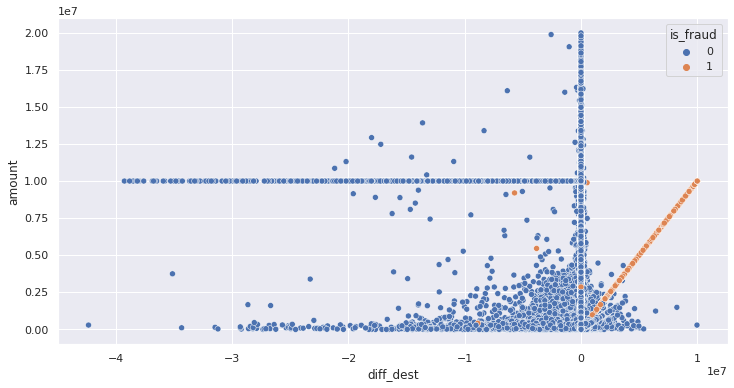

In [19]:
# diff_dest x amount scatterplot
plt.subplots(figsize=(12,6))
sns.scatterplot(x='diff_dest', y='amount', hue='is_fraud', data=df4);

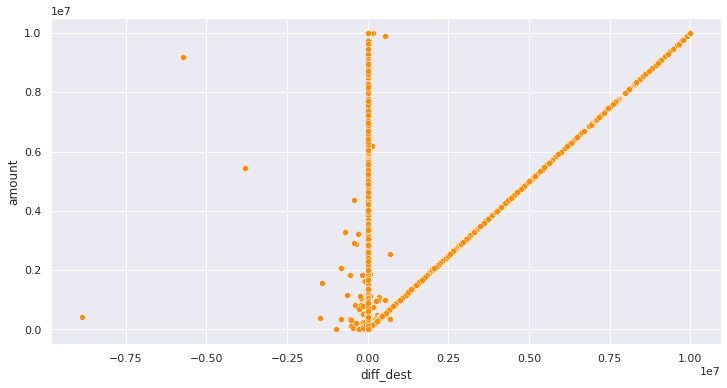

In [20]:
# diff_dest x amount scatterplot, fraudulent transactions
plt.subplots(figsize=(12,6))
sns.scatterplot(x='diff_dest', y='amount', color='darkorange', data=auxh7);

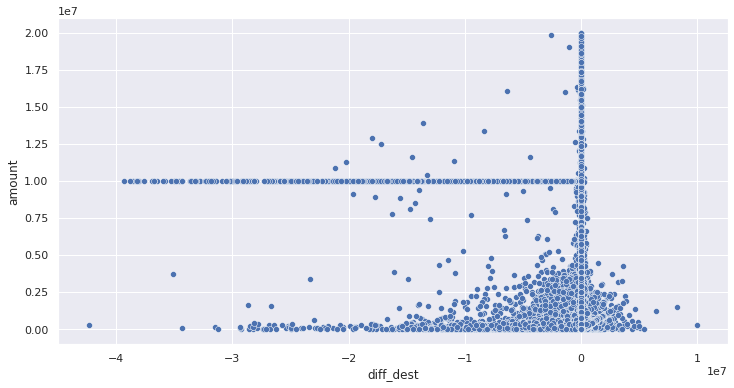

In [21]:
# diff_dest x amount scatterplot, regular transactions
plt.subplots(figsize=(12,6))
sns.scatterplot(x='diff_dest', y='amount', data=auxh73);

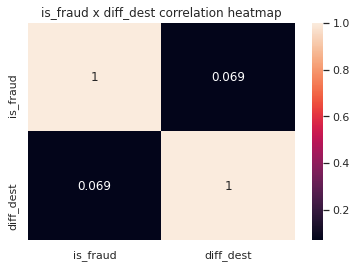

In [22]:
# point-biserial correlation coefficient heatmap function. For details, please see section 0.1. Helper Functions.
point_bi_corr(df4[['is_fraud']], df4[['diff_dest']]);

- diff_dest = oldbalance_dest + amount - newbalance_dest
- diff_dest equal to zero means that the difference between recipient balance before and after the transaction is equal to the amount of the transaction.
- A positive or negative diff_dest value means that the transaction amount was not properly taken into account in the recipient balance. Exception is the merchant customer, which recipient balance is not informed (balance equal to zero).
- 35.39% of fraudulent transactions have diff_dest value equal to zero.
- The diff_dest x amount scatterplot of fraudulent transactions shows clearly that the diff_dest values greater than zero are the same values of amount: it has a line pattern with 45° slope. This line stands out in the diff_dest x amount scatterplot with both regular and fraudulent transactions.
- It is possible to affirm that the transaction is fraudulent when diff_dest is equal to zero or when it is greater than zero and equal to the amount value of transaction.
- A diff_dest value equal to the transaction amount means that the recipient balance before the transaction has the same value of the recipient transaction after the transaction.
- Therefore, the hypothesis is True: Fraud occur when the recipient balance difference before and after the transaction is different from the transaction amount.

### H8. Fraud should not occur when the recipient balance difference before and after the transaction is equal to the origin difference before and after the transaction.**

**TRUE** Fraud does not occur when the recipient balance difference before and after the transaction is equal to the origin difference before and after the transaction.

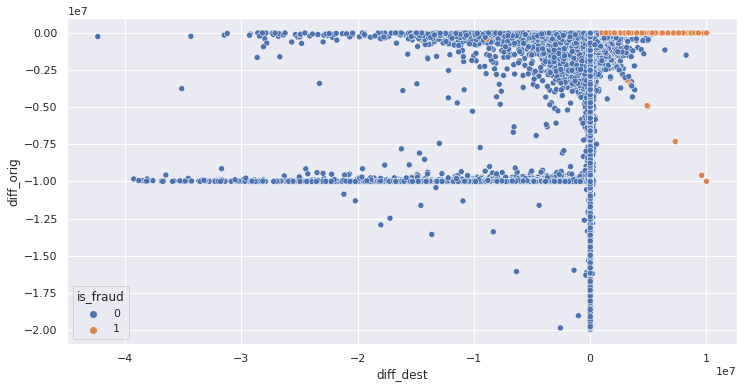

In [23]:
# diff_dest x diff_orig scatterplot
plt.subplots(figsize=(12,6))
sns.scatterplot(x='diff_dest', y='diff_orig', hue='is_fraud', data=df4);

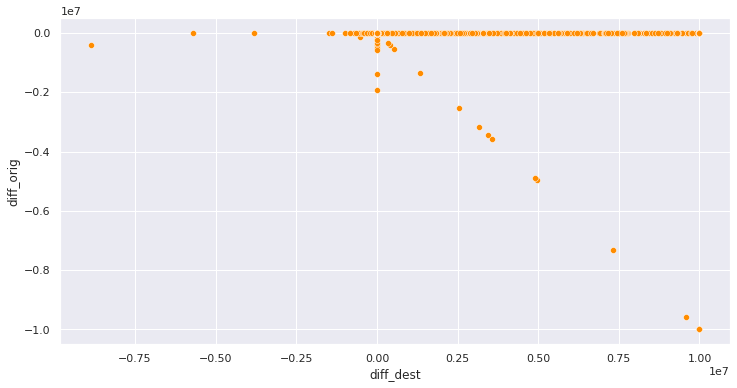

In [24]:
# diff_dest x diff_orig scatterplot, fraudulent transactions
plt.subplots(figsize=(12,6))
auxh8 = df4[df4['is_fraud'] == 1]
sns.scatterplot(x='diff_dest', y='diff_orig', color='darkorange', data=auxh8);

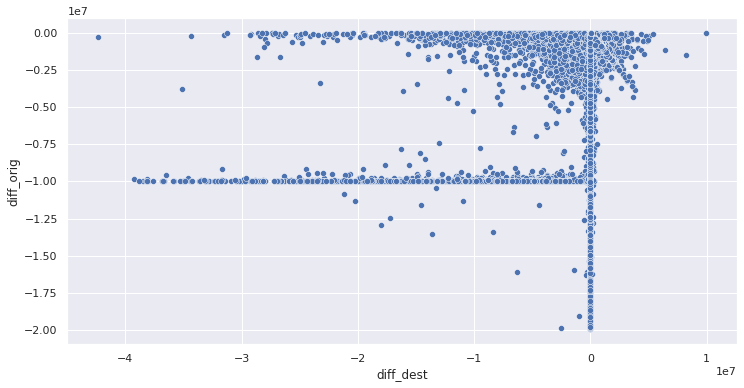

In [25]:
# diff_dest x diff_orig scatterplot, regular transactions
plt.subplots(figsize=(12,6))
auxh81 = df4[df4['is_fraud'] == 0]
sns.scatterplot(x='diff_dest', y='diff_orig', data=auxh81);

In [26]:
# diff_orig = 0 and diff_dest = 0: theoretically transactions without error
auxh82 = df4[(df4['diff_orig'] == 0) & (df4['diff_dest'] == 0)]
auxh82.describe()

step           day        amount  oldbalance_org  \
count  85391.000000  85391.000000  8.539100e+04    8.539100e+04   
mean     261.412081     11.230329  1.009378e+05    2.597786e+05   
std      144.577666      6.025000  4.564218e+05    5.375433e+05   
min        1.000000      1.000000  0.000000e+00    0.000000e+00   
25%      164.000000      7.000000  9.665630e+03    5.734900e+04   
50%      257.000000     11.000000  3.762437e+04    1.519560e+05   
75%      352.000000     15.000000  9.800122e+04    3.260200e+05   
max      743.000000     31.000000  1.000000e+07    4.381886e+07   

       newbalance_orig  diff_orig  merchant_dest  oldbalance_dest  \
count     8.539100e+04    85391.0        85391.0     8.539100e+04   
mean      1.588408e+05        0.0            0.0     9.200622e+05   
std       2.857678e+05        0.0            0.0     2.366345e+06   
min       0.000000e+00        0.0            0.0     0.000000e+00   
25%       3.156582e+04        0.0            0.0     0.000000e+00   
50%       8.640472e+04        0.0            0.0     1.306456e+05   
75%       2.097531e+05        0.0            0.0     7.519711e+05   
max       4.368662e+07        0.0            0.0     4.981923e+07   

       newbalance_dest  diff_dest      is_fraud  is_flagged_fraud  
count     8.539100e+04    85391.0  85391.000000           85391.0  
mean      1.021000e+06        0.0      0.023703               0.0  
std       2.410269e+06        0.0      0.152122               0.0  
min       0.000000e+00        0.0      0.000000               0.0  
25%       6.158174e+04        0.0      0.000000               0.0  
50%       2.287562e+05        0.0      0.000000               0.0  
75%       8.638894e+05        0.0      0.000000               0.0  
max       4.984039e+07        0.0      1.000000               0.0

<AxesSubplot:xlabel='step', ylabel='amount'>

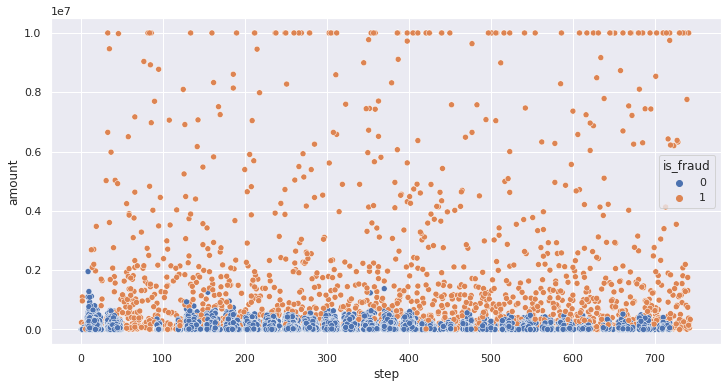

In [27]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='step', y='amount', hue='is_fraud', data=auxh82)

In [28]:
auxh82['is_fraud'].value_counts(normalize=True)

0    0.976297
1    0.023703
Name: is_fraud, dtype: float64

In [29]:
# diff_dest equal diff_orig
auxh83 = df4[(df4['diff_dest'] == df4['diff_orig'])]
auxh83['is_fraud'].value_counts(normalize=True)

0    0.976327
1    0.023673
Name: is_fraud, dtype: float64

- The diff_dest x diff_orig scatterplot shows that fraudulent transactions happen when diff_orig is equal to zero and diff_dest is greater than zero.
- Theoretically, a transaction without error is when diff_dest and diff_orig are equal to zero, i.e., the transaction amount is correctly considered in the origin and recipient balances.
- When both diff_dest and diff_orig are equal to zero, only 2.37% of the transactions are fraudulent.
- Therefore, the hypothesis is True: Fraud does not occur when the recipient balance difference before and after the transaction is equal to the origin difference before and after the transaction.

### H9. Fraud should occur for merchant customer as recipient.

**FALSE** Fraud does not occur for merchant customer as recipient.

In [30]:
# Merchant filtering
auxh9 = df4[df4['merchant_dest'] == 1]
auxh9.describe()

step           day        amount  oldbalance_org  \
count  1.506155e+06  1.506155e+06  1.506155e+06    1.506155e+06   
mean   2.443973e+02  1.052316e+01  1.306412e+04    6.827056e+04   
std    1.426746e+02  5.933951e+00  1.256190e+04    1.979510e+05   
min    1.000000e+00  1.000000e+00  2.000000e-02    0.000000e+00   
25%    1.560000e+02  7.000000e+00  4.383120e+03    0.000000e+00   
50%    2.490000e+02  1.100000e+01  9.485970e+03    1.053600e+04   
75%    3.350000e+02  1.400000e+01  1.757438e+04    6.092000e+04   
max    7.180000e+02  3.000000e+01  2.305492e+05    3.480408e+07   

       newbalance_orig     diff_orig  merchant_dest  oldbalance_dest  \
count     1.506155e+06  1.506155e+06      1506155.0        1506155.0   
mean      6.188764e+04 -6.681203e+03            1.0              0.0   
std       1.959364e+05  1.118201e+04            0.0              0.0   
min       0.000000e+00 -2.298962e+05            1.0              0.0   
25%       0.000000e+00 -9.663960e+03            1.0              0.0   
50%       0.000000e+00 -3.768000e+02            1.0              0.0   
75%       4.971396e+04  0.000000e+00            1.0              0.0   
max       3.478348e+07  1.000000e-02            1.0              0.0   

       newbalance_dest     diff_dest   is_fraud  is_flagged_fraud  
count        1506155.0  1.506155e+06  1506155.0         1506155.0  
mean               0.0  1.306412e+04        0.0               0.0  
std                0.0  1.256190e+04        0.0               0.0  
min                0.0  2.000000e-02        0.0               0.0  
25%                0.0  4.383120e+03        0.0               0.0  
50%                0.0  9.485970e+03        0.0               0.0  
75%                0.0  1.757438e+04        0.0               0.0  
max                0.0  2.305492e+05        0.0               0.0

In [31]:
auxh9['is_fraud'].value_counts()

0    1506155
Name: is_fraud, dtype: int64

In [32]:
auxh91 = df4[df4['is_fraud'] == 1]
auxh91['merchant_dest'].value_counts()

0    5747
Name: merchant_dest, dtype: int64

- There are not fraudulent transactions for merchant customers.
- The hypothesis is False: fraud does not occur for merchant customer as recipient.

### H10. Fraud should occur for customers that receive the transaction with more frequency.

**FALSE** Fraud does not occur for customers that receive the transaction with more frequency.

In [33]:
# Customers that receive transactions more than once
auxh10 = df4[['amount', 'name_dest', 'is_fraud']].groupby(['name_dest', 'is_fraud']).count().reset_index()
auxh10.columns = ['name_dest', 'is_fraud', 'transactions']
auxh11 = auxh10[['name_dest', 'is_fraud', 'transactions']].groupby(['transactions', 'is_fraud']).count().reset_index()
auxh11

transactions  is_fraud  name_dest
0              1         0    1630577
1              1         1       5711
2              2         0      82374
3              2         1         18
4              3         0      59345
..           ...       ...        ...
69            71         0          2
70            73         0          1
71            75         0          1
72            76         0          1
73            84         0          1

[74 rows x 3 columns]

- From all 5749 fraudulent transactions, 5711 were made for different recipients and 38 were made for the same recipient.
- Therefore, the hypothesis is False: Fraud does not occur for customers that receive the transaction with more frequency.

### H11. Fraud should occur for transactions made before day 15.

**FALSE** Fraud occur for transactions made after day 15.

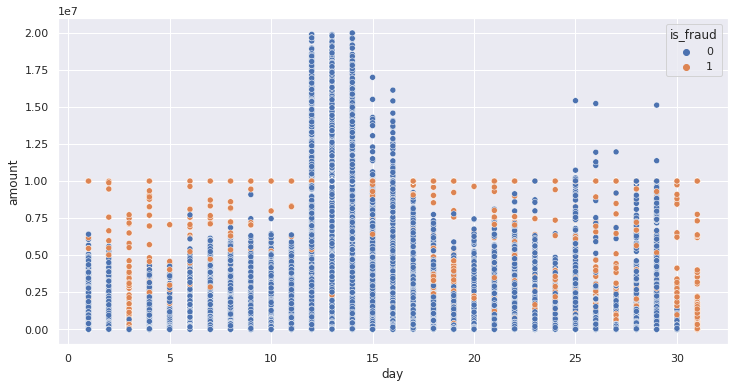

In [34]:
# amount x day scatterplot
plt.subplots(figsize=(12,6))
sns.scatterplot(x='day', y='amount', hue='is_fraud', data=df4);

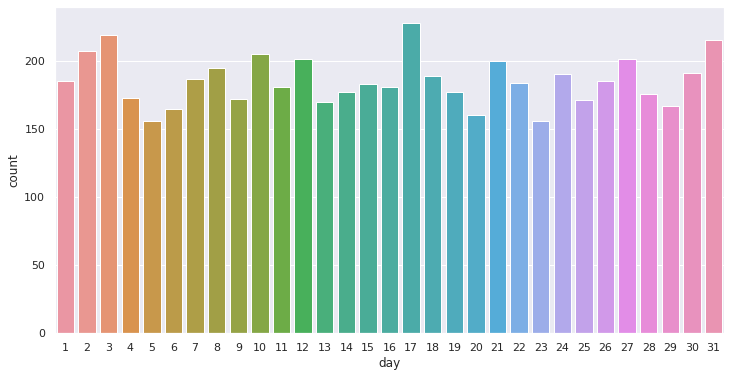

In [35]:
# fraudulent transactions per day
auxh11 = df4[df4['is_fraud'] == 1]
plt.subplots(figsize=(12,6))
sns.countplot(auxh11['day']);

In [36]:
# sum of fraudulent transactions
auxh12 = auxh11[['day', 'amount']].groupby('day').count().reset_index()
sum_15 = auxh12['amount'][:15].sum()
sum_31 = auxh12['amount'][15:].sum()
print('Fraudulent Transactions from day 1 until day 15: {}'.format(sum_15))
print('Fraudulent Transactions from day 16 until day 31: {}'.format(sum_31))

Fraudulent Transactions from day 1 until day 15: 2776
Fraudulent Transactions from day 16 until day 31: 2971


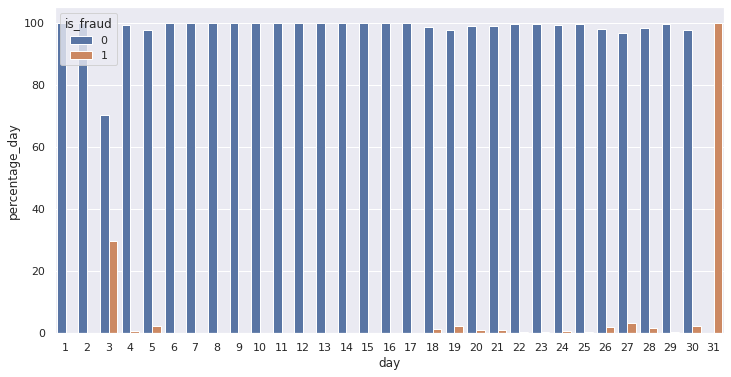

In [37]:
# percentage of transactions per day
auxh13 = df4[['day', 'amount', 'is_fraud']].groupby(['day', 'is_fraud']).count().reset_index()
auxh13.columns = ['day', 'is_fraud', 'transactions']
auxh14 = auxh13[['day', 'transactions']].groupby('day').sum().reset_index()
auxh14.columns = ['day', 'transactions_day']
auxh15 = pd.merge(auxh13, auxh14, how='left', on='day')
auxh15['percentage_day'] = np.round(((auxh15['transactions'] / auxh15['transactions_day']) * 100), decimals=2)

# plot percentage per day
plt.subplots(figsize=(12,6))
sns.barplot(x='day', y='percentage_day', hue='is_fraud', data=auxh15);

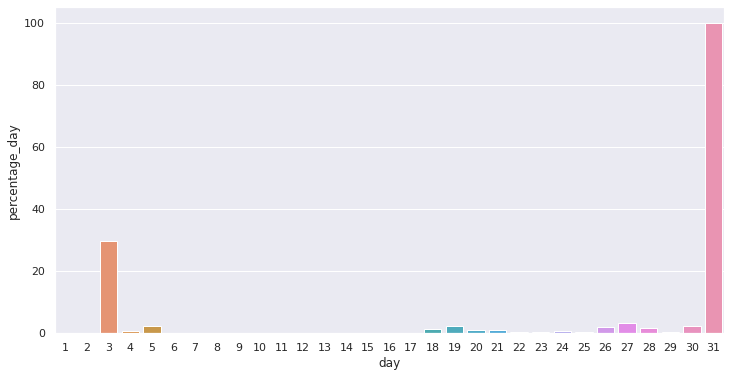

In [38]:
# show fraudulent transactions percentage per day
auxh16 = auxh15[auxh15['is_fraud'] == 1]
plt.subplots(figsize=(12,6))
sns.barplot(x='day', y='percentage_day', data=auxh16);

In [39]:
auxh16

day  is_fraud  transactions  transactions_day  percentage_day
1     1         1           185            402023            0.05
3     2         1           207            318275            0.07
5     3         1           219               735           29.80
7     4         1           173             19816            0.87
9     5         1           156              6801            2.29
11    6         1           165            309311            0.05
13    7         1           187            294132            0.06
15    8         1           195            314909            0.06
17    9         1           172            292982            0.06
19   10         1           205            274987            0.07
21   11         1           181            292492            0.06
23   12         1           201            244686            0.08
25   13         1           170            299162            0.06
27   14         1           177            277396            0.06
29   15         1           183            280743            0.07
31   16         1           181            262502            0.07
33   17         1           228            297579            0.08
35   18         1           189             14704            1.29
37   19         1           177              7953            2.23
39   20         1           160             13686            1.17
41   21         1           200             17176            1.16
43   22         1           184             37235            0.49
45   23         1           156             35856            0.44
47   24         1           190             22903            0.83
49   25         1           171             40436            0.42
51   26         1           185              9669            1.91
53   27         1           201              6033            3.33
55   28         1           176             10233            1.72
57   29         1           167             38349            0.44
59   30         1           191              7915            2.41
60   31         1           215               215          100.00

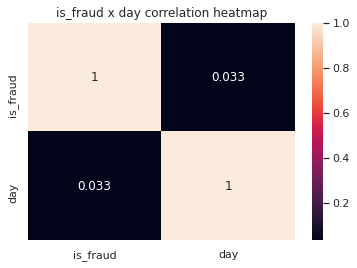

In [40]:
# point-biserial correlation coefficient heatmap function. For details, please see section 0.1. Helper Functions.
point_bi_corr(df4[['is_fraud']], df4[['day']]);

- 2776 fraudulent transactions were made from day 1 until day 15.
- 2971 fraudulent transactions were made from day 16 until day 31.
- 29.8% transactions made on day 3 were fraudulent. Other days with highest fraudulent transaction ratio are day 5 (2.29%), day 27 (3.33%), day 30 (2.41%) and day 19 (2.23%).
- Day 31 stands out from the other days: 100% of the transactions made on this day were fraudulent.
- Therefore, the hypothesis is false: Fraud occur for transactions made after day 15.

### 4.2.1. Hypothesis Summary

In [32]:
# display columns complete description
pd.set_option('display.max_colwidth', None)

# Hypothesis Summary dataframe
summary = pd.DataFrame({'Hypothesis':['Fraud should occur with high transaction amount.',
                                      'Fraud should occur with cash out transaction type.',
                                      'Fraud should not occur when the origin balance before the transaction is equal to zero.',
                                      'Fraud should occur when origin balance after the transaction is equal to zero.',
                                      'Fraud should occur when the origin balance difference before and after the transaction is different from the transaction amount.',
                                      'Fraud should occur when the recipient balance after the transaction is equal to zero in more than 70% of the fraudulent transactions.',
                                      'Fraud should occur when the recipient balance difference before and after the transaction is different from the transaction amount.',
                                      'Fraud should not occur when the recipient balance difference before and after the transaction is equal to the origin difference before and after the transaction.',
                                      'Fraud should occur for merchant customer as recipient.',
                                      'Fraud should occur for customers that receive the transaction with more frequency.',
                                      'Fraud should occur for transactions made before day 15.',
                                      ],
                        'True / False':['True', 'True', 'True', 'True', 'False', 'False', 'True', 'True', 'False',
                                        'False', 'False'], 
                        'Relevance':['High', 'High', 'Low', 'Low', 'Medium', 'Low', 'High', 'Medium', 'Low', 'Low',
                                     'Low']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
summary

Hypothesis  \
1                                                                                                                    Fraud should occur with high transaction amount.   
2                                                                                                                  Fraud should occur with cash out transaction type.   
3                                                                             Fraud should not occur when the origin balance before the transaction is equal to zero.   
4                                                                                      Fraud should occur when origin balance after the transaction is equal to zero.   
5                                    Fraud should occur when the origin balance difference before and after the transaction is different from the transaction amount.   
6                               Fraud should occur when the recipient balance after the transaction is equal to zero in more than 70% of the fraudulent transactions.   
7                                 Fraud should occur when the recipient balance difference before and after the transaction is different from the transaction amount.   
8   Fraud should not occur when the recipient balance difference before and after the transaction is equal to the origin difference before and after the transaction.   
9                                                                                                              Fraud should occur for merchant customer as recipient.   
10                                                                                 Fraud should occur for customers that receive the transaction with more frequency.   
11                                                                                                            Fraud should occur for transactions made before day 15.   

   True / False Relevance  
1          True      High  
2          True      High  
3          True       Low  
4          True       Low  
5         False    Medium  
6         False       Low  
7          True      High  
8          True    Medium  
9         False       Low  
10        False       Low  
11        False       Low

## 4.3. Multivariate Analysis**

### 4.3.1. Numerical Attributes**

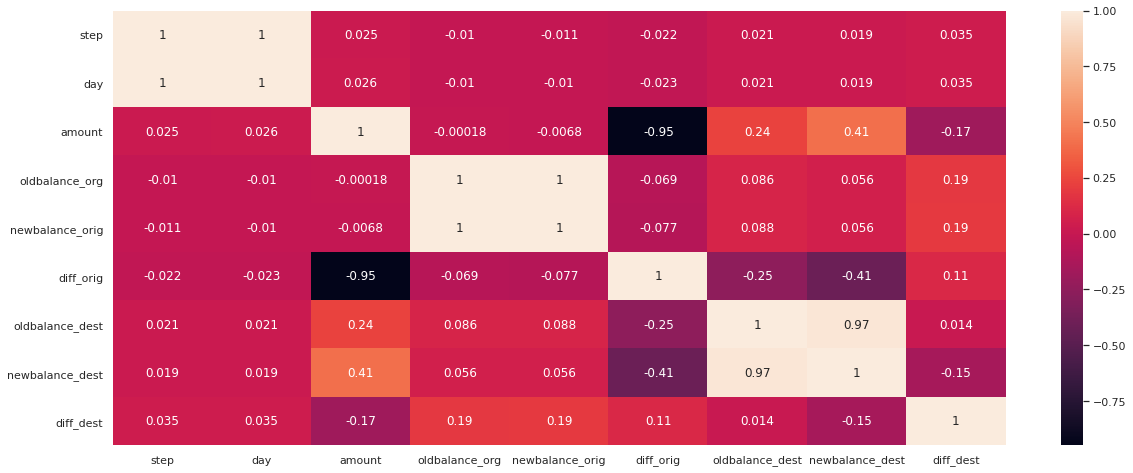

In [41]:
# select numerical attributes
num_attr = df4.select_dtypes(include=['int64', 'float64'])

# drop binary variables
num_attr = df4.drop(['merchant_dest', 'is_fraud', 'is_flagged_fraud'], axis=1)

# correlation by pearosn method
correlation = num_attr.corr( method='pearson' )

# set up figure size
f, ax = plt.subplots( figsize=(20,8))

sns.heatmap( correlation, annot=True );

Highest correlations:

- step x day = 1 (day was created with step);
- oldbalance_org x newbalance_orig = 1;
- oldbalance_dest x newbalance_dest = 0.97;
- amount x diff_orig = -0.95;
- amount x newbalance_dest = 0.41;
- newbalance_dest x diff_orig = -0.41;
- oldbalance_dest x diff_orig = -0.25;

The diff_orig feature has more correlation with oldbalance_dest (-0.25) and newbalance_dest (-0.41) than with origin balances. The same is true for diff_dest: it has more correlation with oldbalance_org (0.19) and newbalance_orig (0.19) than with destination balances.

# 5.0. Data Preparation

In [17]:
df5 = df4.copy()

In [20]:
df5.head()

step  day      type    name_orig      amount  oldbalance_org  \
0   308   13   CASH_IN   C386091144   260485.23        32371.00   
1    16    1  TRANSFER   C977405179  1387060.19       432673.78   
2   254   11  TRANSFER  C1091684896  1140661.98        59947.00   
3   380   16   CASH_IN   C300199504   169390.39        80047.10   
4    40    2   CASH_IN   C905217988     4867.26      5989226.14   

   newbalance_orig   diff_orig    name_dest  merchant_dest  oldbalance_dest  \
0        292856.23  -520970.46   C268784004              0       4633560.35   
1             0.00  -954386.41  C1032483118              0             0.00   
2             0.00 -1080714.98  C1969901822              0         15000.85   
3        249437.49  -338780.78   C591887141              0       1467039.66   
4       5994093.40    -9734.52   C926869366              0       1609385.28   

   newbalance_dest  diff_dest  is_fraud  is_flagged_fraud  
0       4373075.12  520970.46         0                 0  
1       1033440.62  353619.57         0                 0  
2       1155662.83       0.00         0                 0  
3       1297649.27  338780.78         0                 0  
4       1604518.02    9734.52         0                 0

## 5.1. Rescaling

In [18]:
# 1. Min-Max Scaler - step
mms = MinMaxScaler()

# step
df5['step'] = mms.fit_transform(df5[['step']].values)
# save scaler, so it can be applied in new data
with open('parameter/step_scaler.pkl', 'wb') as f:
    pickle.dump(mms, f)

# 2. Robust Scaler - amount, oldbalance_org, newbalane_orig, diff_orig, oldbalance_dest, newbalance_dest, diff_dest
rs = RobustScaler()

# amount
df5['amount'] = rs.fit_transform(df5[['amount']].values)
# save scaler, so it can be applied in new data
with open('parameter/amount_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# oldbalance_org
df5['oldbalance_org'] = rs.fit_transform(df5[['oldbalance_org']].values)
# save scaler, so it can be applied in new data
with open('parameter/oldbalance_org_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# newbalance_orig
df5['newbalance_orig'] = rs.fit_transform(df5[['newbalance_orig']].values)
# save scaler, so it can be applied in new data
with open('parameter/newbalance_orig_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# diff_orig
df5['diff_orig'] = rs.fit_transform(df5[['diff_orig']].values)
# save scaler, so it can be applied in new data
with open('parameter/diff_orig_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# oldbalance_dest
df5['oldbalance_dest'] = rs.fit_transform(df5[['oldbalance_dest']].values)
# save scaler, so it can be applied in new data
with open('parameter/oldbalance_dest_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# newbalance_dest
df5['newbalance_dest'] = rs.fit_transform(df5[['newbalance_dest']].values)
# save scaler, so it can be applied in new data
with open('parameter/newbalance_dest_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)

# diff_dest
df5['diff_dest'] = rs.fit_transform(df5[['diff_dest']].values)
# save scaler, so it can be applied in new data
with open('parameter/diff_dest_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)

## 5.2. Transformation

### 5.2.1. Encoding

In [19]:
# type feature - apply one hot encoding
df5 = pd.get_dummies(df5, prefix=['type'], columns=['type'])

### 5.2.2. Nature Transformation

In [20]:
# apply nature transformation on day feature
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/31 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/31 ) ) )

In [21]:
df5.head().T

0            1            2           3           4
step                0.413747    0.0202156      0.34097    0.510782   0.0525606
day                       13            1           11          16           2
name_orig         C386091144   C977405179  C1091684896  C300199504  C905217988
amount              0.952259      6.72726      5.46419    0.485292    -0.35808
oldbalance_org      0.168531      3.89422     0.425186    0.612261       55.61
newbalance_orig      2.02684            0            0     1.72634     41.4848
diff_orig           -1.83754     -3.59755     -4.11054     -1.0977    0.238489
name_dest         C268784004  C1032483118  C1969901822  C591887141  C926869366
merchant_dest              0            0            0           0           0
oldbalance_dest      4.78736    -0.140664     -0.12471     1.41961       1.571
newbalance_dest      3.75066     0.738768     0.848996    0.977048      1.2538
diff_dest            17.5948      11.9045    -0.119441     11.3999    0.211556
is_fraud                   0            0            0           0           0
is_flagged_fraud           0            0            0           0           0
type_CASH_IN               1            0            0           1           1
type_CASH_OUT              0            0            0           0           0
type_DEBIT                 0            0            0           0           0
type_PAYMENT               0            0            0           0           0
type_TRANSFER              0            1            1           0           0
day_sin             0.485302     0.201299     0.790776   -0.101168    0.394356
day_cos            -0.874347      0.97953    -0.612106   -0.994869    0.918958

# 6.0. Feature Selection

In [22]:
# Remove unnecessary columns

# Remove step because feature day was created based on it
# Remove day because day_sin and day_cos were created
# Remove name_orig and name_dest because they will not be considered to train the model

df5 = df5.drop(['step', 'day', 'name_orig', 'name_dest'], axis=1)

In [23]:
# Remove target variable from train set
X_train = df5.drop('is_fraud', axis=1)

# target variable
y_train = df5['is_fraud'].copy()

In [28]:
X_train.head()

amount  oldbalance_org  newbalance_orig  diff_orig  merchant_dest  \
0  0.952259        0.168531         2.026840  -1.837536              0   
1  6.727265        3.894219         0.000000  -3.597550              0   
2  5.464188        0.425186         0.000000  -4.110545              0   
3  0.485292        0.612261         1.726342  -1.097701              0   
4 -0.358080       55.610018        41.484762   0.238489              0   

   oldbalance_dest  newbalance_dest  diff_dest  is_flagged_fraud  \
0         4.787359         3.750664  17.594788                 0   
1        -0.140664         0.738768  11.904461                 0   
2        -0.124710         0.848996  -0.119441                 0   
3         1.419606         0.977048  11.399907                 0   
4         1.570998         1.253802   0.211556                 0   

   type_CASH_IN  type_CASH_OUT  type_DEBIT  type_PAYMENT  type_TRANSFER  \
0             1              0           0             0              0   
1             0              0           0             0              1   
2             0              0           0             0              1   
3             1              0           0             0              0   
4             1              0           0             0              0   

    day_sin   day_cos  
0  0.485302 -0.874347  
1  0.201299  0.979530  
2  0.790776 -0.612106  
3 -0.101168 -0.994869  
4  0.394356  0.918958

In [29]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64

## 6.1. Random Forest as Feature Selector

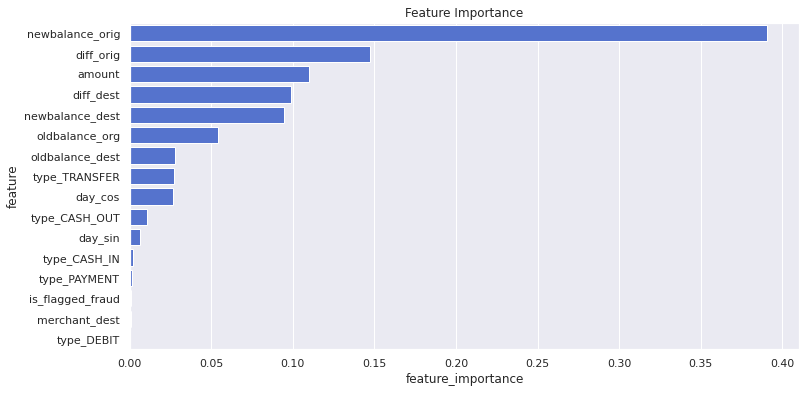

In [30]:
# train random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

- The top features selected by the random forest are in accordance with the exploratory data analysis.

In [31]:
# Select top 11 features
feat_imp_select = feat_imp.iloc[:11]
feat_imp_select

feature  feature_importance
0   newbalance_orig            0.390785
1         diff_orig            0.147341
2            amount            0.110109
3         diff_dest            0.098723
4   newbalance_dest            0.094642
5    oldbalance_org            0.053951
6   oldbalance_dest            0.028049
7     type_TRANSFER            0.027072
8           day_cos            0.026602
9     type_CASH_OUT            0.010725
10          day_sin            0.006618

In [32]:
# top features list
feat_list = feat_imp_select['feature'].to_list()
feat_list

['newbalance_orig',
 'diff_orig',
 'amount',
 'diff_dest',
 'newbalance_dest',
 'oldbalance_org',
 'oldbalance_dest',
 'type_TRANSFER',
 'day_cos',
 'type_CASH_OUT',
 'day_sin']

## 6.2. Boruta as Feature Selector

In [34]:
# Boruta disabled, as it took 2h 4m to be executed.

# Boruta does not accept pandas df format, therefore the dataset must be converted to numpy values
# training and test dataset for Boruta

#x_train_n = X_train.values

# ravel() puts the values into a vector
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

# set Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	4
Rejected: 	7
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	4
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	4
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	4
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	3
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	9
Iteration:

### 6.2.1. Best Features from Boruta

In [35]:
# Boruta disabled, as it took 2h 4m to be executed.

#cols_selected = boruta.support_.tolist()

# best features by boruta
#x_train_fs = X_train
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# features not selected by boruta
#cols_not_selected_boruta = list( np.setdiff1d ( x_train_fs.columns, cols_selected_boruta ))

#cols_selected_boruta

['amount',
 'newbalance_orig',
 'diff_orig',
 'oldbalance_dest',
 'diff_dest',
 'day_cos']

In [36]:
#cols_not_selected_boruta

['day_sin',
 'is_flagged_fraud',
 'merchant_dest',
 'newbalance_dest',
 'oldbalance_org',
 'type_CASH_IN',
 'type_CASH_OUT',
 'type_DEBIT',
 'type_PAYMENT',
 'type_TRANSFER']

- The features selected by Boruta are among the top 7 features selected by the random forest.
- The top 11 features selected by random forest will be used for the next steps.

## 6.3. Save Preprocessed Data

In [24]:
# copy x_train with selected features
feat_list = ['newbalance_orig',
 'diff_orig',
 'amount',
 'diff_dest',
 'newbalance_dest',
 'oldbalance_org',
 'oldbalance_dest',
 'type_TRANSFER',
 'day_cos',
 'type_CASH_OUT',
 'day_sin']

x_train = X_train[feat_list]

In [26]:
# Save the preprocessed dataset
with open('dataset/train_prep_v02.pkl', 'wb') as f:
    pickle.dump(x_train, f)
    
# save target variable
with open('dataset/train_target_v02.pkl', 'wb') as f:
    pickle.dump(y_train, f)

# 7.0. Machine Learning Modelling

In [4]:
# Open preprocessed dataset
with open('dataset/train_prep_v02.pkl', 'rb') as f:
    x_train = pickle.load(f)
    
# open target variable
with open('dataset/train_target_v02.pkl', 'rb') as f:
    y_train = pickle.load(f)

In [5]:
x_train.sample(5)

newbalance_orig  diff_orig    amount  diff_dest  newbalance_dest  \
3897159         0.017190   0.278018 -0.333054   0.212058        -0.193255   
3505044         0.000000  -0.945389  1.161343  -0.119441         0.978521   
1957741         0.000000  -1.046332  1.317977  -0.119441         0.361174   
3364966        13.082673  -0.510198  0.114473   6.480549         0.793835   
111366         31.889357  -1.822216  0.942589  17.466503         1.919488   

         oldbalance_org  oldbalance_dest  type_TRANSFER   day_cos  \
3897159       -0.018896        -0.140664              0  0.979530   
3505044       -0.132751         0.920769              0 -0.994869   
1957741       -0.079719         0.160247              0  0.347305   
3364966       16.557347         1.126611              0 -0.954139   
111366        40.344742         2.625884              0 -0.050649   

         type_CASH_OUT   day_sin  
3897159              0 -0.201299  
3505044              1 -0.101168  
1957741              1  0.937752  
3364966              0  0.299363  
111366               0  0.998717

In [6]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4450894 entries, 0 to 4453833
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   newbalance_orig  float64
 1   diff_orig        float64
 2   amount           float64
 3   diff_dest        float64
 4   newbalance_dest  float64
 5   oldbalance_org   float64
 6   oldbalance_dest  float64
 7   type_TRANSFER    uint8  
 8   day_cos          float64
 9   type_CASH_OUT    uint8  
 10  day_sin          float64
dtypes: float64(9), uint8(2)
memory usage: 348.1 MB


In [7]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64

## 7.1. Logistic Regression

In [8]:
# define the model
logit_clf = LogisticRegression()

# fit the model
logit_clf.fit(x_train, y_train)

# model performance with performance function. For more details, please see Helper Functions section.
logit_performance = performance(logit_clf, x_train, y_train)
logit_performance

test_accuracy  test_precision  test_recall  test_f1_score  \
0       0.999255        0.892152     0.480774       0.624734   

   test_roc_auc_score  test_mcc  
0             0.74035  0.654569

In [11]:
# predcitions
logit_y_pred = cross_val_predict(logit_clf, x_train, y_train, cv=10)

# save predictions
with open('model/predictions/logit_y_pred.pkl', 'wb') as f:
    pickle.dump(logit_y_pred, f)

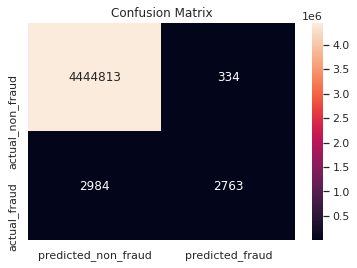

In [12]:
# confusion matrix
logit_cm = confusion_matrix(y_train, logit_y_pred)

# dataframe for heatmap
logit_cm_df = pd.DataFrame(logit_cm, columns=['predicted_non_fraud', 'predicted_fraud'], index=['actual_non_fraud', 'actual_fraud'])

# confusion matrix heatmap
sns.heatmap(logit_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

## 7.2. Random Forest Classifier

In [5]:
# define the model
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1).fit(x_train, y_train)

In [14]:
# model performance with performance function. For more details, please see Helper Functions section.
rf_performance = performance(rf_clf, x_train, y_train)
rf_performance

test_accuracy  test_precision  test_recall  test_f1_score  \
0       0.999994        0.999651     0.995475       0.997557   

   test_roc_auc_score  test_mcc  
0            0.997737  0.997557

In [15]:
# predcitions
rf_y_pred = cross_val_predict(rf_clf, x_train, y_train, cv=10)

# save predictions
with open('model/predictions/rf_y_pred.pkl', 'wb') as f:
    pickle.dump(rf_y_pred, f)

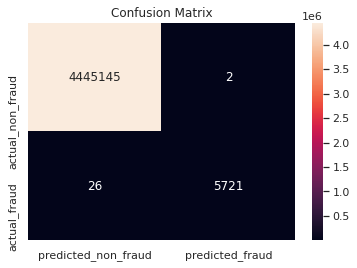

In [16]:
# confusion matrix
rf_cm = confusion_matrix(y_train, rf_y_pred)

# dataframe for heatmap
rf_cm_df = pd.DataFrame(rf_cm, columns=['predicted_non_fraud', 'predicted_fraud'], index=['actual_non_fraud', 'actual_fraud'])

# confusion matrix heatmap
sns.heatmap(rf_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

## 7.3. Isolation Forest

In [17]:
# set isolation forest model
iforest_clf = IsolationForest(max_samples=0.25, random_state=11, contamination=0.15, n_jobs=-1)

# fit the model
iforest_clf.fit(x_train)

IsolationForest(contamination=0.15, max_samples=0.25, n_jobs=-1,
                random_state=11)

In [18]:
# Predictions with cross-validation
y_train_pred = cross_val_predict(iforest_clf, x_train, cv=10)

# save predictions
with open('model/predictions/iforest_y_pred.pkl', 'wb') as f:
    pickle.dump(y_train_pred, f)

y_train_pred

array([ 1, -1, -1, ...,  1,  1,  1])

In [19]:
# transform predictions to 0 and 1 to be compatible with y_train
y_train_comp = np.where(y_train_pred==-1, 1, y_train_pred-1)
y_train_comp

array([0, 1, 1, ..., 0, 0, 0])

In [20]:
# roc_auc_score
iforest_roc_auc = roc_auc_score(y_train, y_train_comp)
iforest_roc_auc

0.8100928734667125

In [21]:
# precision and recall
iforest_precision = precision_score(y_train, y_train_comp)
iforest_recall = recall_score(y_train, y_train_comp)
print('Precision: {}'.format(iforest_precision))
print('Recall: {}'.format(iforest_recall))

Precision: 0.00662074169674847
Recall: 0.7694449277884113


In [22]:
# confusion matrix
cm = confusion_matrix(y_train, y_train_comp)
cm

# heatmap

# dataframe for heatmap
cm_df = pd.DataFrame(cm, columns=['predicted_non_fraud', 'predicted_fraud'], index=['actual_non_fraud', 'actual_fraud'])
cm_df

predicted_non_fraud  predicted_fraud
actual_non_fraud              3781668           663479
actual_fraud                     1325             4422

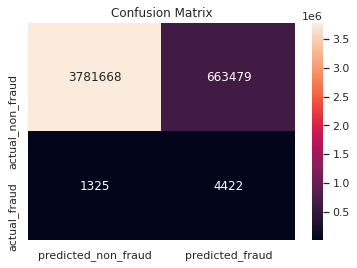

In [23]:
# return heatmap
sns.heatmap(cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

In [24]:
# accuracy
iforest_acc = accuracy_score(y_train, y_train_comp)

# f1_score
iforest_f1 = f1_score(y_train, y_train_comp)

# mcc_score
iforest_mcc = matthews_corrcoef(y_train, y_train_comp)

In [25]:
# performance dataframe
iforest_performance = pd.DataFrame({'test_accuracy':[iforest_acc], 'test_precision':[iforest_precision],
                                 'test_recall':[iforest_recall], 'test_f1_score':[iforest_f1], 
                                 'test_roc_auc_score':[iforest_roc_auc], 'test_mcc':[iforest_mcc]})

iforest_performance

test_accuracy  test_precision  test_recall  test_f1_score  \
0       0.850636        0.006621     0.769445       0.013129   

   test_roc_auc_score  test_mcc  
0            0.810093  0.062361

## 7.5. XGBoost Classifier

In [15]:
# define the model
xgb_clf = XGBClassifier(random_state=42, n_jobs=-1).fit(x_train, y_train)

[17:39:15] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [28]:
# model performance with performance function. For more details, please see Helper Functions section.
xgb_performance = performance(xgb_clf, x_train, y_train)
xgb_performance

test_accuracy  test_precision  test_recall  test_f1_score  \
0       0.999993        0.999127     0.995475       0.997296   

   test_roc_auc_score  test_mcc  
0            0.997737  0.997295

In [29]:
# predictions
xgb_y_pred = cross_val_predict(xgb_clf, x_train, y_train, cv=10)

# save predictions
with open('model/predictions/xgb_y_pred.pkl', 'wb') as f:
    pickle.dump(xgb_y_pred, f)

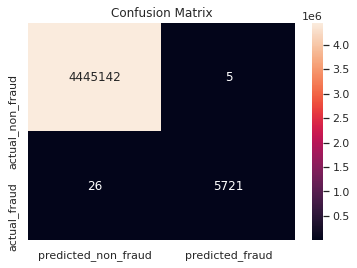

In [30]:
# confusion matrix
xgb_cm = confusion_matrix(y_train, xgb_y_pred)

# dataframe for heatmap
xgb_cm_df = pd.DataFrame(xgb_cm, columns=['predicted_non_fraud', 'predicted_fraud'], index=['actual_non_fraud', 'actual_fraud'])

# confusion matrix heatmap
sns.heatmap(xgb_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

## 7.5. Performance Comparison

In [31]:
# performance comparison data frame
performance_comp = pd.concat([logit_performance, rf_performance, iforest_performance, xgb_performance])
performance_comp.columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']
performance_comp['model'] = ['Logistic Regression', 'Random Forest', 'Isolation Forest', 'XGBoost']
performance_comp = performance_comp[['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']]
performance_comp.set_index('model')

accuracy  precision    recall  f1_score  roc_auc_score  \
model                                                                         
Logistic Regression  0.999255   0.892152  0.480774  0.624734       0.740350   
Random Forest        0.999994   0.999651  0.995475  0.997557       0.997737   
Isolation Forest     0.850636   0.006621  0.769445  0.013129       0.810093   
XGBoost              0.999993   0.999127  0.995475  0.997296       0.997737   

                          MCC  
model                          
Logistic Regression  0.654569  
Random Forest        0.997557  
Isolation Forest     0.062361  
XGBoost              0.997295

- Random Forest is the model with the best performance

# 8.0. Hyperparameter Fine Tuning

## 8.1. Random Search

### 8.1.1. Tuned Random Forest 1

In [14]:
rf_clf_1 = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=10, n_estimators=80)
rf_clf_1.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1,
                       random_state=42)

### 8.1.2. Tuned Random Forest 2

In [15]:
rf_clf_2 = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=40, n_estimators=160,
                                  min_samples_split=5, min_samples_leaf=2)
rf_clf_2.fit(x_train, y_train)

RandomForestClassifier(max_depth=40, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=160, n_jobs=-1, random_state=42)

### 8.1.3. Tuned Random Forest 3

In [16]:
rf_clf_3 = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=20, n_estimators=200,
                                  min_samples_split=10, min_samples_leaf=4, max_features='log2')
rf_clf_3.fit(x_train, y_train)

RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=200, n_jobs=-1,
                       random_state=42)

## 8.2. Compare tuned model performance with base model on test set

### 8.2.1. Prepare test set

In [6]:
# load test set
test_set = pd.read_csv('dataset/test_set_v02.csv')
test_set.sample(5)

step      type     amount     nameOrig  oldbalanceOrg  \
1562299   400  CASH_OUT   71855.97  C1116425027           0.00   
864289    144   PAYMENT    7573.05    C76279752        2593.88   
1625046   306  CASH_OUT   13674.90  C1174918479           0.00   
702740    211   PAYMENT    8013.38  C1116938191       64951.00   
1704262    42   CASH_IN  138666.43   C975432400        5130.00   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
1562299            0.00   C721293145       237142.40       308998.37        0   
864289             0.00  M1899840469            0.00            0.00        0   
1625046            0.00   C378717851      8015408.20      8029083.10        0   
702740         56937.62  M1512803254            0.00            0.00        0   
1704262       143796.43  C1918185342        95397.03            0.00        0   

         isFlaggedFraud  
1562299               0  
864289                0  
1625046               0  
702740                0  
1704262               0

In [7]:
# cols new
cols_old = test_set.columns
# apply snakecase to columns names
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# Rename columns
test_set.columns = cols_new

# create origin balance difference feature
test_set['diff_orig'] = test_set['oldbalance_org'] - test_set['amount'] - test_set['newbalance_orig']

# create destination balance difference feature
test_set['diff_dest'] = test_set['oldbalance_dest'] + test_set['amount'] - test_set['newbalance_dest']

# create merchant_dest feature
test_set['merchant_dest'] = test_set.apply(lambda x: 1 if 'M' in x['name_dest'] else 0, axis=1)

# create day feature
test_set['day'] = test_set.apply(lambda x: (np.ceil(x['step'] / 24)).astype(int), axis=1)

# reorder columns
test_set = test_set[['step', 'day', 'type', 'name_orig', 'amount', 'oldbalance_org',
       'newbalance_orig', 'diff_orig', 'name_dest', 'merchant_dest', 
       'oldbalance_dest', 'newbalance_dest', 'diff_dest',
       'is_fraud', 'is_flagged_fraud']]

# Remove outliers from amount feature
test_set = test_set[test_set['amount'] < 20e6]

# Remove oldbalance_dest outliers
test_set = test_set[test_set['oldbalance_dest'] < 5e7]

# Remove newbalance_dest outliers
test_set = test_set[test_set['newbalance_dest'] < 5e7]
test_set.head()

step  day      type    name_orig     amount  oldbalance_org  \
0   140    6   PAYMENT  C2082621352    6974.39        10503.00   
1   374   16   CASH_IN   C452124917  157690.96        16627.00   
2   201    9   PAYMENT  C1149130676   17907.49        16282.06   
3   328   14   PAYMENT  C1869542815   22394.94        75530.38   
4   229   10  CASH_OUT   C544369672  106631.35            0.00   

   newbalance_orig     diff_orig    name_dest  merchant_dest  oldbalance_dest  \
0          3528.61 -4.547474e-13  M1499555496              1             0.00   
1        174317.96 -3.153819e+05  C1856284436              0         73436.77   
2             0.00 -1.625430e+03   M811584793              1             0.00   
3         53135.44  0.000000e+00  M1527681304              1             0.00   
4             0.00 -1.066314e+05   C285714859              0       2210314.37   

   newbalance_dest  diff_dest  is_fraud  is_flagged_fraud  
0             0.00    6974.39         0                 0  
1             0.00  231127.73         0                 0  
2             0.00   17907.49         0                 0  
3             0.00   22394.94         0                 0  
4       2316945.72       0.00         0                 0

In [8]:
# copy test set
X_test_prep = test_set.copy()

In [9]:
# Transformations
# Load scalers
step_scaler = pickle.load(open('parameter/step_scaler.pkl', 'rb'))
amount_scaler = pickle.load(open('parameter/amount_scaler.pkl', 'rb'))
oldbalance_org_scaler = pickle.load(open('parameter/oldbalance_org_scaler.pkl', 'rb'))
newbalance_orig_scaler = pickle.load(open('parameter/newbalance_orig_scaler.pkl', 'rb'))
diff_orig_scaler = pickle.load(open('parameter/diff_orig_scaler.pkl', 'rb'))
oldbalance_dest_scaler = pickle.load(open('parameter/oldbalance_dest_scaler.pkl', 'rb'))
newbalance_dest_scaler = pickle.load(open('parameter/newbalance_dest_scaler.pkl', 'rb'))
diff_dest_scaler = pickle.load(open('parameter/diff_dest_scaler.pkl', 'rb'))

# step
X_test_prep['step'] = step_scaler.fit_transform(X_test_prep[['step']].values)

# amount
X_test_prep['amount'] = amount_scaler.fit_transform(X_test_prep[['amount']].values)

# oldbalance_org
X_test_prep['oldbalance_org'] = oldbalance_org_scaler.fit_transform(X_test_prep[['oldbalance_org']].values)

# newbalance_orig
X_test_prep['newbalance_orig'] = newbalance_orig_scaler.fit_transform(X_test_prep[['newbalance_orig']].values)

# diff_orig
X_test_prep['diff_orig'] = diff_orig_scaler.fit_transform(X_test_prep[['diff_orig']].values)

# oldbalance_dest
X_test_prep['oldbalance_dest'] = oldbalance_dest_scaler.fit_transform(X_test_prep[['oldbalance_dest']].values)

# newbalance_dest
X_test_prep['newbalance_dest'] = newbalance_dest_scaler.fit_transform(X_test_prep[['newbalance_dest']].values)

# diff_dest
X_test_prep['diff_dest'] = diff_dest_scaler.fit_transform(X_test_prep[['diff_dest']].values)

# Encoding
# type feature - apply one hot encoding
X_test_prep = pd.get_dummies(X_test_prep, prefix=['type'], columns=['type'])

# Nature Transformation
# apply nature transformation on day feature
X_test_prep['day_sin'] = X_test_prep['day'].apply( lambda x: np.sin( x * (2. * np.pi/31 ) ) )
X_test_prep['day_cos'] = X_test_prep['day'].apply( lambda x: np.cos( x * (2. * np.pi/31 ) ) )

In [10]:
# target
y_test = X_test_prep['is_fraud'].copy()

In [11]:
# selected features list
feat_list = ['newbalance_orig',
 'diff_orig',
 'amount',
 'diff_dest',
 'newbalance_dest',
 'oldbalance_org',
 'oldbalance_dest',
 'type_TRANSFER',
 'day_cos',
 'type_CASH_OUT',
 'day_sin']

# selected features
x_test = X_test_prep[feat_list]

### 8.2.2. Base Model Performance

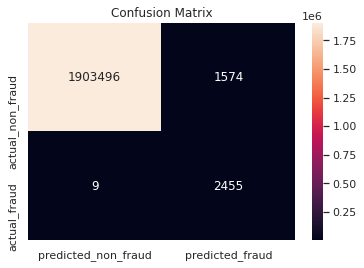

In [12]:
# predictions
yhat = rf_clf.predict(x_test)

# confusion matrix
rf_test_cm = confusion_matrix(y_test, yhat)

# dataframe for heatmap
rf_test_cm_df = pd.DataFrame(rf_test_cm, columns=['predicted_non_fraud', 'predicted_fraud'], index=['actual_non_fraud', 'actual_fraud'])

# confusion matrix heatmap
sns.heatmap(rf_test_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

In [13]:
# Precision
base_model_precision = precision_score(y_test, yhat)

# Recall
base_model_recall = recall_score(y_test, yhat)

print('Base Model Precision: {}'.format(base_model_precision))
print('Base Model Recall: {}'.format(base_model_recall))

Base Model Precision: 0.6093323405311492
Base Model Recall: 0.9963474025974026


### 8.2.3. Tuned Model Performance 1

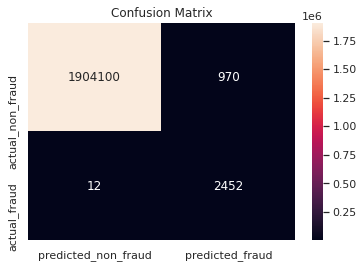

In [17]:
# predictions
yhat_tuned = rf_clf_1.predict(x_test)

# confusion matrix
rf_tuned_test_cm = confusion_matrix(y_test, yhat_tuned)

# dataframe for heatmap
rf_tuned_test_cm_df = pd.DataFrame(rf_tuned_test_cm, columns=['predicted_non_fraud', 'predicted_fraud'], index=['actual_non_fraud', 'actual_fraud'])

# confusion matrix heatmap
sns.heatmap(rf_tuned_test_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

In [18]:
# Precision
tuned_model_precision = precision_score(y_test, yhat_tuned)

# Recall
tuned_model_recall = recall_score(y_test, yhat_tuned)

print('Tuned Model Precision: {}'.format(tuned_model_precision))
print('Tuned Model Recall: {}'.format(tuned_model_recall))

Tuned Model Precision: 0.7165400350672122
Tuned Model Recall: 0.9951298701298701


### 8.2.4. Tuned Model Performance 2

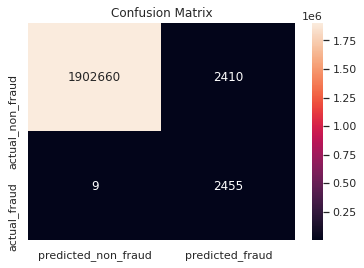

In [19]:
# predictions
yhat_tuned = rf_clf_2.predict(x_test)

# confusion matrix
rf_tuned_test_cm = confusion_matrix(y_test, yhat_tuned)

# dataframe for heatmap
rf_tuned_test_cm_df = pd.DataFrame(rf_tuned_test_cm, columns=['predicted_non_fraud', 'predicted_fraud'], index=['actual_non_fraud', 'actual_fraud'])

# confusion matrix heatmap
sns.heatmap(rf_tuned_test_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

In [20]:
# Precision
tuned_model_precision = precision_score(y_test, yhat_tuned)

# Recall
tuned_model_recall = recall_score(y_test, yhat_tuned)

print('Tuned Model Precision: {}'.format(tuned_model_precision))
print('Tuned Model Recall: {}'.format(tuned_model_recall))

Tuned Model Precision: 0.5046248715313464
Tuned Model Recall: 0.9963474025974026


### 8.2.5. Tuned Model Performance 3

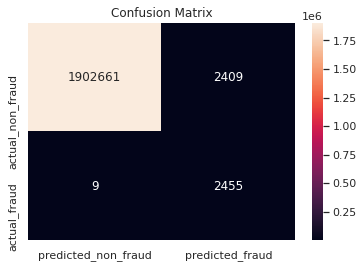

In [21]:
# predictions
yhat_tuned = rf_clf_3.predict(x_test)

# confusion matrix
rf_tuned_test_cm = confusion_matrix(y_test, yhat_tuned)

# dataframe for heatmap
rf_tuned_test_cm_df = pd.DataFrame(rf_tuned_test_cm, columns=['predicted_non_fraud', 'predicted_fraud'], index=['actual_non_fraud', 'actual_fraud'])

# confusion matrix heatmap
sns.heatmap(rf_tuned_test_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

In [22]:
# Precision
tuned_model_precision = precision_score(y_test, yhat_tuned)

# Recall
tuned_model_recall = recall_score(y_test, yhat_tuned)

print('Tuned Model Precision: {}'.format(tuned_model_precision))
print('Tuned Model Recall: {}'.format(tuned_model_recall))

Tuned Model Precision: 0.5047286184210527
Tuned Model Recall: 0.9963474025974026


### 8.2.6. Select model with best performance

- The `RandomizedSearchCV` did not work properly and therefore was not able to complete the task. Hence, the code lines were removed in order to keep the functional script in this notebook.
- This is probably due to: 1. the size of the dataset and 2. The computer memory.
- As the random search executes a cross-validation for each iterations (i.e., for each random hyperparameter combination), the execution and values are stored in the RAM memory, which due to the size of the dataset cannot afford all these steps.
- Hence, in order to experiment other hyperparameter combinations rather than the default one, some combinations were randomly set and evaluated on the test set, as shown above.
- Although the "tuned model 1" showed an improvement in the precision and a slightly decrease in the recall, the base model (i.e., the model with default hyperparameters) showed the best result with respect to the business, therefore it is the chosen model to be deployed.

In [14]:
# save base model
with open('model/model_rf_tuned_v02.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

# 9.0. Model and Business Performance

## 9.1. Model Performance on Test Set

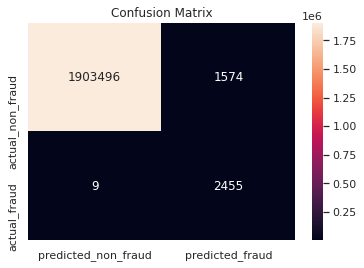

In [15]:
# confusion matrix heatmap
sns.heatmap(rf_test_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

In [16]:
# model precision
precision = precision_score(y_test, yhat)

# model accuracy
accuracy = accuracy_score(y_test, yhat)

# f1-score
f1 = f1_score(y_test, yhat)

# mcc
mcc = matthews_corrcoef(y_test, yhat)

# recall
recall = recall_score(y_test, yhat)

# False Positive Rate
FPR = rf_test_cm[0,1] / rf_test_cm[0].sum()

# summary dataframe
summary_df = pd.DataFrame([precision, accuracy, f1, mcc, recall, FPR], 
                          index=['Precision', 'Accuracy', 'F1-Score','MCC', 'Recall', 'False Positive Rate']).T

summary_df

Precision  Accuracy  F1-Score       MCC    Recall  False Positive Rate
0   0.609332   0.99917  0.756199  0.778844  0.996347             0.000826

## 9.2. Business Performance

### 9.3.1. Expansion Strategy Results

**Blocker Fraud Company Expansion Strategy in Brazil**

1. The company receives 25% of each transaction value truly detected as fraud.
2. The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.
3. The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

In [17]:
# Join predictions on the test set in order to calculate the business performance
test_set['predictions'] = yhat

# The company receives 25% of each transaction value truly detected as fraud.
fraud_detected = test_set[(test_set['is_fraud'] == 1) & (test_set['predictions'] == 1)]
fraud_detected_amount = fraud_detected[['amount', 'is_fraud', 'predictions']].\
    groupby(['is_fraud', 'predictions']).sum().reset_index()
fraud_detected_amount['to_receive'] = fraud_detected_amount['amount']*0.25

# The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.
fraud_detected_leg = test_set[(test_set['is_fraud'] == 0) & (test_set['predictions'] == 1)]
fraud_detected_leg_amount = fraud_detected_leg[['amount', 'is_fraud', 'predictions']].\
    groupby(['is_fraud', 'predictions']).sum().reset_index()
fraud_detected_leg_amount['to_receive'] = fraud_detected_leg_amount['amount']*0.05
fraud_detected_leg_amount

# The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.
fraud_not_detected = test_set[(test_set['is_fraud'] == 1) & (test_set['predictions'] == 0)]
fraud_not_detected_amount = fraud_not_detected[['amount', 'is_fraud', 'predictions']].\
    groupby(['is_fraud', 'predictions']).sum().reset_index()

# print results
print('The company will receive {:,.2f} due to transactions truly detected as fraud'.format(fraud_detected_amount['to_receive'][0]))
print('The company will receive {:,.2f} due to transactions detected as fraud, but actually legitimate'.\
      format(fraud_detected_leg_amount['to_receive'][0]))
print('The company will give back {:,.2f} due to transactions detected as legitimate, but actually fraud'.\
      format(fraud_not_detected_amount['amount'][0]))

The company will receive 879,444,509.42 due to transactions truly detected as fraud
The company will receive 602,524.84 due to transactions detected as fraud, but actually legitimate
The company will give back 2,472,252.25 due to transactions detected as legitimate, but actually fraud


### 9.3.2. Model's Performance Results on the Business

- Model performance and results report with respect to profit and loss. The following questions must be answered:

    - What is the model's precision and accuracy?
    - What is the model's reliability with respect to transactions' classification as legitimate or fraudulent?
    - What is the company's forecasted revenue if the model classifies 100% of the transactions?
    - What is the company's forecasted loss in case of model's failure?
    - What is the Blocker Fraud Company forecasted profit using the model?

- The model has a precision of 60.93% and an accuracy of 99.92%. Remark: the accuracy is not recommended for business metric due to the intrinsic skewed data with respect to fraudulent transactions. Instead, it can be used the F1-Score, which is the harmonic mean of precision and True Positive Rate (also known as Recall). The F1-Score of the model is 75.62%.
- **The model can detect 99.63% of fraudulent transactions.** The false positive rate is only 0.08%.
- The forecasted revenue is more than 879 million from transactions truly detected as fraud and more than 600 thousand from transactions detected as fraud, but actually legitimate.
- The forecasted loss is about 2,4 million due to transactions detected as legitimate, but actually fraud.
- **The Blocker Fraud Company forecasted profit is 877,5 million.**

### 9.3.3. Next Steps

- Model Deployment;
- Train another model in order to improve the True Positive Rate (Recall);
- Model's hyperparameters experiment and evaluation;

# 10.0. Model Deployment

## 10.1. Fraud Detection Class

In [2]:
# import relevant libraries
import pickle
import pandas as pd
import numpy as np
import inflection

# Fraud Detection Class defnition
class FraudDetection(object):
    def __init__(self):
        # file path
        path = '/home/bruno-san/repos/pa002_blocker_fraud_company/'
        
        # load scalers
        self.step_scaler = pickle.load(open(path + 'parameter/step_scaler.pkl', 'rb'))
        self.amount_scaler = pickle.load(open(path + 'parameter/amount_scaler.pkl', 'rb'))
        self.oldbalance_org_scaler = pickle.load(open(path + 'parameter/oldbalance_org_scaler.pkl', 'rb'))
        self.newbalance_orig_scaler = pickle.load(open(path + 'parameter/newbalance_orig_scaler.pkl', 'rb'))
        self.diff_orig_scaler = pickle.load(open(path + 'parameter/diff_orig_scaler.pkl', 'rb'))
        self.oldbalance_dest_scaler = pickle.load(open(path + 'parameter/oldbalance_dest_scaler.pkl', 'rb'))
        self.newbalance_dest_scaler = pickle.load(open(path + 'parameter/newbalance_dest_scaler.pkl', 'rb'))
        self.diff_dest_scaler = pickle.load(open(path + 'parameter/diff_dest_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        # current columns names
        cols_old = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
                    'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
                    'isFlaggedFraud']
        # apply snakecase to columns names
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))

        # Rename columns
        df1.columns = cols_new
        
        return df1
    
    def feature_engineering(self, df2):
        # create origin balance difference feature
        df2['diff_orig'] = df2['oldbalance_org'] - df2['amount'] - df2['newbalance_orig']

        # create destination balance difference feature
        df2['diff_dest'] = df2['oldbalance_dest'] + df2['amount'] - df2['newbalance_dest']

        # create merchant_dest feature
        df2['merchant_dest'] = df2.apply(lambda x: 1 if 'M' in x['name_dest'] else 0, axis=1)

        # create day feature
        df2['day'] = df2.apply(lambda x: (np.ceil(x['step'] / 24)).astype(int), axis=1)

        # reorder columns
        df2 = df2[['step', 'day', 'type', 'name_orig', 'amount', 'oldbalance_org',
                   'newbalance_orig', 'diff_orig', 'name_dest', 'merchant_dest', 
                   'oldbalance_dest', 'newbalance_dest', 'diff_dest',
                   'is_fraud', 'is_flagged_fraud']]
        
        # 3.0. Variables Filtering
        
        # Remove outliers from amount feature
        df2 = df2[df2['amount'] < 20e6]

        # Remove oldbalance_dest outliers
        df2 = df2[df2['oldbalance_dest'] < 5e7]

        # Remove newbalance_dest outliers
        df2 = df2[df2['newbalance_dest'] < 5e7]
        
        return df2
    
    def data_preparation(self, df5):
        # step
        df5['step'] = self.step_scaler.fit_transform(df5[['step']].values)

        # amount
        df5['amount'] = self.amount_scaler.fit_transform(df5[['amount']].values)

        # oldbalance_org
        df5['oldbalance_org'] = self.oldbalance_org_scaler.fit_transform(df5[['oldbalance_org']].values)

        # newbalance_orig
        df5['newbalance_orig'] = self.newbalance_orig_scaler.fit_transform(df5[['newbalance_orig']].values)

        # diff_orig
        df5['diff_orig'] = self.diff_orig_scaler.fit_transform(df5[['diff_orig']].values)

        # oldbalance_dest
        df5['oldbalance_dest'] = self.oldbalance_dest_scaler.fit_transform(df5[['oldbalance_dest']].values)

        # newbalance_dest
        df5['newbalance_dest'] = self.newbalance_dest_scaler.fit_transform(df5[['newbalance_dest']].values)

        # diff_dest
        df5['diff_dest'] = self.diff_dest_scaler.fit_transform(df5[['diff_dest']].values)

        # Encoding
        # type feature - apply one hot encoding
        df5 = pd.get_dummies(df5, prefix=['type'], columns=['type'])

        # Nature Transformation
        # apply nature transformation on day feature
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/31 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/31 ) ) )
        
        # selected features list
        feat_list = ['newbalance_orig', 'diff_orig', 'amount', 'diff_dest', 'newbalance_dest',
                     'oldbalance_org', 'oldbalance_dest', 'type_TRANSFER', 'day_cos', 
                     'type_CASH_OUT', 'day_sin']
        
        return df5[feat_list]
    
    def get_prediction(self, model, original_data, test_data_prep):
        # prediction
        pred = model.predict(test_data_prep)
        
        # join prediction in the original dataset
        original_data['prediction'] = pred
        
        return original_data.to_json(orient='records')

## 10.2. API Handler

In [ ]:
import pickle
import pandas as pd

# import flask, request and response
from flask import Flask, request, Response

# import FraudDetection Class
from frauddetection.FraudDetection import FraudDetection

# file path
path = '/home/bruno-san/repos/pa002_blocker_fraud_company/'

# load model
model = pickle.load(open(path + 'model/model_rf_tuned_v02.pkl', 'rb'))

# initialize API
app = Flask(__name__)

# create endpoint (URL)
# Post method = send data in order to receive data
# the route() decorator tells Flask what URL will triggeer the function.
@app.route('/frauddetection/predict', methods=['POST'])

# funtion to get the received data
def frauddetection_predict():
    test_json = request.get_json()
    
    # check received data (json)
    if test_json: # there is data
        # isinstance() function checks if the object (first argument) is an instance or subclass of classinfo class (second argument)
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: # multiple examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys()) # keys = json keys. They'll become the df columns.
        
        # instantiate FraudDetection Class
        pipeline = FraudDetection()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        test_return = df2.copy()
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_prediction = pipeline.get_prediction(model, test_return, df3)
        
        return df_prediction
    
    else: # there is no data
        return Response('{}', status=200, mimetype='application/json')

# check main function in the script
if __name__ == '__main__':
    app.run('127.0.0.1') # local host

## 10.3. API Tester Local

In [1]:
import requests
import pandas as pd

In [2]:
# load test set
df_test_set = pd.read_csv('dataset/test_set_v02.csv')
df_test_set.head()

step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   140   PAYMENT    6974.39  C2082621352       10503.00         3528.61   
1   374   CASH_IN  157690.96   C452124917       16627.00       174317.96   
2   201   PAYMENT   17907.49  C1149130676       16282.06            0.00   
3   328   PAYMENT   22394.94  C1869542815       75530.38        53135.44   
4   229  CASH_OUT  106631.35   C544369672           0.00            0.00   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1499555496            0.00            0.00        0               0  
1  C1856284436        73436.77            0.00        0               0  
2   M811584793            0.00            0.00        0               0  
3  M1527681304            0.00            0.00        0               0  
4   C285714859      2210314.37      2316945.72        0               0

In [3]:
# convert dataframe to json
data = json.dumps(df_test_set.to_dict(orient='records'))

- For local host url, please execute first handler.py on terminal with the virtual environment (venv) enabled.

In [4]:
# API call
# for local host url, please execute first handler.py on terminal with the venv enabled.
url = 'http://127.0.0.1:5000/frauddetection/predict' # local host
header = {'Content-type': 'application/json'}

# requests - send requisition to endpoint with data
r = requests.post(url, data=data, headers=header)
print('Status code: {}'.format(r.status_code))

Status code: 200


In [5]:
# convert back to dataframe
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sample(5)

step  day      type    name_orig     amount  oldbalance_org  \
1003579   160    7  CASH_OUT  C1900887816  155195.33          5277.0   
668586    254   11   PAYMENT    C20059098   11834.13           401.0   
1748996    11    1   PAYMENT  C1033468564   14818.80             0.0   
857363     11    1   PAYMENT     C7867879   22760.98         60677.0   
535531    352   15  CASH_OUT  C1978034100  252404.07             0.0   

         newbalance_orig  diff_orig    name_dest  merchant_dest  \
1003579             0.00 -149918.33  C1267643544              0   
668586              0.00  -11433.13  M1796293650              1   
1748996             0.00  -14818.80   M143251795              1   
857363          37916.02       0.00  M1136268968              1   
535531              0.00 -252404.07   C648214766              0   

         oldbalance_dest  newbalance_dest  diff_dest  is_fraud  \
1003579             0.00        155195.33       0.00         0   
668586              0.00             0.00   11834.13         0   
1748996             0.00             0.00   14818.80         0   
857363              0.00             0.00   22760.98         0   
535531         836741.07       1089145.15      -0.01         0   

         is_flagged_fraud  prediction  
1003579                 0           0  
668586                  0           0  
1748996                 0           0  
857363                  0           0  
535531                  0           0

## 10.4. API Tester Heroku

In [1]:
import requests
import pandas as pd

In [2]:
# load test set
df_test_set = pd.read_csv('dataset/test_set_v02.csv')
df_test_set.head()

step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   140   PAYMENT    6974.39  C2082621352       10503.00         3528.61   
1   374   CASH_IN  157690.96   C452124917       16627.00       174317.96   
2   201   PAYMENT   17907.49  C1149130676       16282.06            0.00   
3   328   PAYMENT   22394.94  C1869542815       75530.38        53135.44   
4   229  CASH_OUT  106631.35   C544369672           0.00            0.00   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1499555496            0.00            0.00        0               0  
1  C1856284436        73436.77            0.00        0               0  
2   M811584793            0.00            0.00        0               0  
3  M1527681304            0.00            0.00        0               0  
4   C285714859      2210314.37      2316945.72        0               0

In [3]:
# create a smaller test set in order to allow the deployment test at heroku
from sklearn.model_selection import StratifiedShuffleSplit

test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for test_1, test_2 in test_split.split(df_test_set, df_test_set['isFraud']):
    test_90 = df_test_set.loc[test_1]
    test_10 = df_test_set.loc[test_2]

In [4]:
# save test_10 to enable the tests on heroku
test_10.to_csv('dataset/test_10_heroku.csv', index=False)

In [2]:
# open test set for tests on heroku
df_test_heroku = pd.read_csv('dataset/test_10_heroku.csv')
df_test_heroku.head()

step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   300   PAYMENT   10232.03  C1469908728        4088.00            0.00   
1   323  CASH_OUT  239508.77   C177098180       36609.00            0.00   
2   259  CASH_OUT  343046.17   C182761445       19434.00            0.00   
3   347   CASH_IN   51420.92  C1620563018       45631.00        97051.92   
4   277   CASH_IN  139083.39  C1583105381      557251.37       696334.75   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1491589657            0.00            0.00        0               0  
1  C1275357571            0.00       239508.77        0               0  
2  C1738888346        13696.32       356742.49        0               0  
3  C2098269276     17563931.74     17512510.82        0               0  
4  C1069197948       145895.06         6811.68        0               0

In [3]:
df_test_heroku.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190879 entries, 0 to 190878
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            190879 non-null  int64  
 1   type            190879 non-null  object 
 2   amount          190879 non-null  float64
 3   nameOrig        190879 non-null  object 
 4   oldbalanceOrg   190879 non-null  float64
 5   newbalanceOrig  190879 non-null  float64
 6   nameDest        190879 non-null  object 
 7   oldbalanceDest  190879 non-null  float64
 8   newbalanceDest  190879 non-null  float64
 9   isFraud         190879 non-null  int64  
 10  isFlaggedFraud  190879 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 16.0+ MB


In [4]:
# convert dataframe to json
data = json.dumps(df_test_heroku.to_dict(orient='records'))

In [5]:
# API call
url = 'https://frauddetection-model.herokuapp.com/frauddetection/predict' # endpoint heroku
header = {'Content-type': 'application/json'}

# requests - send requisition to endpoint with data
r = requests.post(url, data=data, headers=header)
print('Status code: {}'.format(r.status_code))

Status code: 200


In [6]:
# convert back to dataframe
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sample(5)

step  day      type    name_orig     amount  oldbalance_org  \
17534    375   16  CASH_OUT  C2027476883  215303.74        14708.00   
93220    203    9  CASH_OUT  C1298688414  228788.92          308.00   
182080    37    2   CASH_IN   C249665258  290091.23     12348192.24   
170796   129    6  CASH_OUT  C1548726519  341419.33        23622.70   
84254    332   14   PAYMENT  C2021876491    7874.81        31007.00   

        newbalance_orig  diff_orig    name_dest  merchant_dest  \
17534              0.00 -200595.74   C589894022              0   
93220              0.00 -228480.92   C303509215              0   
182080      12638283.47 -580182.46  C1984154797              0   
170796             0.00 -317796.63  C1870258118              0   
84254          23132.19       0.00   M644754705              1   

        oldbalance_dest  newbalance_dest  diff_dest  is_fraud  \
17534              0.00        215303.74       0.00         0   
93220         148050.44        376839.36       0.00         0   
182080       1780758.10       1490666.88  580182.45         0   
170796       2762662.95       3104082.27       0.01         0   
84254              0.00             0.00    7874.81         0   

        is_flagged_fraud  prediction  
17534                  0           0  
93220                  0           0  
182080                 0           0  
170796                 0           0  
84254                  0           0